<a href="https://colab.research.google.com/github/Yuto-Kishi/ECHONET-Lite/blob/main/estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

データを読み込んでいます...


/tmp/ipython-input-3264914311.py:21: DtypeWarning: Columns (15,44,173,183,186,196) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


 - smart_home_merged_all.csv: 読み込み完了 (13606 行)


/tmp/ipython-input-3264914311.py:40: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  full_data.ffill(inplace=True)
/tmp/ipython-input-3264914311.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  X.loc[:, col] = X[col].astype(int)
/tmp/ipython-input-3264914311.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  X.loc[:, col] = X[col].astype(int)
/tmp/ipython-input-3264914311.py:100: FutureWarning: Setting an item of

使用する特徴量の数: 81

 Living の人数推定を開始します (Target: Label_Living_Count)
[Living] データ拡張中...
[Living] 学習データ数: 38096
[Living] モデル学習中...

★ Living 正解率 (Accuracy): 0.9701
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      2502
           1       0.96      0.96      0.96       779
           2       0.95      0.97      0.96       801

    accuracy                           0.97      4082
   macro avg       0.96      0.97      0.96      4082
weighted avg       0.97      0.97      0.97      4082



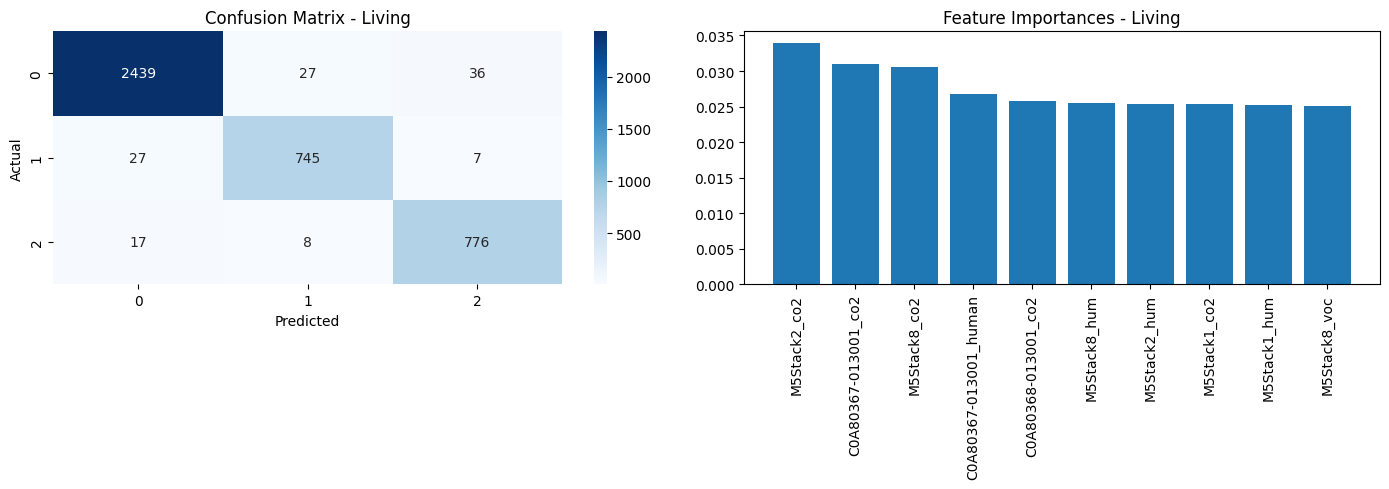


 Japanese (Washitu) の人数推定を開始します (Target: Label_Japanese_Count)
[Japanese (Washitu)] データ拡張中...
[Japanese (Washitu)] 学習データ数: 38096
[Japanese (Washitu)] モデル学習中...


/tmp/ipython-input-3264914311.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  X.loc[:, col] = X[col].astype(int)
/tmp/ipython-input-3264914311.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  X.loc[:, col] = X[col].astype(int)
/tmp/ipython-input-3264914311.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  X.loc[:, col] = X[col].astype(int)
/tmp/ipython-input-3264914311.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated a


★ Japanese (Washitu) 正解率 (Accuracy): 0.9809
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2981
           1       0.96      0.96      0.96       609
           2       0.96      0.97      0.96       492

    accuracy                           0.98      4082
   macro avg       0.97      0.97      0.97      4082
weighted avg       0.98      0.98      0.98      4082



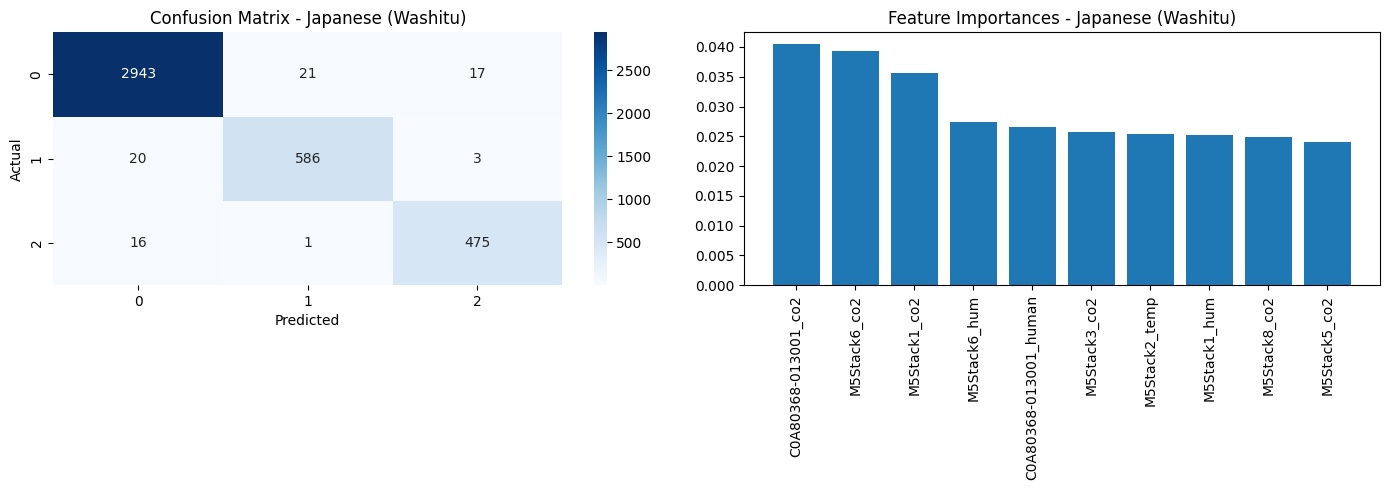

In [ ]:
# ==============================================================================
# ライブラリのインポート
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# ==============================================================================
# 1. データの読み込み
# ==============================================================================
file_names = ["smart_home_merged_all.csv"]
data_list = []

print("データを読み込んでいます...")
for file in file_names:
    try:
        df = pd.read_csv(file)
        data_list.append(df)
        print(f" - {file}: 読み込み完了 ({len(df)} 行)")
    except FileNotFoundError:
        print(f" - {file}: ファイルが見つかりません。")

if not data_list:
    raise ValueError("読み込めるデータがありませんでした。")

full_data = pd.concat(data_list, ignore_index=True)

# タイムスタンプでソート
if 'timestamp' in full_data.columns:
    full_data['timestamp'] = pd.to_datetime(full_data['timestamp'])
    full_data = full_data.sort_values('timestamp').reset_index(drop=True)

# ==============================================================================
# 2. 前処理 (共通)
# ==============================================================================
full_data.ffill(inplace=True)
full_data.fillna(0, inplace=True)

# 特徴量の自動選択 (全センサーを使用)
sensor_cols = [c for c in full_data.columns if any(x in c for x in ['_co2', '_temp', '_hum', '_voc', '_pm2_5'])]
pir_cols = [c for c in full_data.columns if 'PIR' in c]
features = sensor_cols + pir_cols

print(f"使用する特徴量の数: {len(features)}")

# ==============================================================================
# 3. データオーグメンテーション関数
# ==============================================================================
def augment_data(X, y, noise_level=0.05, shift_steps=[-1, 1]):
    X_aug_list = [X]
    y_aug_list = [y]

    # 1. ノイズ付加
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    noise = np.random.normal(0, noise_level, X[numeric_cols].shape)
    X_noise = X.copy()
    X_noise[numeric_cols] = X_noise[numeric_cols] + noise
    X_aug_list.append(X_noise)
    y_aug_list.append(y)

    # 2. タイムシフト
    for step in shift_steps:
        X_shifted = X.shift(step).bfill().ffill()
        X_aug_list.append(X_shifted)
        y_aug_list.append(y)

    return pd.concat(X_aug_list, ignore_index=True), pd.concat(y_aug_list, ignore_index=True)

# ==============================================================================
# 4. 学習と評価のループ (リビング・和室 それぞれ実行)
# ==============================================================================
target_rooms = {
    'Living': 'Label_Living_Count',
    'Japanese (Washitu)': 'Label_Japanese_Count'
}

for room_name, target_col in target_rooms.items():
    print(f"\n" + "="*60)
    print(f" {room_name} の人数推定を開始します (Target: {target_col})")
    print("="*60)

    # ターゲットがない場合はスキップ
    if target_col not in full_data.columns:
        print(f"エラー: {target_col} がデータに含まれていません。スキップします。")
        continue

    # モデル用データの作成
    df_model = full_data[features + [target_col]].copy()
    df_model.dropna(subset=[target_col], inplace=True)

    X = df_model[features]
    y = df_model[target_col]

    # Boolean -> Int
    for col in X.select_dtypes(include=['bool']).columns:
        X.loc[:, col] = X[col].astype(int)

    # 分割
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

    # データ拡張
    print(f"[{room_name}] データ拡張中...")
    X_train_aug, y_train_aug = augment_data(X_train, y_train, noise_level=0.05, shift_steps=[-1, 1])
    print(f"[{room_name}] 学習データ数: {len(X_train_aug)}")

    # 学習
    print(f"[{room_name}] モデル学習中...")
    model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)
    model.fit(X_train_aug, y_train_aug)

    # 評価
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print(f"\n★ {room_name} 正解率 (Accuracy): {acc:.4f}")
    print(classification_report(y_test, y_pred))

    # --- 可視化 ---
    plt.figure(figsize=(14, 5))

    # 混同行列
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {room_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # 特徴量重要度 (Top 10)
    plt.subplot(1, 2, 2)
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:10]
    plt.title(f"Feature Importances - {room_name}")
    plt.bar(range(10), importances[indices], align="center")
    plt.xticks(range(10), [features[i] for i in indices], rotation=90)

    plt.tight_layout()
    plt.show()

In [ ]:
import numpy as np
import pandas as pd

RAW_CSV = "./smart_home_merged_all.csv"
OUT_CSV = "./smart_home_features_engineered.csv"

# =========
# 1) 対象センサー定義（厳密に）
# =========
ROOM_SENSORS = {
    "Living": {
        "aircon_prefix": "C0A80367-013001_",
        "purifier_prefix": "C0A8033B-013501",
        "m5_prefixes": ["M5Stack2_", "M5Stack8_"],
        "pir_ids": [1, 2, 3, 4, 18],  # リビングPIR1-4、キッチンPIR18
        "count_label": "Label_Living_Count",
    },
    "Japanese": {
        "aircon_prefix": "C0A80368-013001_",
        "purifier_prefix": "C0A80341-013501",
        "m5_prefixes": ["M5Stack1_"],
        "pir_ids": [17, 21],
        "count_label": "Label_Japanese_Count",
    }
}

# =========
# 2) ユーティリティ
# =========
def safe_read_csv(path: str) -> pd.DataFrame:
    df = pd.read_csv(path, low_memory=False)
    if "timestamp" not in df.columns:
        raise ValueError("timestamp列が必要です（時系列特徴量のため）")
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    df = df.sort_values("timestamp").reset_index(drop=True)
    return df

def exact_pir_cols(df: pd.DataFrame, pir_ids: list[int]) -> list[str]:
    # ✅ "PIR1" が "PIR13" にマッチしないよう、先頭一致を厳密にする
    cols = []
    for pid in pir_ids:
        # 例: PIR1_motion, PIR1, PIR1_xxx などを拾う（必要に応じて調整）
        cols += [c for c in df.columns if c.startswith(f"PIR{pid}_") or c == f"PIR{pid}"]
    # 重複除去
    cols = list(dict.fromkeys(cols))
    return cols

def prefix_cols(df: pd.DataFrame, prefix: str) -> list[str]:
    # startswith優先、空気清浄機は列名揺れがあり得るので contains も許容
    cols = [c for c in df.columns if c.startswith(prefix)]
    if len(cols) == 0:
        cols = [c for c in df.columns if prefix in c]
    return list(dict.fromkeys(cols))

def m5_cols(df: pd.DataFrame, prefixes: list[str]) -> list[str]:
    cols = []
    for p in prefixes:
        cols += [c for c in df.columns if c.startswith(p) or p in c]
    return list(dict.fromkeys(cols))

def sanitize_df(df: pd.DataFrame) -> pd.DataFrame:
    # inf→NaN→補完→残り0
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.bfill().ffill()
    df = df.fillna(0)
    return df.infer_objects(copy=False)

def add_rate_features(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    # 差分（rate）: 1ステップ差分（時間間隔が一定でない場合は近似）
    for c in cols:
        if pd.api.types.is_numeric_dtype(df[c]):
            df[f"{c}_diff"] = df[c].diff().fillna(0)
    return df

def add_rolling_features(df: pd.DataFrame, cols: list[str], windows=("5min","15min")) -> pd.DataFrame:
    # timestampをIndexにして time-based rolling（過去のみ）
    dfi = df.set_index("timestamp")
    for c in cols:
        if pd.api.types.is_numeric_dtype(dfi[c]):
            for w in windows:
                dfi[f"{c}_mean_{w}"] = dfi[c].rolling(w, min_periods=1).mean()
                dfi[f"{c}_std_{w}"]  = dfi[c].rolling(w, min_periods=1).std().fillna(0)
                dfi[f"{c}_min_{w}"]  = dfi[c].rolling(w, min_periods=1).min()
                dfi[f"{c}_max_{w}"]  = dfi[c].rolling(w, min_periods=1).max()
    return dfi.reset_index()

def add_pir_recent_counts(df: pd.DataFrame, pir_cols: list[str], windows=("1min","5min")) -> pd.DataFrame:
    # PIRは 0/1 の motion を想定。直近ウィンドウの発火回数/最大値を入れる
    dfi = df.set_index("timestamp")
    for c in pir_cols:
        if c in dfi.columns and pd.api.types.is_numeric_dtype(dfi[c]):
            for w in windows:
                dfi[f"{c}_sum_{w}"] = dfi[c].rolling(w, min_periods=1).sum()
                dfi[f"{c}_max_{w}"] = dfi[c].rolling(w, min_periods=1).max()
    return dfi.reset_index()

# =========
# 3) CSV生成
# =========
raw = safe_read_csv(RAW_CSV)

# まずLabelは残す（学習時に特徴量に入れない）
keep_cols = ["timestamp"] + [cfg["count_label"] for cfg in ROOM_SENSORS.values()]
keep_cols = [c for c in keep_cols if c in raw.columns]

# 対象センサー列を厳密に収集
selected_cols = set(keep_cols)
room_feature_cols = {}

for room, cfg in ROOM_SENSORS.items():
    air_cols = prefix_cols(raw, cfg["aircon_prefix"])
    pur_cols = prefix_cols(raw, cfg["purifier_prefix"])
    m5c = m5_cols(raw, cfg["m5_prefixes"])
    pir = exact_pir_cols(raw, cfg["pir_ids"])

    cols = list(dict.fromkeys(air_cols + pur_cols + m5c + pir))
    room_feature_cols[room] = cols
    selected_cols.update(cols)

# 抜き出し
df = raw[list(selected_cols)].copy()
df = sanitize_df(df)

# 追加特徴量（部屋ごとにまとめて作る：diff/rolling/pir集計）
all_numeric_cols = [c for c in df.columns if c != "timestamp" and pd.api.types.is_numeric_dtype(df[c])]

# diff（CO2等の変化）
df = add_rate_features(df, all_numeric_cols)

# rolling（過去のみ、未来見ない）
df = add_rolling_features(df, all_numeric_cols, windows=("5min","15min"))

# PIR recent counts（過去のみ）
pir_all = []
for room, cfg in ROOM_SENSORS.items():
    pir_all += exact_pir_cols(df, cfg["pir_ids"])
pir_all = list(dict.fromkeys(pir_all))
df = add_pir_recent_counts(df, pir_all, windows=("1min","5min"))

# 最後にもう一度sanitize（rollingでstdのNaNとか出るので）
df = sanitize_df(df)

# 保存
df.to_csv(OUT_CSV, index=False)
print(f"[DONE] engineered features saved: {OUT_CSV}")
print(f"[INFO] rows={len(df)}, cols={len(df.columns)}")


/tmp/ipython-input-1920561458.py:64: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.bfill().ffill()
/tmp/ipython-input-1920561458.py:81: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dfi[f"{c}_mean_{w}"] = dfi[c].rolling(w, min_periods=1).mean()
/tmp/ipython-input-1920561458.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfr

[DONE] engineered features saved: ./smart_home_features_engineered.csv
[INFO] rows=13606, cols=966


In [ ]:
import numpy as np
import pandas as pd

RAW_CSV = "./smart_home_merged_all.csv"
OUT_CSV = "./smart_home_features_engineered.csv"

# =========
# 1) 対象センサー定義（厳密に）
# =========
ROOM_SENSORS = {
    "Living": {
        "aircon_prefix": "C0A80367-013001_",
        "purifier_prefix": "C0A8033B-013501",
        "m5_prefixes": ["M5Stack2_", "M5Stack8_"],
        "pir_ids": [1, 2, 3, 4, 18],  # リビングPIR1-4、キッチンPIR18
        "count_label": "Label_Living_Count",
    },
    "Japanese": {
        "aircon_prefix": "C0A80368-013001_",
        "purifier_prefix": "C0A80341-013501",
        "m5_prefixes": ["M5Stack1_"],
        "pir_ids": [17, 21],
        "count_label": "Label_Japanese_Count",
    }
}

# =========
# 2) ユーティリティ
# =========
def safe_read_csv(path: str) -> pd.DataFrame:
    df = pd.read_csv(path, low_memory=False)
    if "timestamp" not in df.columns:
        raise ValueError("timestamp列が必要です（時系列特徴量のため）")
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    df = df.sort_values("timestamp").reset_index(drop=True)
    return df

def exact_pir_cols(df: pd.DataFrame, pir_ids: list[int]) -> list[str]:
    # ✅ "PIR1" が "PIR13" にマッチしないよう、先頭一致を厳密にする
    cols = []
    for pid in pir_ids:
        # 例: PIR1_motion, PIR1, PIR1_xxx などを拾う（必要に応じて調整）
        cols += [c for c in df.columns if c.startswith(f"PIR{pid}_") or c == f"PIR{pid}"]
    # 重複除去
    cols = list(dict.fromkeys(cols))
    return cols

def prefix_cols(df: pd.DataFrame, prefix: str) -> list[str]:
    # startswith優先、空気清浄機は列名揺れがあり得るので contains も許容
    cols = [c for c in df.columns if c.startswith(prefix)]
    if len(cols) == 0:
        cols = [c for c in df.columns if prefix in c]
    return list(dict.fromkeys(cols))

def m5_cols(df: pd.DataFrame, prefixes: list[str]) -> list[str]:
    cols = []
    for p in prefixes:
        cols += [c for c in df.columns if c.startswith(p) or p in c]
    return list(dict.fromkeys(cols))

def sanitize_df(df: pd.DataFrame) -> pd.DataFrame:
    # inf→NaN→補完→残り0
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.bfill().ffill()
    df = df.fillna(0)
    return df.infer_objects(copy=False)

def add_rate_features(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    # 差分（rate）: 1ステップ差分（時間間隔が一定でない場合は近似）
    for c in cols:
        if pd.api.types.is_numeric_dtype(df[c]):
            df[f"{c}_diff"] = df[c].diff().fillna(0)
    return df

def add_rolling_features(df: pd.DataFrame, cols: list[str], windows=("5min","15min")) -> pd.DataFrame:
    # timestampをIndexにして time-based rolling（過去のみ）
    dfi = df.set_index("timestamp")
    for c in cols:
        if pd.api.types.is_numeric_dtype(dfi[c]):
            for w in windows:
                dfi[f"{c}_mean_{w}"] = dfi[c].rolling(w, min_periods=1).mean()
                dfi[f"{c}_std_{w}"]  = dfi[c].rolling(w, min_periods=1).std().fillna(0)
                dfi[f"{c}_min_{w}"]  = dfi[c].rolling(w, min_periods=1).min()
                dfi[f"{c}_max_{w}"]  = dfi[c].rolling(w, min_periods=1).max()
    return dfi.reset_index()

def add_pir_recent_counts(df: pd.DataFrame, pir_cols: list[str], windows=("1min","5min")) -> pd.DataFrame:
    # PIRは 0/1 の motion を想定。直近ウィンドウの発火回数/最大値を入れる
    dfi = df.set_index("timestamp")
    for c in pir_cols:
        if c in dfi.columns and pd.api.types.is_numeric_dtype(dfi[c]):
            for w in windows:
                dfi[f"{c}_sum_{w}"] = dfi[c].rolling(w, min_periods=1).sum()
                dfi[f"{c}_max_{w}"] = dfi[c].rolling(w, min_periods=1).max()
    return dfi.reset_index()

# =========
# 3) CSV生成
# =========
raw = safe_read_csv(RAW_CSV)

# まずLabelは残す（学習時に特徴量に入れない）
keep_cols = ["timestamp"] + [cfg["count_label"] for cfg in ROOM_SENSORS.values()]
keep_cols = [c for c in keep_cols if c in raw.columns]

# 対象センサー列を厳密に収集
selected_cols = set(keep_cols)
room_feature_cols = {}

for room, cfg in ROOM_SENSORS.items():
    air_cols = prefix_cols(raw, cfg["aircon_prefix"])
    pur_cols = prefix_cols(raw, cfg["purifier_prefix"])
    m5c = m5_cols(raw, cfg["m5_prefixes"])
    pir = exact_pir_cols(raw, cfg["pir_ids"])

    cols = list(dict.fromkeys(air_cols + pur_cols + m5c + pir))
    room_feature_cols[room] = cols
    selected_cols.update(cols)

# 抜き出し
df = raw[list(selected_cols)].copy()
df = sanitize_df(df)

# 追加特徴量（部屋ごとにまとめて作る：diff/rolling/pir集計）
all_numeric_cols = [c for c in df.columns if c != "timestamp" and pd.api.types.is_numeric_dtype(df[c])]

# diff（CO2等の変化）
df = add_rate_features(df, all_numeric_cols)

# rolling（過去のみ、未来見ない）
df = add_rolling_features(df, all_numeric_cols, windows=("5min","15min"))

# PIR recent counts（過去のみ）
pir_all = []
for room, cfg in ROOM_SENSORS.items():
    pir_all += exact_pir_cols(df, cfg["pir_ids"])
pir_all = list(dict.fromkeys(pir_all))
df = add_pir_recent_counts(df, pir_all, windows=("1min","5min"))

# 最後にもう一度sanitize（rollingでstdのNaNとか出るので）
df = sanitize_df(df)

# 保存
df.to_csv(OUT_CSV, index=False)
print(f"[DONE] engineered features saved: {OUT_CSV}")
print(f"[INFO] rows={len(df)}, cols={len(df.columns)}")


/tmp/ipython-input-1920561458.py:64: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.bfill().ffill()
/tmp/ipython-input-1920561458.py:81: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dfi[f"{c}_mean_{w}"] = dfi[c].rolling(w, min_periods=1).mean()
/tmp/ipython-input-1920561458.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfr

[DONE] engineered features saved: ./smart_home_features_engineered.csv
[INFO] rows=13606, cols=966


In [ ]:
# ============================================================
# SmartHome: Living / Japanese
# 入力：対象部屋に設置された家電・センサーだけ（エアコン/空気清浄機/M5Stack/PIR）
# タスク：在不在（0/1）と人数（0/1/2）を「別モデル」で学習
# 分割：時系列 split（shuffleしない）でリーク抑制
# 出力：各epochの train/val loss と lr
# 重要度：Permutation Importance（test上で accuracy低下量）
#
# ✅ NaN/inf対策込み（loss=nan を止める）
# ✅ 分散0（一定値）列の自動除去
# ✅ 列名揺れ対策：startswith & contains 両方で拾う
# ============================================================

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# ------------------------------------------------------------
# 0) 設定
# ------------------------------------------------------------
CSV_PATH = "./smart_home_features_added.csv"

# 部屋ごとの “使ってよい” デバイス/センサー識別トークン
# ※列名に以下の文字列が「含まれる」 or 「先頭一致」する列だけを使う
ROOMS = {
    "Living": {
        "count_label": "Label_Living_Count",
        "tokens": [
            # Living aircon
            "C0A80367-013001_",
            # Living air purifier
            "C0A8033B-013501",
            # M5Stack
            "M5Stack2", "M5Stack8",
            # PIR
            "PIR1", "PIR2", "PIR3", "PIR4", "PIR18",
        ],
    },
    "Japanese": {
        "count_label": "Label_Japanese_Count",
        "tokens": [
            # Japanese aircon
            "C0A80368-013001_",
            # Japanese air purifier
            "C0A80341-013501",
            # M5Stack
            "M5Stack1",
            # PIR
            "PIR17", "PIR21",
        ],
    },
}

# 時系列 split 比率（例：70% train / 15% val / 15% test）
TRAIN_RATIO = 0.70
VAL_RATIO   = 0.15

# 学習設定
SEED = 42
EPOCHS = 30
BATCH_SIZE = 256
LR = 1e-3
WEIGHT_DECAY = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Permutation importance 設定
PERM_REPEAT = 3

np.random.seed(SEED)
torch.manual_seed(SEED)

# ------------------------------------------------------------
# 1) データ読み込み + 安全な欠損処理（超重要）
# ------------------------------------------------------------
df = pd.read_csv(CSV_PATH, low_memory=False)

# timestampがあるなら時系列ソート
if "timestamp" in df.columns:
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    df = df.sort_values("timestamp").reset_index(drop=True)

# ✅ NaN/inf対策（loss=nanの主原因対策）
# 1) infをNaNに
df = df.replace([np.inf, -np.inf], np.nan)
# 2) 前後で埋める
df = df.bfill().ffill()
# 3) それでも残るNaNは0（最後の保険）
df = df.fillna(0)
# 4) FutureWarning対策（型推定）
df = df.infer_objects(copy=False)

# Label/Action列は特徴量に混ぜない（リーク＆文字列混入防止）
label_cols  = [c for c in df.columns if c.startswith("Label_")]
action_cols = [c for c in df.columns if "Action" in c]

# ------------------------------------------------------------
# 2) 部屋ごとの特徴量列抽出（startswith & contains）
# ------------------------------------------------------------
def build_feature_cols(df_room: pd.DataFrame, tokens: list[str]) -> list[str]:
    # 数値/Boolだけに限定（文字列列を除去）
    numeric_cols = set(df_room.select_dtypes(include=["number", "bool"]).columns)

    cols = []
    for c in df_room.columns:
        if c in label_cols or c in action_cols:
            continue
        if c not in numeric_cols:
            continue

        # token一致（startswith または contains）
        if any(c.startswith(t) for t in tokens) or any(t in c for t in tokens):
            cols.append(c)

    # bool -> int
    for c in cols:
        if df_room[c].dtype == bool:
            df_room[c] = df_room[c].astype(int)

    # 重複除去（順序維持）
    seen = set()
    uniq = []
    for c in cols:
        if c not in seen:
            uniq.append(c)
            seen.add(c)
    return uniq

# ------------------------------------------------------------
# 3) Dataset / Model（単一タスク分類：在不在 or 人数）
# ------------------------------------------------------------
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, i):
        return self.X[i], self.y[i]

class MLPClassifier(nn.Module):
    def __init__(self, in_dim, n_class, hidden=128, dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, n_class),
        )
    def forward(self, x):
        return self.net(x)

# ------------------------------------------------------------
# 4) 学習 / 予測
# ------------------------------------------------------------
def fit_mlp_classifier(X_train, y_train, X_val, y_val, n_class: int, title: str):
    model = MLPClassifier(in_dim=X_train.shape[1], n_class=n_class).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

    train_loader = DataLoader(TabularDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(TabularDataset(X_val,   y_val),   batch_size=BATCH_SIZE, shuffle=False)

    best_val = float("inf")
    best_state = None

    print(f"\n[{title}] optimizer=AdamW lr={LR} weight_decay={WEIGHT_DECAY}")
    print(f"[{title}] loss=CrossEntropyLoss")

    for epoch in range(1, EPOCHS + 1):
        # ---- train ----
        model.train()
        tr_losses = []
        for xb, yb in train_loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)

            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)

            # もしここでNaNが出たらデータ側がまだ壊れている
            if not torch.isfinite(loss):
                print(f"[{title}] ERROR: loss is not finite (NaN/inf). Check X for NaN/inf.")
                return model

            loss.backward()
            optimizer.step()
            tr_losses.append(loss.item())

        # ---- val ----
        model.eval()
        va_losses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(DEVICE)
                yb = yb.to(DEVICE)
                logits = model(xb)
                loss = criterion(logits, yb)
                va_losses.append(loss.item())

        tr = float(np.mean(tr_losses)) if len(tr_losses) else np.nan
        va = float(np.mean(va_losses)) if len(va_losses) else np.nan
        print(f"[{title}][Epoch {epoch:02d}] train_loss={tr:.4f} val_loss={va:.4f} (lr={optimizer.param_groups[0]['lr']:.2e})")

        if va < best_val:
            best_val = va
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    if best_state is not None:
        model.load_state_dict(best_state)
    return model

def predict(model, X):
    model.eval()
    # ダミーy（未使用）
    loader = DataLoader(TabularDataset(X, np.zeros(len(X), dtype=int)), batch_size=BATCH_SIZE, shuffle=False)
    preds = []
    with torch.no_grad():
        for xb, _ in loader:
            xb = xb.to(DEVICE)
            logits = model(xb)
            pred = torch.argmax(logits, dim=1).cpu().numpy()
            preds.append(pred)
    return np.concatenate(preds)

# ------------------------------------------------------------
# 5) Permutation Importance（accuracy低下量）
# ------------------------------------------------------------
def permutation_importance_accuracy(model, X_test, y_test, feature_cols, n_repeat=3, seed=0):
    rng = np.random.default_rng(seed)
    base_pred = predict(model, X_test)
    base_acc = accuracy_score(y_test, base_pred)

    importances = []
    X_work = X_test.copy()

    for j in range(X_test.shape[1]):
        drops = []
        for _ in range(n_repeat):
            saved = X_work[:, j].copy()
            rng.shuffle(X_work[:, j])
            pred = predict(model, X_work)
            acc = accuracy_score(y_test, pred)
            drops.append(base_acc - acc)
            X_work[:, j] = saved
        importances.append(float(np.mean(drops)))

    imp = pd.DataFrame({
        "feature": feature_cols,
        "importance_drop_acc": importances,
    }).sort_values("importance_drop_acc", ascending=False)

    return base_acc, imp

# ------------------------------------------------------------
# 6) デバッグ：NaN/inf/分散0チェック（原因特定に効く）
# ------------------------------------------------------------
def debug_feature_quality(df_room, feature_cols, room_name, task_name):
    Xd = df_room[feature_cols].copy()

    nan_counts = Xd.isna().sum().sort_values(ascending=False)
    inf_counts = np.isinf(Xd.to_numpy()).sum(axis=0)
    inf_series = pd.Series(inf_counts, index=feature_cols).sort_values(ascending=False)

    print(f"\n[DEBUG][{room_name}][{task_name}] NaN top5:")
    print(nan_counts.head(5).to_string())
    print(f"[DEBUG][{room_name}][{task_name}] inf top5:")
    print(inf_series.head(5).to_string())

# ------------------------------------------------------------
# 7) メイン：部屋ごとに
#    - 在不在（2クラス）
#    - 人数（3クラス）
#    を別々に学習＆重要度算出
# ------------------------------------------------------------
for room_name, cfg in ROOMS.items():
    label_col = cfg["count_label"]
    tokens = cfg["tokens"]

    if label_col not in df.columns:
        print(f"[SKIP] {room_name}: label not found: {label_col}")
        continue

    # 実験条件：0/1/2 のみ使う（それ以外があれば除外）
    valid = df[label_col].isin([0, 1, 2])
    df_room = df.loc[valid].reset_index(drop=True)

    # 特徴量列抽出
    feature_cols = build_feature_cols(df_room, tokens)
    if len(feature_cols) == 0:
        print(f"[ERROR] {room_name}: feature_cols empty. tokensが列名と合ってない可能性。")
        print("  tokens =", tokens)
        continue

    # 分散0（一定値）列を落とす（学習に不要＆不安定要因）
    std = df_room[feature_cols].std(numeric_only=True)
    const_cols = std[std == 0].index.tolist()
    if const_cols:
        print(f"[INFO] {room_name}: drop constant cols ({len(const_cols)}): {const_cols}")
        feature_cols = [c for c in feature_cols if c not in const_cols]

    if len(feature_cols) == 0:
        print(f"[ERROR] {room_name}: all features became constant and were dropped.")
        continue

    # ラベル作成
    y_count = df_room[label_col].astype(int).values             # 0/1/2
    y_occ   = (y_count > 0).astype(int)                         # 0/1（在不在は別タスク）

    # 時系列 split（shuffleなし）
    N = len(df_room)
    tr_end = int(N * TRAIN_RATIO)
    va_end = int(N * (TRAIN_RATIO + VAL_RATIO))

    X_all = df_room[feature_cols].values

    X_tr, X_va, X_te = X_all[:tr_end], X_all[tr_end:va_end], X_all[va_end:]
    yc_tr, yc_va, yc_te = y_count[:tr_end], y_count[tr_end:va_end], y_count[va_end:]
    yo_tr, yo_va, yo_te = y_occ[:tr_end],   y_occ[tr_end:va_end],   y_occ[va_end:]

    # ✅ scalerは trainでfitのみ（リーク防止）
    scaler = StandardScaler()

    # ここで warning/NaN が起きるときは X_tr に NaN/inf が残ってることが多い
    # 追加の安全策：X_tr/X_va/X_te の inf を NaN にして0埋め（念のため）
    def sanitize_X(X):
        X = np.array(X, dtype=np.float32)
        X[~np.isfinite(X)] = 0.0
        return X

    X_tr = sanitize_X(X_tr)
    X_va = sanitize_X(X_va)
    X_te = sanitize_X(X_te)

    X_tr = scaler.fit_transform(X_tr)
    X_va = scaler.transform(X_va)
    X_te = scaler.transform(X_te)

    # さらに標準化後の NaN/inf も殺す（最後の保険）
    X_tr = sanitize_X(X_tr)
    X_va = sanitize_X(X_va)
    X_te = sanitize_X(X_te)

    print("\n" + "="*90)
    print(f"[ROOM] {room_name}")
    print(f"[INFO] label={label_col} | N={N} | train={len(X_tr)} val={len(X_va)} test={len(X_te)}")
    print(f"[INFO] features={len(feature_cols)} (show first 15):")
    print("  " + ", ".join(feature_cols[:15]) + (" ..." if len(feature_cols) > 15 else ""))
    print("="*90)

    # --------------------------------------------------------
    # (A) 在不在モデル（2クラス）
    # --------------------------------------------------------
    debug_feature_quality(df_room.iloc[:tr_end], feature_cols, room_name, "Occupancy(train-slice)")

    occ_model = fit_mlp_classifier(X_tr, yo_tr, X_va, yo_va, n_class=2, title=f"{room_name}-Occupancy")
    occ_pred = predict(occ_model, X_te)

    print(f"\n[{room_name}][TEST] Occupancy (0/1) acc = {accuracy_score(yo_te, occ_pred):.4f}")
    print("Confusion matrix:\n", confusion_matrix(yo_te, occ_pred))
    print("Report:\n", classification_report(yo_te, occ_pred, zero_division=0))

    base_acc_occ, imp_occ = permutation_importance_accuracy(
        occ_model, X_te, yo_te, feature_cols, n_repeat=PERM_REPEAT, seed=SEED
    )
    print(f"\n[{room_name}] Occupancy Permutation Importance (Top 15) | base_acc={base_acc_occ:.4f}")
    print(imp_occ.head(15).to_string(index=False))

    # --------------------------------------------------------
    # (B) 人数モデル（3クラス：0/1/2）
    # --------------------------------------------------------
    debug_feature_quality(df_room.iloc[:tr_end], feature_cols, room_name, "Count(train-slice)")

    cnt_model = fit_mlp_classifier(X_tr, yc_tr, X_va, yc_va, n_class=3, title=f"{room_name}-Count(0/1/2)")
    cnt_pred = predict(cnt_model, X_te)

    print(f"\n[{room_name}][TEST] Count (0/1/2) acc = {accuracy_score(yc_te, cnt_pred):.4f}")
    print("Confusion matrix:\n", confusion_matrix(yc_te, cnt_pred))
    print("Report:\n", classification_report(yc_te, cnt_pred, zero_division=0))

    base_acc_cnt, imp_cnt = permutation_importance_accuracy(
        cnt_model, X_te, yc_te, feature_cols, n_repeat=PERM_REPEAT, seed=SEED
    )
    print(f"\n[{room_name}] Count Permutation Importance (Top 15) | base_acc={base_acc_cnt:.4f}")
    print(imp_cnt.head(15).to_string(index=False))

print("\n[DONE] finished.")


/tmp/ipython-input-4074596651.py:92: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.bfill().ffill()


[INFO] Living: drop constant cols (7): ['C0A8033B-013501_opStatus', 'C0A8033B-013501_flow', 'C0A80367-013001_mode', 'C0A80367-013001_blowTemp', 'C0A80367-013001_flow', 'C0A80367-013001_blowTemp_rate', 'C0A80367-013001_blowTemp_rate_smooth']

[ROOM] Living
[INFO] label=Label_Living_Count | N=13606 | train=9524 val=2041 test=2041
[INFO] features=72 (show first 15):
  PIR1_motion, PIR2_motion, PIR3_motion, PIR4_motion, PIR18_motion, PIR13_motion, PIR11_motion, PIR21_motion, PIR17_motion, PIR10_motion, PIR15_motion, PIR19_motion, PIR20_motion, PIR22_motion, PIR24_motion ...

[DEBUG][Living][Occupancy(train-slice)] NaN top5:
PIR1_motion     0
PIR2_motion     0
PIR3_motion     0
PIR4_motion     0
PIR18_motion    0
[DEBUG][Living][Occupancy(train-slice)] inf top5:
PIR1_motion     0
PIR2_motion     0
PIR3_motion     0
PIR4_motion     0
PIR18_motion    0

[Living-Occupancy] optimizer=AdamW lr=0.001 weight_decay=0.0001
[Living-Occupancy] loss=CrossEntropyLoss
[Living-Occupancy][Epoch 01] train_l

In [ ]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance

CSV_PATH = "smart_home_merged_all.csv"
SEED = 42

ROOMS = {
    "Living": {
        "label": "Label_Living_Count",
        "aircon_prefix": "C0A80367-013001_",
        "purifier_prefix": "C0A8033B-013501",
        "m5_prefixes": ["M5Stack2_", "M5Stack8_"],
        "pir_ids": [1,2,3,4,18],
    },
    "Japanese (Washitu)": {
        "label": "Label_Japanese_Count",
        "aircon_prefix": "C0A80368-013001_",
        "purifier_prefix": "C0A80341-013501",
        "m5_prefixes": ["M5Stack1_"],
        "pir_ids": [17,21],
    }
}

TRAIN_RATIO = 0.70
VAL_RATIO = 0.15     # testは最後の 15%（val区間は触らない）
PERM_REPEAT = 5

RF_PARAMS = dict(
    n_estimators=800,
    random_state=SEED,
    n_jobs=-1,
    min_samples_leaf=2,
    class_weight="balanced_subsample",
)

def sanitize_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df.replace([np.inf, -np.inf], np.nan)
    # 時系列は未来を埋めたくないので、基本は ffill → 残り0
    df = df.ffill()
    df = df.fillna(0)
    return df.infer_objects(copy=False)

def prefix_cols(df: pd.DataFrame, prefix: str) -> list[str]:
    cols = [c for c in df.columns if c.startswith(prefix)]
    if len(cols) == 0:
        cols = [c for c in df.columns if prefix in c]
    return list(dict.fromkeys(cols))

def m5_cols(df: pd.DataFrame, prefixes: list[str]) -> list[str]:
    cols = []
    for p in prefixes:
        cols += [c for c in df.columns if c.startswith(p) or p in c]
    return list(dict.fromkeys(cols))

def exact_pir_cols(df: pd.DataFrame, pir_ids: list[int]) -> list[str]:
    cols = []
    for pid in pir_ids:
        cols += [c for c in df.columns if c.startswith(f"PIR{pid}_") or c == f"PIR{pid}"]
    return list(dict.fromkeys(cols))

def time_split_indices(N: int):
    tr_end = int(N * TRAIN_RATIO)
    va_end = int(N * (TRAIN_RATIO + VAL_RATIO))
    idx_tr = np.arange(0, tr_end)
    idx_te = np.arange(va_end, N)   # 真ん中のvalは使わず、test隔離を強める
    return idx_tr, idx_te

df = pd.read_csv(CSV_PATH, low_memory=False)
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df = df.sort_values("timestamp").reset_index(drop=True)
df = sanitize_df(df)

for room, cfg in ROOMS.items():
    label = cfg["label"]
    if label not in df.columns:
        print(f"[SKIP] {room}: no label {label}")
        continue

    # 0/1/2 のみ（実験条件）
    dfr = df[df[label].isin([0,1,2])].copy().reset_index(drop=True)

    # 部屋の対象列だけ抜き出す（他部屋混入を遮断）
    base_cols = []
    base_cols += prefix_cols(dfr, cfg["aircon_prefix"])
    base_cols += prefix_cols(dfr, cfg["purifier_prefix"])
    base_cols += m5_cols(dfr, cfg["m5_prefixes"])
    base_cols += exact_pir_cols(dfr, cfg["pir_ids"])
    base_cols = list(dict.fromkeys(base_cols))

    keep = ["timestamp", label] + base_cols
    keep = [c for c in keep if c in dfr.columns]
    dfr = dfr[keep].copy()
    dfr = sanitize_df(dfr)

    # 特徴量（数値のみ）
    feat_cols = [
        c for c in dfr.columns
        if c not in ["timestamp", label]
        and pd.api.types.is_numeric_dtype(dfr[c])
    ]

    # 定数列除去
    std = dfr[feat_cols].std(numeric_only=True)
    feat_cols = [c for c in feat_cols if std.get(c, 1.0) != 0]

    X = dfr[feat_cols].to_numpy(dtype=np.float32)
    X[~np.isfinite(X)] = 0.0
    y = dfr[label].astype(int).to_numpy()

    idx_tr, idx_te = time_split_indices(len(dfr))
    X_tr, y_tr = X[idx_tr], y[idx_tr]
    X_te, y_te = X[idx_te], y[idx_te]

    print("\n" + "="*80)
    print(f"[ROOM] {room}  Count(0/1/2)")
    print(f"[INFO] rows={len(dfr)} train={len(idx_tr)} test={len(idx_te)} features={len(feat_cols)}")
    print(f"[INFO] features sample: {feat_cols[:15]}")
    print("="*80)

    model = RandomForestClassifier(**RF_PARAMS)
    model.fit(X_tr, y_tr)  # ✅ testは見ない

    pred = model.predict(X_te)
    acc = accuracy_score(y_te, pred)
    print(f"\n★ {room} TEST Accuracy: {acc:.4f}")
    print(confusion_matrix(y_te, pred))
    print(classification_report(y_te, pred, zero_division=0))

    # Gini importance
    gini = pd.DataFrame({"feature": feat_cols, "gini": model.feature_importances_}).sort_values("gini", ascending=False)
    print(f"\n[{room}] Gini importance Top15")
    print(gini.head(15).to_string(index=False))

    # Permutation importance（testで評価として算出）
    perm = permutation_importance(model, X_te, y_te, n_repeats=PERM_REPEAT, random_state=SEED, n_jobs=-1, scoring="accuracy")
    perm_df = pd.DataFrame({
        "feature": feat_cols,
        "drop_acc_mean": perm.importances_mean,
        "drop_acc_std": perm.importances_std,
    }).sort_values("drop_acc_mean", ascending=False)
    print(f"\n[{room}] Permutation importance Top15 (on TEST)")
    print(perm_df.head(15).to_string(index=False))

print("\n[DONE]")


/tmp/ipython-input-3913263809.py:43: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.ffill()



[ROOM] Living  Count(0/1/2)
[INFO] rows=13606 train=9524 test=2041 features=33
[INFO] features sample: ['C0A80367-013001_setTemp', 'C0A80367-013001_roomTemp', 'C0A80367-013001_hum', 'C0A80367-013001_outsideTemp', 'C0A80367-013001_power', 'C0A80367-013001_totalPower', 'C0A80367-013001_human', 'C0A80367-013001_sunshine', 'C0A80367-013001_co2', 'C0A8033B-013501_temp', 'C0A8033B-013501_hum', 'C0A8033B-013501_pm25', 'C0A8033B-013501_gas', 'C0A8033B-013501_illuminance', 'C0A8033B-013501_dust']

★ Living TEST Accuracy: 0.5683
[[1085    0    0]
 [ 719   75    0]
 [ 162    0    0]]
              precision    recall  f1-score   support

           0       0.55      1.00      0.71      1085
           1       1.00      0.09      0.17       794
           2       0.00      0.00      0.00       162

    accuracy                           0.57      2041
   macro avg       0.52      0.36      0.29      2041
weighted avg       0.68      0.57      0.45      2041


[Living] Gini importance Top15
      

データを読み込んでいます...


/tmp/ipython-input-1459121175.py:60: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.ffill()           # 未来を使わない
/tmp/ipython-input-1459121175.py:103: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dfi[f"{c}_mean_5min"]  = dfi[c].rolling("5min",  min_periods=1).mean()
/tmp/ipython-input-1459121175.py:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragme


[Living] class dist
train: {0: 5994, 1: 1383, 2: 2147}
test : {0: 1085, 1: 794, 2: 162}

[ROOM] Living  Count(0/1/2)
[INFO] rows=13606 train=9524 test=2041 features=229
[INFO] feature sample: ['C0A80367-013001_setTemp', 'C0A80367-013001_roomTemp', 'C0A80367-013001_hum', 'C0A80367-013001_outsideTemp', 'C0A80367-013001_power', 'C0A80367-013001_totalPower', 'C0A80367-013001_human', 'C0A80367-013001_sunshine', 'C0A80367-013001_co2', 'C0A8033B-013501_temp', 'C0A8033B-013501_hum', 'C0A8033B-013501_pm25', 'C0A8033B-013501_gas', 'C0A8033B-013501_illuminance', 'C0A8033B-013501_dust']

★ Living TEST Accuracy: 0.5316
Confusion Matrix:
 [[1085    0    0]
 [ 707    0   87]
 [ 162    0    0]]
Report:
               precision    recall  f1-score   support

           0       0.56      1.00      0.71      1085
           1       0.00      0.00      0.00       794
           2       0.00      0.00      0.00       162

    accuracy                           0.53      2041
   macro avg       0.19      0

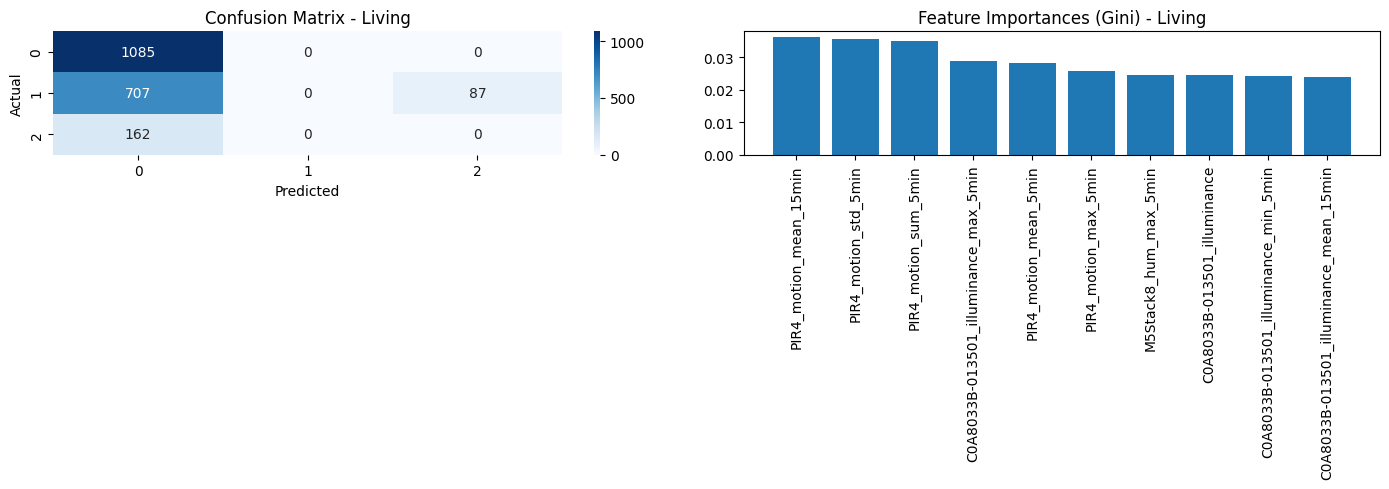

/tmp/ipython-input-1459121175.py:105: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dfi[f"{c}_std_5min"]   = dfi[c].rolling("5min",  min_periods=1).std().fillna(0)
/tmp/ipython-input-1459121175.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dfi[f"{c}_min_5min"]   = dfi[c].rolling("5min",  min_periods=1).min()
/tmp/ipython-input-1459121175.py:108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at


[Japanese (Washitu)] class dist
train: {0: 7188, 1: 1017, 2: 1319}
test : {0: 1271, 1: 543, 2: 227}

[ROOM] Japanese (Washitu)  Count(0/1/2)
[INFO] rows=13606 train=9524 test=2041 features=181
[INFO] feature sample: ['C0A80368-013001_setTemp', 'C0A80368-013001_roomTemp', 'C0A80368-013001_hum', 'C0A80368-013001_outsideTemp', 'C0A80368-013001_power', 'C0A80368-013001_totalPower', 'C0A80368-013001_flow', 'C0A80368-013001_human', 'C0A80368-013001_sunshine', 'C0A80368-013001_co2', 'C0A80341-013501_temp', 'C0A80341-013501_hum', 'C0A80341-013501_pm25', 'C0A80341-013501_gas', 'C0A80341-013501_illuminance']

★ Japanese (Washitu) TEST Accuracy: 0.6227
Confusion Matrix:
 [[1271    0    0]
 [ 543    0    0]
 [ 227    0    0]]
Report:
               precision    recall  f1-score   support

           0       0.62      1.00      0.77      1271
           1       0.00      0.00      0.00       543
           2       0.00      0.00      0.00       227

    accuracy                           0.62     

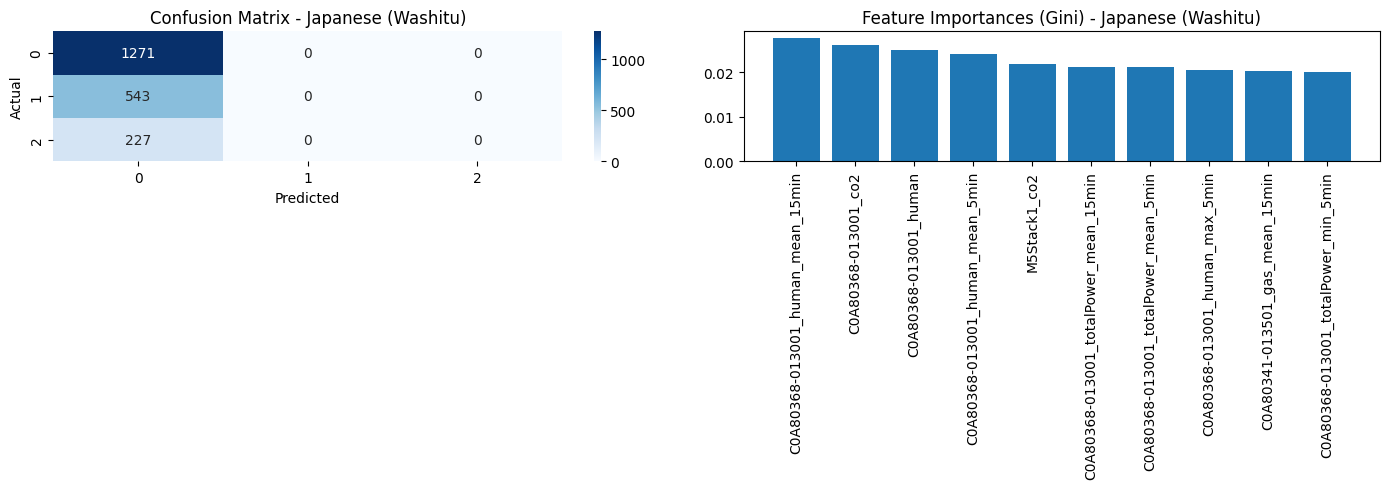


[DONE] finished.


In [ ]:
# ==============================================================================
# RandomForest 人数推定（Living / Japanese）
# - 対象部屋の家電・センサーだけを使用（他部屋のPIR混入を防ぐ）
# - 時系列特徴量（diff / rolling / PIR集計）を追加
# - train/test を時系列で分割（shuffleしない）
# - test（正解データ）は学習に使わない
# - 重要特徴量：Gini + Permutation importance を出力
# ==============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance

# ==============================================================================
# 0. 設定
# ==============================================================================
CSV_PATH = "smart_home_merged_all.csv"   # 必要ならパス変更

SEED = 42
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15          # 真ん中は val として隔離（今回は使わないが、test隔離を強める）
PERM_REPEAT = 5

RF_PARAMS = dict(
    n_estimators=800,
    random_state=SEED,
    n_jobs=-1,
    min_samples_leaf=2,
    class_weight="balanced_subsample",
)

ROOM_CFG = {
    "Living": {
        "label": "Label_Living_Count",
        "aircon_prefix": "C0A80367-013001_",
        "purifier_prefix": "C0A8033B-013501",
        "m5_prefixes": ["M5Stack2_", "M5Stack8_"],
        "pir_ids": [1, 2, 3, 4, 18],
    },
    "Japanese (Washitu)": {
        "label": "Label_Japanese_Count",
        "aircon_prefix": "C0A80368-013001_",
        "purifier_prefix": "C0A80341-013501",
        "m5_prefixes": ["M5Stack1_"],
        "pir_ids": [17, 21],
    }
}

# ==============================================================================
# 1. ユーティリティ
# ==============================================================================
def sanitize_df(df: pd.DataFrame) -> pd.DataFrame:
    """inf→NaN→補完。時系列で未来を見ないように ffill を基本にする"""
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.ffill()           # 未来を使わない
    df = df.fillna(0)
    return df.infer_objects(copy=False)

def prefix_cols(df: pd.DataFrame, prefix: str) -> list[str]:
    cols = [c for c in df.columns if c.startswith(prefix)]
    if len(cols) == 0:
        # 列名揺れの救済（ただし広げすぎないように注意）
        cols = [c for c in df.columns if prefix in c]
    return list(dict.fromkeys(cols))

def m5_cols(df: pd.DataFrame, prefixes: list[str]) -> list[str]:
    cols = []
    for p in prefixes:
        cols += [c for c in df.columns if c.startswith(p) or p in c]
    return list(dict.fromkeys(cols))

def exact_pir_cols(df: pd.DataFrame, pir_ids: list[int]) -> list[str]:
    """PIR1 が PIR13 に誤マッチしないように startswith で厳密に"""
    cols = []
    for pid in pir_ids:
        cols += [c for c in df.columns if c.startswith(f"PIR{pid}_") or c == f"PIR{pid}"]
    return list(dict.fromkeys(cols))

def add_time_features(df: pd.DataFrame, sensor_cols: list[str], pir_cols: list[str]) -> pd.DataFrame:
    """
    時系列特徴量を追加（過去のみ）
    - sensor: diff / rolling mean,std,min,max
    - pir: rolling sum/max
    """
    df = df.copy()
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    df = df.sort_values("timestamp").reset_index(drop=True)

    # diff
    for c in sensor_cols:
        if c in df.columns and pd.api.types.is_numeric_dtype(df[c]):
            df[f"{c}_diff"] = df[c].diff().fillna(0)

    # rolling（time-based）
    dfi = df.set_index("timestamp")
    for c in sensor_cols:
        if c in dfi.columns and pd.api.types.is_numeric_dtype(dfi[c]):
            dfi[f"{c}_mean_5min"]  = dfi[c].rolling("5min",  min_periods=1).mean()
            dfi[f"{c}_mean_15min"] = dfi[c].rolling("15min", min_periods=1).mean()
            dfi[f"{c}_std_5min"]   = dfi[c].rolling("5min",  min_periods=1).std().fillna(0)

            dfi[f"{c}_min_5min"]   = dfi[c].rolling("5min",  min_periods=1).min()
            dfi[f"{c}_max_5min"]   = dfi[c].rolling("5min",  min_periods=1).max()

    for c in pir_cols:
        if c in dfi.columns and pd.api.types.is_numeric_dtype(dfi[c]):
            dfi[f"{c}_sum_1min"] = dfi[c].rolling("1min", min_periods=1).sum()
            dfi[f"{c}_sum_5min"] = dfi[c].rolling("5min", min_periods=1).sum()
            dfi[f"{c}_max_5min"] = dfi[c].rolling("5min", min_periods=1).max()

    return dfi.reset_index()

def time_split_indices(N: int):
    """train(先頭70%) + val(次の15%) + test(最後15%)。test隔離を強める"""
    tr_end = int(N * TRAIN_RATIO)
    va_end = int(N * (TRAIN_RATIO + VAL_RATIO))
    idx_tr = np.arange(0, tr_end)
    idx_te = np.arange(va_end, N)
    return idx_tr, idx_te

def show_dist(name, y_tr, y_te):
    print(f"\n[{name}] class dist")
    print("train:", pd.Series(y_tr).value_counts().sort_index().to_dict())
    print("test :", pd.Series(y_te).value_counts().sort_index().to_dict())

# ==============================================================================
# 2. データ読み込み
# ==============================================================================
print("データを読み込んでいます...")
full_data = pd.read_csv(CSV_PATH, low_memory=False)

if "timestamp" not in full_data.columns:
    raise ValueError("timestamp列が必要です。CSVに timestamp がありません。")

full_data["timestamp"] = pd.to_datetime(full_data["timestamp"], errors="coerce")
full_data = full_data.sort_values("timestamp").reset_index(drop=True)

# 前処理
full_data = sanitize_df(full_data)

# ==============================================================================
# 3. 部屋ごとの学習（人数推定 0/1/2）
# ==============================================================================
for room_name, cfg in ROOM_CFG.items():
    target_col = cfg["label"]
    if target_col not in full_data.columns:
        print(f"\n[SKIP] {room_name}: {target_col} がありません。")
        continue

    # 0/1/2 のデータに限定
    dfr = full_data[full_data[target_col].isin([0, 1, 2])].copy().reset_index(drop=True)

    # 対象部屋の列だけ抽出（他部屋混入を遮断）
    base_cols = []
    base_cols += prefix_cols(dfr, cfg["aircon_prefix"])
    base_cols += prefix_cols(dfr, cfg["purifier_prefix"])
    base_cols += m5_cols(dfr, cfg["m5_prefixes"])
    base_cols += exact_pir_cols(dfr, cfg["pir_ids"])
    base_cols = list(dict.fromkeys(base_cols))

    keep_cols = ["timestamp", target_col] + base_cols
    keep_cols = [c for c in keep_cols if c in dfr.columns]
    dfr = dfr[keep_cols].copy()
    dfr = sanitize_df(dfr)

    # 特徴量候補（数値だけ）
    sensor_cols = [c for c in base_cols if pd.api.types.is_numeric_dtype(dfr[c])]
    pir_cols = exact_pir_cols(dfr, cfg["pir_ids"])

    # 時系列特徴量を追加
    dfr = add_time_features(dfr, sensor_cols=sensor_cols, pir_cols=pir_cols)
    dfr = sanitize_df(dfr)

    # 特徴量列（label/timestamp以外の数値）
    feature_cols = [
        c for c in dfr.columns
        if c not in ["timestamp", target_col]
        and pd.api.types.is_numeric_dtype(dfr[c])
    ]

    # 定数列を削除
    std = dfr[feature_cols].std(numeric_only=True)
    const_cols = std[std == 0].index.tolist()
    if const_cols:
        feature_cols = [c for c in feature_cols if c not in const_cols]

    # 入力/ラベル
    X = dfr[feature_cols].to_numpy(dtype=np.float32)
    X[~np.isfinite(X)] = 0.0
    y = dfr[target_col].astype(int).to_numpy()

    # 時系列split（testは最後の15%）
    idx_tr, idx_te = time_split_indices(len(dfr))
    X_tr, y_tr = X[idx_tr], y[idx_tr]
    X_te, y_te = X[idx_te], y[idx_te]

    # 分布確認
    show_dist(room_name, y_tr, y_te)

    print("\n" + "=" * 90)
    print(f"[ROOM] {room_name}  Count(0/1/2)")
    print(f"[INFO] rows={len(dfr)} train={len(idx_tr)} test={len(idx_te)} features={len(feature_cols)}")
    print(f"[INFO] feature sample: {feature_cols[:15]}")
    print("=" * 90)

    # 学習（✅ testは見ない）
    model = RandomForestClassifier(**RF_PARAMS)
    model.fit(X_tr, y_tr)

    # 評価
    y_pred = model.predict(X_te)
    acc = accuracy_score(y_te, y_pred)

    print(f"\n★ {room_name} TEST Accuracy: {acc:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_te, y_pred))
    print("Report:\n", classification_report(y_te, y_pred, zero_division=0))

    # 重要度：Gini
    gini = pd.DataFrame({
        "feature": feature_cols,
        "gini": model.feature_importances_
    }).sort_values("gini", ascending=False)

    print(f"\n[{room_name}] Gini importance Top15")
    print(gini.head(15).to_string(index=False))

    # 重要度：Permutation importance（testで評価として算出）
    perm = permutation_importance(
        model, X_te, y_te,
        n_repeats=PERM_REPEAT,
        random_state=SEED,
        n_jobs=-1,
        scoring="accuracy"
    )
    perm_df = pd.DataFrame({
        "feature": feature_cols,
        "drop_acc_mean": perm.importances_mean,
        "drop_acc_std": perm.importances_std
    }).sort_values("drop_acc_mean", ascending=False)

    print(f"\n[{room_name}] Permutation importance Top15 (on TEST)")
    print(perm_df.head(15).to_string(index=False))

    # 可視化（混同行列 + Top10重要度）
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_te, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {room_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    plt.subplot(1, 2, 2)
    topk = 10
    top = gini.head(topk)
    plt.title(f"Feature Importances (Gini) - {room_name}")
    plt.bar(range(topk), top["gini"].values, align="center")
    plt.xticks(range(topk), top["feature"].values, rotation=90)

    plt.tight_layout()
    plt.show()

print("\n[DONE] finished.")


In [ ]:
# ==============================================================================
# RandomForest 人数推定（Living / Japanese）
# 改善版:
# - ブロック単位の GroupShuffleSplit（リーク抑制 + 分布ズレ軽減）
# - 2段階推定: 在不在(0 vs >0) → 在のとき(1 vs 2)
# - rolling等の特徴量は dictでまとめてconcat（DataFrame fragmentation 回避）
# ==============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GroupShuffleSplit

# ==============================================================================
# 0. 設定
# ==============================================================================
CSV_PATH = "smart_home_merged_all.csv"  # ここだけ適宜変更

SEED = 42
BLOCK_MINUTES = 30          # 30分を1ブロックにして group split
TEST_RATIO = 0.20           # testブロック比率
PERM_REPEAT = 5

RF_OCC = dict(
    n_estimators=800,
    random_state=SEED,
    n_jobs=-1,
    class_weight="balanced_subsample",
    min_samples_leaf=2,
)

RF_CNT = dict(
    n_estimators=800,
    random_state=SEED,
    n_jobs=-1,
    class_weight="balanced_subsample",
    min_samples_leaf=2,
)

ROOM_CFG = {
    "Living": {
        "label": "Label_Living_Count",
        "aircon_prefix": "C0A80367-013001_",
        "purifier_prefix": "C0A8033B-013501",
        "m5_prefixes": ["M5Stack2_", "M5Stack8_"],
        "pir_ids": [1, 2, 3, 4, 18],
    },
    "Japanese (Washitu)": {
        "label": "Label_Japanese_Count",
        "aircon_prefix": "C0A80368-013001_",
        "purifier_prefix": "C0A80341-013501",
        "m5_prefixes": ["M5Stack1_"],
        "pir_ids": [17, 21],
    }
}

# ==============================================================================
# 1. ユーティリティ
# ==============================================================================
def sanitize_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.ffill()      # 未来を使わない
    df = df.fillna(0)
    return df.infer_objects(copy=False)

def prefix_cols(df: pd.DataFrame, prefix: str) -> list[str]:
    cols = [c for c in df.columns if c.startswith(prefix)]
    if len(cols) == 0:
        cols = [c for c in df.columns if prefix in c]
    return list(dict.fromkeys(cols))

def m5_cols(df: pd.DataFrame, prefixes: list[str]) -> list[str]:
    cols = []
    for p in prefixes:
        cols += [c for c in df.columns if c.startswith(p) or p in c]
    return list(dict.fromkeys(cols))

def exact_pir_cols(df: pd.DataFrame, pir_ids: list[int]) -> list[str]:
    cols = []
    for pid in pir_ids:
        cols += [c for c in df.columns if c.startswith(f"PIR{pid}_") or c == f"PIR{pid}"]
    return list(dict.fromkeys(cols))

def add_time_features_fast(df: pd.DataFrame, sensor_cols: list[str], pir_cols: list[str]) -> pd.DataFrame:
    """
    fragmentationを避けて高速に特徴量生成:
    - diff
    - rolling mean/std (5min, 15min)
    - PIR rolling sum/max
    """
    df = df.copy()
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    df = df.sort_values("timestamp").reset_index(drop=True)
    dfi = df.set_index("timestamp")

    feats = {}

    # sensor系
    for c in sensor_cols:
        if c in dfi.columns and pd.api.types.is_numeric_dtype(dfi[c]):
            s = dfi[c]
            feats[f"{c}_diff"] = s.diff().fillna(0)

            feats[f"{c}_mean_5min"]  = s.rolling("5min",  min_periods=1).mean()
            feats[f"{c}_mean_15min"] = s.rolling("15min", min_periods=1).mean()
            feats[f"{c}_std_5min"]   = s.rolling("5min",  min_periods=1).std().fillna(0)

            feats[f"{c}_min_5min"]   = s.rolling("5min",  min_periods=1).min()
            feats[f"{c}_max_5min"]   = s.rolling("5min",  min_periods=1).max()

    # PIR系（0/1が前提）
    for c in pir_cols:
        if c in dfi.columns and pd.api.types.is_numeric_dtype(dfi[c]):
            s = dfi[c]
            feats[f"{c}_sum_1min"] = s.rolling("1min", min_periods=1).sum()
            feats[f"{c}_sum_5min"] = s.rolling("5min", min_periods=1).sum()
            feats[f"{c}_max_5min"] = s.rolling("5min", min_periods=1).max()

    feat_df = pd.DataFrame(feats, index=dfi.index)
    out = pd.concat([dfi, feat_df], axis=1).reset_index()
    return out

def make_block_groups(ts: pd.Series, block_minutes: int) -> np.ndarray:
    """timestampから block_id を作る（30分=1ブロックなど）"""
    t0 = ts.min()
    minutes = (ts - t0).dt.total_seconds() / 60.0
    block = (minutes // block_minutes).astype(int)
    return block.to_numpy()

def eval_and_print(name, y_true, y_pred, labels):
    acc = accuracy_score(y_true, y_pred)
    print(f"\n★ {name} Accuracy: {acc:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred, labels=labels))
    print("Report:\n", classification_report(y_true, y_pred, labels=labels, zero_division=0))
    return acc

# ==============================================================================
# 2. データ読み込み
# ==============================================================================
print("データを読み込んでいます...")
full_data = pd.read_csv(CSV_PATH, low_memory=False)
if "timestamp" not in full_data.columns:
    raise ValueError("timestamp列が必要です。")

full_data["timestamp"] = pd.to_datetime(full_data["timestamp"], errors="coerce")
full_data = full_data.sort_values("timestamp").reset_index(drop=True)
full_data = sanitize_df(full_data)

# ==============================================================================
# 3. 部屋ごとの学習
# ==============================================================================
for room_name, cfg in ROOM_CFG.items():
    target_col = cfg["label"]
    if target_col not in full_data.columns:
        print(f"\n[SKIP] {room_name}: {target_col} がありません。")
        continue

    # 0/1/2 限定
    dfr = full_data[full_data[target_col].isin([0, 1, 2])].copy().reset_index(drop=True)

    # 対象部屋の列だけ抽出（他部屋混入を遮断）
    base_cols = []
    base_cols += prefix_cols(dfr, cfg["aircon_prefix"])
    base_cols += prefix_cols(dfr, cfg["purifier_prefix"])
    base_cols += m5_cols(dfr, cfg["m5_prefixes"])
    base_cols += exact_pir_cols(dfr, cfg["pir_ids"])
    base_cols = list(dict.fromkeys(base_cols))

    keep_cols = ["timestamp", target_col] + base_cols
    keep_cols = [c for c in keep_cols if c in dfr.columns]
    dfr = dfr[keep_cols].copy()
    dfr = sanitize_df(dfr)

    # 特徴量候補（数値だけ）
    sensor_cols = [c for c in base_cols if pd.api.types.is_numeric_dtype(dfr[c])]
    pir_cols = exact_pir_cols(dfr, cfg["pir_ids"])

    # 時系列特徴量追加（高速版）
    dfr = add_time_features_fast(dfr, sensor_cols=sensor_cols, pir_cols=pir_cols)
    dfr = sanitize_df(dfr)

    # feature列（timestamp,label以外の数値）
    feature_cols = [
        c for c in dfr.columns
        if c not in ["timestamp", target_col]
        and pd.api.types.is_numeric_dtype(dfr[c])
    ]

    # 定数列除去
    std = dfr[feature_cols].std(numeric_only=True)
    const_cols = std[std == 0].index.tolist()
    if const_cols:
        feature_cols = [c for c in feature_cols if c not in const_cols]

    # ===== ブロックGroupSplit =====
    groups = make_block_groups(dfr["timestamp"], BLOCK_MINUTES)
    gss = GroupShuffleSplit(n_splits=1, test_size=TEST_RATIO, random_state=SEED)
    tr_idx, te_idx = next(gss.split(dfr, dfr[target_col], groups=groups))

    X_tr = dfr.iloc[tr_idx][feature_cols].to_numpy(dtype=np.float32)
    y_tr = dfr.iloc[tr_idx][target_col].astype(int).to_numpy()

    X_te = dfr.iloc[te_idx][feature_cols].to_numpy(dtype=np.float32)
    y_te = dfr.iloc[te_idx][target_col].astype(int).to_numpy()

    X_tr[~np.isfinite(X_tr)] = 0.0
    X_te[~np.isfinite(X_te)] = 0.0

    print("\n" + "=" * 90)
    print(f"[ROOM] {room_name}")
    print(f"[INFO] rows={len(dfr)} train={len(tr_idx)} test={len(te_idx)} features={len(feature_cols)}")
    print(f"[INFO] class dist train={pd.Series(y_tr).value_counts().sort_index().to_dict()} "
          f"test={pd.Series(y_te).value_counts().sort_index().to_dict()}")
    print("=" * 90)

    # ==============================================================================
    # A) Step1: 在不在（0 vs >0）
    # ==============================================================================
    y_tr_occ = (y_tr > 0).astype(int)
    y_te_occ = (y_te > 0).astype(int)

    occ_model = RandomForestClassifier(**RF_OCC)
    occ_model.fit(X_tr, y_tr_occ)
    pred_occ = occ_model.predict(X_te)
    eval_and_print(f"{room_name} [Occupancy 0 vs >0]", y_te_occ, pred_occ, labels=[0, 1])

    # ==============================================================================
    # B) Step2: 在のときだけ（1 vs 2）
    # ==============================================================================
    tr_mask = y_tr > 0
    te_mask = y_te > 0

    X_tr_in = X_tr[tr_mask]
    y_tr_in = y_tr[tr_mask]    # 1/2
    X_te_in = X_te[te_mask]
    y_te_in = y_te[te_mask]    # 1/2

    if len(np.unique(y_tr_in)) < 2 or len(y_te_in) == 0:
        print(f"\n[WARN] {room_name}: 在(1/2)のデータが不足しているため Step2 をスキップ")
        continue

    cnt_model = RandomForestClassifier(**RF_CNT)
    cnt_model.fit(X_tr_in, y_tr_in)

    pred_in = cnt_model.predict(X_te_in)
    eval_and_print(f"{room_name} [Count | only occupied: 1 vs 2]", y_te_in, pred_in, labels=[1, 2])

    # ==============================================================================
    # C) 2段階統合（最終的に 0/1/2 を出す）
    # ==============================================================================
    final_pred = np.zeros_like(y_te)
    # 在と判定したところだけ Step2 の結果を入れる（ただし Step2 は “在の真値” mask ではなく “予測在” を使うのが本来）
    # ここではまず評価目的で「予測在」を使う
    pred_occ_mask = (pred_occ == 1)
    # Step2 推論: 予測在のサンプルだけに適用
    if pred_occ_mask.sum() > 0:
        pred_12 = cnt_model.predict(X_te[pred_occ_mask])
        final_pred[pred_occ_mask] = pred_12

    eval_and_print(f"{room_name} [Final 0/1/2 by 2-stage]", y_te, final_pred, labels=[0, 1, 2])

    # ==============================================================================
    # D) 重要度（Finalではなく、Countモデル(1/2)に対して出す方が解釈しやすい）
    # ==============================================================================
    gini = pd.DataFrame({
        "feature": feature_cols,
        "gini": occ_model.feature_importances_
    }).sort_values("gini", ascending=False)
    print(f"\n[{room_name}] Occupancy model Gini Top15")
    print(gini.head(15).to_string(index=False))

    # Permutation（予測が一定だと0になるので、まずは occupancy で見た方が良い）
    perm = permutation_importance(
        occ_model, X_te, y_te_occ,
        n_repeats=PERM_REPEAT,
        random_state=SEED,
        n_jobs=-1,
        scoring="accuracy"
    )
    perm_df = pd.DataFrame({
        "feature": feature_cols,
        "drop_acc_mean": perm.importances_mean,
        "drop_acc_std": perm.importances_std
    }).sort_values("drop_acc_mean", ascending=False)

    print(f"\n[{room_name}] Occupancy Permutation Top15 (on TEST)")
    print(perm_df.head(15).to_string(index=False))

print("\n[DONE] finished.")


データを読み込んでいます...


/tmp/ipython-input-2885263189.py:67: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.ffill()      # 未来を使わない



[ROOM] Living
[INFO] rows=13606 train=10576 test=3030 features=229
[INFO] class dist train={0: 6229, 1: 2149, 2: 2198} test={0: 2078, 1: 542, 2: 410}

★ Living [Occupancy 0 vs >0] Accuracy: 0.9776
Confusion Matrix:
 [[2024   54]
 [  14  938]]
Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      2078
           1       0.95      0.99      0.97       952

    accuracy                           0.98      3030
   macro avg       0.97      0.98      0.97      3030
weighted avg       0.98      0.98      0.98      3030


★ Living [Count | only occupied: 1 vs 2] Accuracy: 0.7847
Confusion Matrix:
 [[337 205]
 [  0 410]]
Report:
               precision    recall  f1-score   support

           1       1.00      0.62      0.77       542
           2       0.67      1.00      0.80       410

    accuracy                           0.78       952
   macro avg       0.83      0.81      0.78       952
weighted avg       0.86      0.78     

In [ ]:
# ==============================================================================
# Boosting (HistGradientBoosting / GradientBoosting) for
#  - Occupancy: 0 vs >0
#  - Count:     1 vs 2 (only occupied)
#  - Final:     0/1/2 by 2-stage
# Time-series split (no shuffling) to reduce leakage
# ==============================================================================

import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance

from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier

# -------------------------------
# Config
# -------------------------------
CSV_PATH = "smart_home_merged_all.csv"  # <- パスが違うならここだけ変える
TIME_COL = "timestamp"

ROOMS = {
    "Living": {
        "label_count": "Label_Living_Count",
        # リビング関連（エアコン/空気清浄機）
        "include_substrings": [
            "C0A80367-013001_",  # Living AC
            "C0A8033B-013501_",  # Living air purifier
            "M5Stack2", "M5Stack8",
            "PIR1", "PIR2", "PIR3", "PIR4", "PIR18",
        ],
    },
    "Japanese (Washitu)": {
        "label_count": "Label_Japanese_Count",
        "include_substrings": [
            "C0A80368-013001_",  # Washitu AC
            "C0A80341-013501_",  # Washitu air purifier
            "M5Stack1",
            "PIR17", "PIR21",
        ],
    }
}

TEST_RATIO = 0.25  # 時系列で後ろ25%をテストに
SEED = 42

# 2段階分類
#  Stage1: occupancy binary (0 vs >0)
#  Stage2: count among occupied (1 vs 2)  ※今は 0/1/2 の想定ならここだけ
COUNT_CLASSES = [0, 1, 2]

# -------------------------------
# Helpers
# -------------------------------

def load_csv(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    if TIME_COL in df.columns:
        df[TIME_COL] = pd.to_datetime(df[TIME_COL], errors="coerce")
        df = df.sort_values(TIME_COL).reset_index(drop=True)
    return df

def infer_and_clean_types(df: pd.DataFrame) -> pd.DataFrame:
    # object -> number/bool への推定をできるだけ進める
    df = df.copy()
    # True/False文字列などが混じってる可能性もあるので置換
    df.replace({"True": 1, "False": 0, True: 1, False: 0}, inplace=True)
    # 数値化できるものは数値化
    for c in df.columns:
        if c == TIME_COL:
            continue
        if df[c].dtype == "object":
            df[c] = pd.to_numeric(df[c], errors="ignore")
    df = df.infer_objects(copy=False)
    return df

def forward_fill_past_only(df: pd.DataFrame) -> pd.DataFrame:
    # 未来情報を使わない補完（ffillのみ）
    df = df.copy()
    df = df.ffill()
    # 残ったNaNは 0（センサー欠損扱い）
    df = df.fillna(0)
    return df

def time_split(df: pd.DataFrame, test_ratio=0.25):
    n = len(df)
    cut = int(n * (1 - test_ratio))
    train = df.iloc[:cut].copy()
    test  = df.iloc[cut:].copy()
    return train, test

def pick_feature_cols(df: pd.DataFrame, include_substrings: list, label_col: str):
    # 対象デバイス由来の列を拾う
    cols = []
    for c in df.columns:
        if c in [TIME_COL, label_col]:
            continue
        if any(s in c for s in include_substrings):
            cols.append(c)

    # 数値/booleanっぽいものだけ残す（とはいえ HGB は欠損も扱えるので緩めでOK）
    # ここでは object を一旦落とす
    ok = []
    for c in cols:
        if df[c].dtype == "object":
            continue
        ok.append(c)
    return ok

def add_time_features_block(df: pd.DataFrame, base_cols: list, windows=("5min", "15min")) -> pd.DataFrame:
    """
    時系列特徴:
      - rolling mean / std / min / max
      - 1min/5min sum for PIR motion (0/1)
    ※ DataFrame fragmentation回避のため、まとめてconcatする
    """
    dfi = df.copy()
    dfi = dfi.set_index(TIME_COL) if TIME_COL in dfi.columns else dfi

    new_cols = {}

    # rolling stats for numeric columns
    for c in base_cols:
        if c not in dfi.columns:
            continue
        if not np.issubdtype(dfi[c].dtype, np.number):
            continue

        # mean/std/min/max
        for w in windows:
            s = dfi[c].rolling(w, min_periods=1)
            new_cols[f"{c}_mean_{w}"] = s.mean()
            new_cols[f"{c}_std_{w}"]  = s.std().fillna(0)
        s5 = dfi[c].rolling("5min", min_periods=1)
        new_cols[f"{c}_min_5min"] = s5.min()
        new_cols[f"{c}_max_5min"] = s5.max()

        # PIRっぽい列は sum を追加（0/1想定）
        if "PIR" in c and ("motion" in c or "PIR" in c):
            s1 = dfi[c].rolling("1min", min_periods=1)
            new_cols[f"{c}_sum_1min"] = s1.sum()
            new_cols[f"{c}_sum_5min"] = s5.sum()

    feat_df = pd.DataFrame(new_cols, index=dfi.index)
    dfo = pd.concat([dfi, feat_df], axis=1)

    if TIME_COL in df.columns:
        dfo = dfo.reset_index()  # timestampを戻す
    return dfo

def drop_constant_columns(train_df: pd.DataFrame, test_df: pd.DataFrame, feature_cols: list):
    # train側で一定の列は落とす（重要）
    keep = []
    dropped = []
    for c in feature_cols:
        if c not in train_df.columns:
            continue
        if train_df[c].nunique(dropna=False) <= 1:
            dropped.append(c)
        else:
            keep.append(c)
    return keep, dropped

def train_eval_binary(model, X_train, y_train, X_test, y_test, title=""):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    acc = accuracy_score(y_test, pred)
    print(f"\n★ {title} Accuracy: {acc:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, pred))
    print("Report:\n", classification_report(y_test, pred, digits=3))
    return model, pred, acc

def train_eval_multiclass(model, X_train, y_train, X_test, y_test, title=""):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    acc = accuracy_score(y_test, pred)
    print(f"\n★ {title} Accuracy: {acc:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, pred))
    print("Report:\n", classification_report(y_test, pred, digits=3))
    return model, pred, acc

def show_importance(model, X_test, y_test, feature_names, topk=15, title=""):
    # HGB には feature_importances_ が無いので permutation を使うのが安全
    try:
        r = permutation_importance(model, X_test, y_test, n_repeats=5, random_state=SEED, n_jobs=-1)
        imp = pd.DataFrame({
            "feature": feature_names,
            "drop_acc_mean": r.importances_mean,
            "drop_acc_std": r.importances_std
        }).sort_values("drop_acc_mean", ascending=False).head(topk)

        print(f"\n[{title}] Permutation importance Top{topk} (on TEST)")
        print(imp.to_string(index=False))
    except Exception as e:
        print(f"[WARN] importance failed: {e}")

# -------------------------------
# Main
# -------------------------------

print("データを読み込んでいます...")
df = load_csv(CSV_PATH)
df = infer_and_clean_types(df)
df = forward_fill_past_only(df)

# timestamp が無い場合でも動くが、rollingは弱くなる
if TIME_COL not in df.columns:
    print("[WARN] timestamp列が無いので、rolling特徴量が正しく作れません。")
else:
    # 各ルームごとに “対象列だけ” rolling特徴を作る（軽くするため）
    # 先に全列rollingを作ると重い
    pass

# ---- モデル定義（Boosting）
def make_models():
    hgb = HistGradientBoostingClassifier(
        learning_rate=0.05,
        max_depth=6,
        max_iter=400,
        l2_regularization=1e-4,
        random_state=SEED
    )
    gbdt = GradientBoostingClassifier(
        learning_rate=0.05,
        max_depth=3,
        n_estimators=400,
        random_state=SEED
    )
    return {"HGB": hgb, "GBDT": gbdt}

models = make_models()

for room_name, cfg in ROOMS.items():
    label_col = cfg["label_count"]

    if label_col not in df.columns:
        print(f"\n[SKIP] {room_name}: {label_col} がありません")
        continue

    # --- 0/1/2以外が混じる場合に備えてフィルタ
    dfr = df[[TIME_COL] + [label_col] + [c for c in df.columns if c not in [TIME_COL, label_col]]].copy()
    dfr = dfr[dfr[label_col].isin(COUNT_CLASSES)].copy()

    # --- feature抽出（対象デバイス列だけ）
    base_feats = pick_feature_cols(dfr, cfg["include_substrings"], label_col=label_col)

    # --- rolling特徴を追加（部屋ごとに作る）
    if TIME_COL in dfr.columns:
        dfr = add_time_features_block(dfr, base_feats, windows=("5min", "15min"))

    # --- final feature list
    feat_cols = [c for c in dfr.columns if c not in [TIME_COL, label_col]]
    # ただし、対象サブストリングに関係ない列も増えるので、再フィルタ
    feat_cols = [c for c in feat_cols if any(s in c for s in cfg["include_substrings"])]

    # 型最終チェック
    dfr = infer_and_clean_types(dfr)
    dfr = forward_fill_past_only(dfr)

    # --- 時系列 split
    train_df, test_df = time_split(dfr, test_ratio=TEST_RATIO)

    # --- constant列はtrain基準で落とす
    feat_cols, dropped = drop_constant_columns(train_df, test_df, feat_cols)
    if len(dropped) > 0:
        print(f"\n[{room_name}] drop constant cols: {len(dropped)}")

    # --- X/y
    X_train = train_df[feat_cols]
    y_train = train_df[label_col].astype(int)

    X_test  = test_df[feat_cols]
    y_test  = test_df[label_col].astype(int)

    # --- 2段階用ラベル
    y_train_occ = (y_train > 0).astype(int)
    y_test_occ  = (y_test > 0).astype(int)

    # occupiedのみ（1/2）
    train_occ_mask = (y_train > 0)
    test_occ_mask  = (y_test > 0)

    X_train_occ = X_train.loc[train_occ_mask]
    y_train_12  = y_train.loc[train_occ_mask]   # 1 or 2
    X_test_occ  = X_test.loc[test_occ_mask]
    y_test_12   = y_test.loc[test_occ_mask]

    print("\n" + "="*90)
    print(f"[ROOM] {room_name}")
    print(f"[INFO] rows={len(dfr)} train={len(train_df)} test={len(test_df)} features={len(feat_cols)}")
    print(f"[INFO] class dist train={y_train.value_counts().to_dict()} test={y_test.value_counts().to_dict()}")
    print("="*90)

    for model_name, model_proto in models.items():
        print(f"\n--- {room_name} | {model_name} ---")

        # 1) Occupancy
        occ_model = model_proto.__class__(**model_proto.get_params())
        occ_model, pred_occ, acc_occ = train_eval_binary(
            occ_model, X_train, y_train_occ, X_test, y_test_occ,
            title=f"{room_name} [{model_name}] Occupancy 0 vs >0"
        )

        # 2) Count among occupied (1 vs 2)
        #   occupiedサンプルが無いケースはスキップ
        if len(X_test_occ) == 0 or len(X_train_occ) == 0:
            print(f"[SKIP] {room_name} {model_name}: occupiedデータが足りません")
            continue

        count_model = model_proto.__class__(**model_proto.get_params())
        count_model, pred_12, acc_12 = train_eval_multiclass(
            count_model, X_train_occ, y_train_12, X_test_occ, y_test_12,
            title=f"{room_name} [{model_name}] Count (1 vs 2) only occupied"
        )

        # 3) Final 0/1/2 (2-stage)
        final_pred = np.zeros(len(X_test), dtype=int)
        # occupancy=0 -> 0
        # occupancy=1 -> use count_model
        occ_is1 = (pred_occ == 1)
        if occ_is1.any():
            final_pred[occ_is1] = count_model.predict(X_test.loc[occ_is1])

        acc_final = accuracy_score(y_test, final_pred)
        print(f"\n★ {room_name} [{model_name}] Final 0/1/2 by 2-stage Accuracy: {acc_final:.4f}")
        print("Confusion Matrix:\n", confusion_matrix(y_test, final_pred))
        print("Report:\n", classification_report(y_test, final_pred, digits=3))

        # Importance（Permutation）
        show_importance(occ_model, X_test, y_test_occ, feat_cols, topk=15, title=f"{room_name}-{model_name}-Occupancy")
        # occupiedのみで importance
        show_importance(count_model, X_test_occ, y_test_12, feat_cols, topk=15, title=f"{room_name}-{model_name}-Count(1vs2)")

print("\n[DONE] finished.")


データを読み込んでいます...


/tmp/ipython-input-4092879836.py:58: DtypeWarning: Columns (15,44,173,183,186,196) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)
/tmp/ipython-input-4092879836.py:68: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({"True": 1, "False": 0, True: 1, False: 0}, inplace=True)
/tmp/ipython-input-4092879836.py:74: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[c] = pd.to_numeric(df[c], errors="ignore")
/tmp/ipython-input-4092879836.py:74: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitl


[Living] drop constant cols: 58

[ROOM] Living
[INFO] rows=13606 train=10204 test=3402 features=315
[INFO] class dist train={0: 6674, 2: 2147, 1: 1383} test={0: 1633, 1: 1308, 2: 461}

--- Living | HGB ---

★ Living [HGB] Occupancy 0 vs >0 Accuracy: 0.8989
Confusion Matrix:
 [[1616   17]
 [ 327 1442]]
Report:
               precision    recall  f1-score   support

           0      0.832     0.990     0.904      1633
           1      0.988     0.815     0.893      1769

    accuracy                          0.899      3402
   macro avg      0.910     0.902     0.899      3402
weighted avg      0.913     0.899     0.898      3402


★ Living [HGB] Count (1 vs 2) only occupied Accuracy: 0.2713
Confusion Matrix:
 [[  19 1289]
 [   0  461]]
Report:
               precision    recall  f1-score   support

           1      1.000     0.015     0.029      1308
           2      0.263     1.000     0.417       461

    accuracy                          0.271      1769
   macro avg      0.632  

/tmp/ipython-input-4092879836.py:74: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[c] = pd.to_numeric(df[c], errors="ignore")



[Japanese (Washitu)] drop constant cols: 37

[ROOM] Japanese (Washitu)
[INFO] rows=13606 train=10204 test=3402 features=219
[INFO] class dist train={0: 7868, 2: 1319, 1: 1017} test={0: 1967, 1: 1057, 2: 378}

--- Japanese (Washitu) | HGB ---

★ Japanese (Washitu) [HGB] Occupancy 0 vs >0 Accuracy: 0.6955
Confusion Matrix:
 [[1967    0]
 [1036  399]]
Report:
               precision    recall  f1-score   support

           0      0.655     1.000     0.792      1967
           1      1.000     0.278     0.435      1435

    accuracy                          0.695      3402
   macro avg      0.828     0.639     0.613      3402
weighted avg      0.801     0.695     0.641      3402


★ Japanese (Washitu) [HGB] Count (1 vs 2) only occupied Accuracy: 0.5519
Confusion Matrix:
 [[656 401]
 [242 136]]
Report:
               precision    recall  f1-score   support

           1      0.731     0.621     0.671      1057
           2      0.253     0.360     0.297       378

    accuracy           

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# ============================
# Config
# ============================
CSV_PATH = "./smart_home_merged_all.csv"
ROOM = "Living"     # "Japanese" に切替可
TARGET_COL = f"Label_{ROOM}_Count"
RANDOM_STATE = 42

# ============================
# Load
# ============================
print("📥 Loading CSV...")
df = pd.read_csv(CSV_PATH)

# timestamp
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values("timestamp")
df = df.set_index("timestamp")

# 欠損処理（未来を使わない）
df = df.ffill().infer_objects(copy=False)

# ============================
# 対象ラベル抽出（1 or 2 のみ）
# ============================
df = df[df[TARGET_COL].isin([1, 2])].copy()
df["y"] = df[TARGET_COL].astype(int)

print("class dist:")
print(df["y"].value_counts().sort_index())

# ============================
# CO2 カラム抽出（illuminance除外）
# ============================
co2_cols = [
    c for c in df.columns
    if ("co2" in c.lower())
]

print(f"CO2 cols ({len(co2_cols)}):")
for c in co2_cols:
    print(" ", c)

# ============================
# Feature Engineering (CO2 only)
# ============================
print("⚙️ Building CO2 features...")

feats = {}

for c in co2_cols:
    s = df[c]

    feats[c] = s
    feats[f"{c}_diff"] = s.diff()
    feats[f"{c}_diff_mean_5min"] = s.diff().rolling("5min", min_periods=1).mean()
    feats[f"{c}_integral_15min"] = s.rolling("15min", min_periods=1).sum()

    # slope (10min linear regression)
    def slope(x):
        if len(x) < 3:
            return 0.0
        t = np.arange(len(x))
        return np.polyfit(t, x, 1)[0]

    feats[f"{c}_slope_10min"] = s.rolling("10min", min_periods=3).apply(slope, raw=True)

X = pd.DataFrame(feats, index=df.index)
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

y = df["y"]

print("feature shape:", X.shape)

# ============================
# Train / Test Split（時系列分割）
# ============================
N = len(X)
split = int(N * 0.7)

X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

print(f"train={len(X_train)} test={len(X_test)}")

# ============================
# RandomForest
# ============================
print("🌲 Training RandomForest...")

model = RandomForestClassifier(
    n_estimators=400,
    max_depth=12,
    min_samples_leaf=5,
    class_weight="balanced",
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

model.fit(X_train, y_train)

# ============================
# Evaluation
# ============================
print("\n📊 Evaluation")

y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy:", acc)
print("Confusion Matrix:\n", cm)
print("Report:\n", classification_report(y_test, y_pred))

# ============================
# Feature Importance
# ============================
imp = pd.DataFrame({
    "feature": X.columns,
    "gini": model.feature_importances_
}).sort_values("gini", ascending=False)

print("\n🔥 Top20 Important Features")
print(imp.head(20))


📥 Loading CSV...


/tmp/ipython-input-636219690.py:19: DtypeWarning: Columns (15,44,173,183,186,196) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(CSV_PATH)
/tmp/ipython-input-636219690.py:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.ffill().infer_objects(copy=False)


class dist:
y
1    2691
2    2608
Name: count, dtype: int64
CO2 cols (10):
  M5Stack1_co2
  M5Stack2_co2
  M5Stack3_co2
  M5Stack4_co2
  M5Stack5_co2
  M5Stack6_co2
  M5Stack8_co2
  M5Stack10_co2
  C0A80367-013001_co2
  C0A80368-013001_co2
⚙️ Building CO2 features...
feature shape: (5299, 50)
train=3709 test=1590
🌲 Training RandomForest...

📊 Evaluation
Accuracy: 0.7264150943396226
Confusion Matrix:
 [[742 387]
 [ 48 413]]
Report:
               precision    recall  f1-score   support

           1       0.94      0.66      0.77      1129
           2       0.52      0.90      0.66       461

    accuracy                           0.73      1590
   macro avg       0.73      0.78      0.71      1590
weighted avg       0.82      0.73      0.74      1590


🔥 Top20 Important Features
                               feature      gini
40                 C0A80367-013001_co2  0.118249
5                         M5Stack2_co2  0.077557
30                        M5Stack8_co2  0.071496
43  C0A80367-

📥 Loading CSV...


/tmp/ipython-input-1300367617.py:52: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.ffill().infer_objects(copy=False)
/tmp/ipython-input-1300367617.py:87: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data_1, data_2], labels=["1 person", "2 people"], showfliers=True)
/tmp/ipython-input-1300367617.py:87: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data_1, data_2], labels=["1 person", "2 people"], showfliers=True)


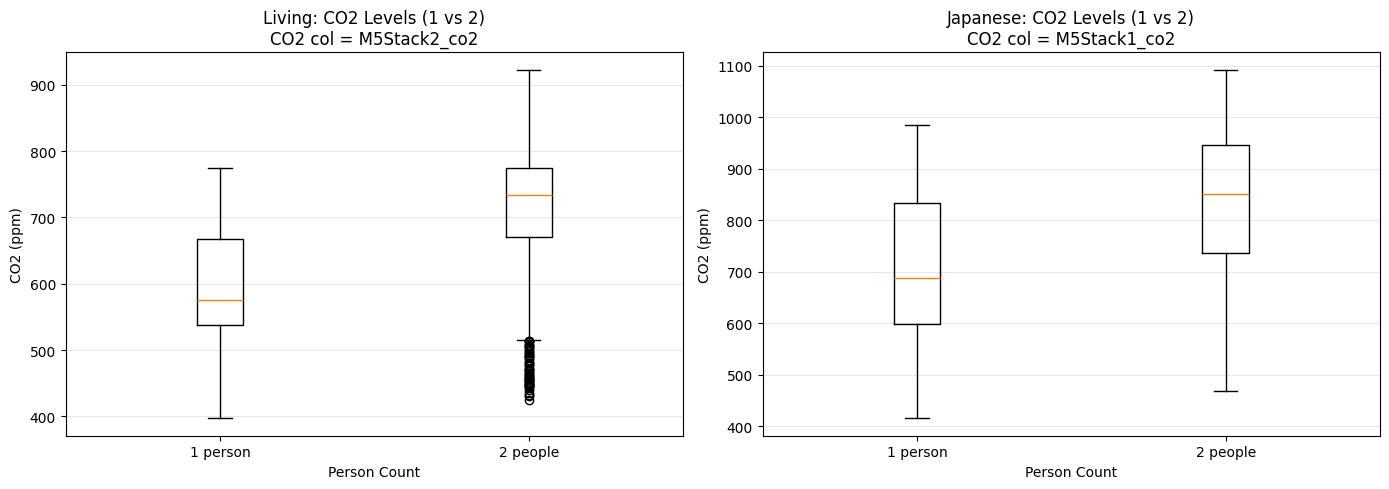

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =========================
# 設定
# =========================
CSV_PATH = "smart_home_merged_all.csv"

ROOMS = {
    "Living": {
        "label_col": "Label_Living_Count",
        # ここに「この部屋のCO2として使いたい列名」を優先順で入れる（存在すれば優先採用）
        "co2_priority": ["M5Stack2_co2", "M5Stack8_co2", "C0A80367-013001_co2"],
    },
    "Japanese": {
        "label_col": "Label_Japanese_Count",
        "co2_priority": ["M5Stack1_co2", "C0A80368-013001_co2", "C0A80341-013501_co2"],
    }
}

# =========================
# 便利関数
# =========================
def find_co2_col(df, priority_list):
    """priority_listにある列があればそれを採用。なければ *_co2 を自動探索して返す。"""
    for c in priority_list:
        if c in df.columns:
            return c
    # fallback: 自動検出
    co2_cols = [c for c in df.columns if ("co2" in c.lower())]
    # なるべく末尾が _co2 のものを優先
    co2_cols2 = [c for c in co2_cols if c.lower().endswith("_co2")]
    return co2_cols2[0] if co2_cols2 else (co2_cols[0] if co2_cols else None)

def clean_numeric(series):
    """混在型を安全に数値へ（失敗はNaN）"""
    return pd.to_numeric(series, errors="coerce")

# =========================
# 読み込み
# =========================
print("📥 Loading CSV...")
df = pd.read_csv(CSV_PATH, low_memory=False)

# timestamp があれば時系列ソート（任意）
if "timestamp" in df.columns:
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    df = df.sort_values("timestamp")

# 前処理（必要最低限）
df = df.ffill().infer_objects(copy=False)

# =========================
# 箱ひげ図（1人 vs 2人）
# =========================
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

for ax, (room_name, cfg) in zip(axes, ROOMS.items()):
    label_col = cfg["label_col"]
    if label_col not in df.columns:
        ax.set_title(f"{room_name} (missing label: {label_col})")
        ax.axis("off")
        continue

    co2_col = find_co2_col(df, cfg["co2_priority"])
    if co2_col is None:
        ax.set_title(f"{room_name} (CO2 column not found)")
        ax.axis("off")
        continue

    # 1人/2人だけ抽出
    dfi = df[[label_col, co2_col]].copy()
    dfi[label_col] = clean_numeric(dfi[label_col])
    dfi[co2_col] = clean_numeric(dfi[co2_col])
    dfi = dfi.dropna()

    dfi = dfi[dfi[label_col].isin([1, 2])]

    # 外れ値が気になるならここで範囲制限（任意）
    # dfi = dfi[(dfi[co2_col] >= 350) & (dfi[co2_col] <= 3000)]

    # 箱ひげ用にクラス別配列へ
    data_1 = dfi.loc[dfi[label_col] == 1, co2_col].values
    data_2 = dfi.loc[dfi[label_col] == 2, co2_col].values

    ax.boxplot([data_1, data_2], labels=["1 person", "2 people"], showfliers=True)
    ax.set_title(f"{room_name}: CO2 Levels (1 vs 2)\nCO2 col = {co2_col}")
    ax.set_xlabel("Person Count")
    ax.set_ylabel("CO2 (ppm)")
    ax.grid(True, axis="y", alpha=0.3)

plt.tight_layout()
plt.show()


In [1]:
!pip install lightgbm

📥 Loading CSV...


/tmp/ipython-input-3695964510.py:31: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.to_datetime(series, errors="coerce", infer_datetime_format=True)
/tmp/ipython-input-3695964510.py:66: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return df.ffill().infer_objects(copy=False)



[ROOM] Living
[INFO] rows=13682 train=10945 test=2737 features=132
[INFO] label=Label_Living_Count
[INFO] co2_cols=9 human_cols=20
[INFO] class dist (count) train={0: 10357, 2: 355, 1: 233} test={0: 2442, 1: 218, 2: 77}
[LightGBM] [Info] Number of positive: 588, number of negative: 10357
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.264955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17523
[LightGBM] [Info] Number of data points in the train set: 10945, number of used features: 103
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

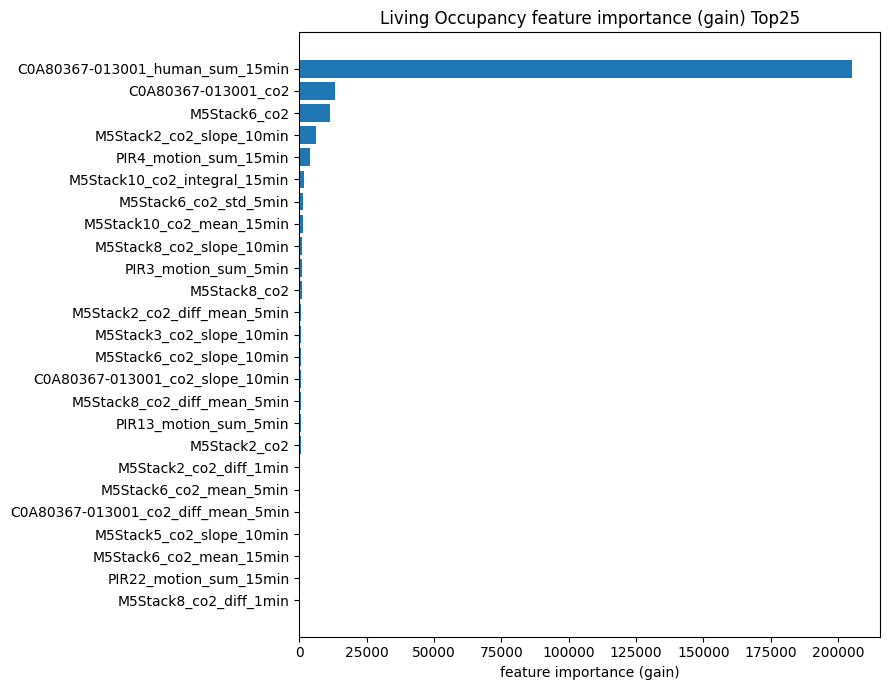

[LightGBM] [Info] Number of positive: 355, number of negative: 233
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12930
[LightGBM] [Info] Number of data points in the train set: 588, number of used features: 96
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

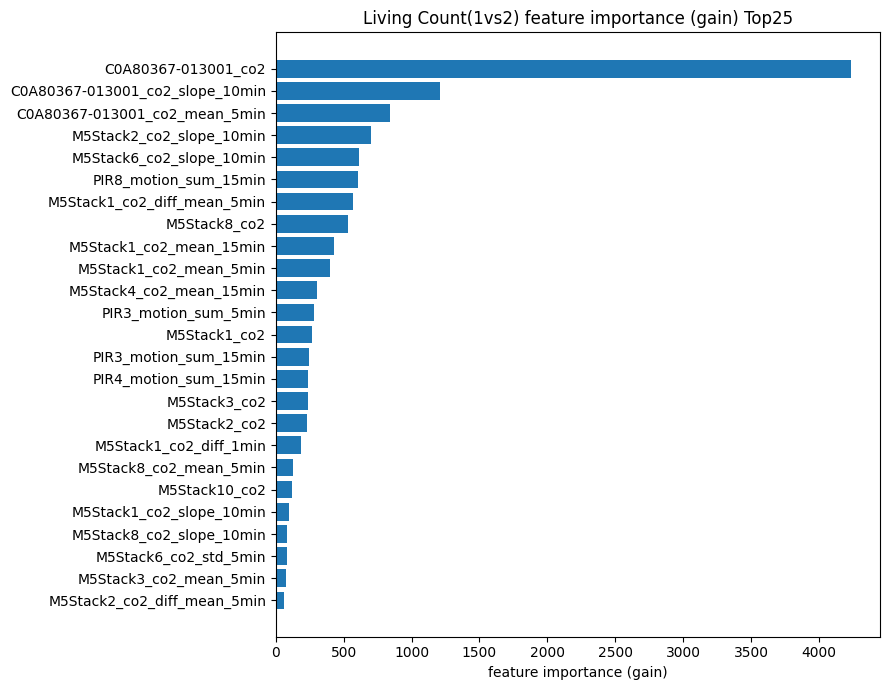


★ Living [Final 0/1/2 by 2-stage] Accuracy: 0.9602
Confusion Matrix:
 [[2411   30    1]
 [  10  145   63]
 [   0    5   72]]
Report:
               precision    recall  f1-score   support

           0      0.996     0.987     0.992      2442
           1      0.806     0.665     0.729       218
           2      0.529     0.935     0.676        77

    accuracy                          0.960      2737
   macro avg      0.777     0.863     0.799      2737
weighted avg      0.968     0.960     0.962      2737


[ROOM] Japanese
[INFO] rows=13682 train=10945 test=2737 features=132
[INFO] label=Label_Japanese_Count
[INFO] co2_cols=9 human_cols=20
[INFO] class dist (count) train={0: 10554, 2: 220, 1: 171} test={0: 2498, 1: 176, 2: 63}
[LightGBM] [Info] Number of positive: 391, number of negative: 10554
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005173 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

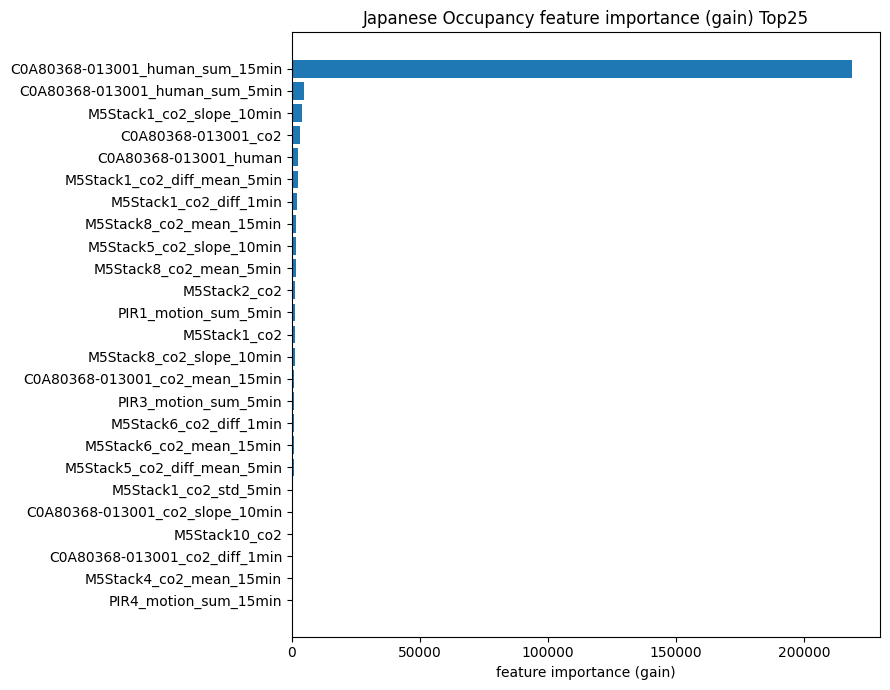

[LightGBM] [Info] Number of positive: 220, number of negative: 171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8630
[LightGBM] [Info] Number of data points in the train set: 391, number of used features: 91
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

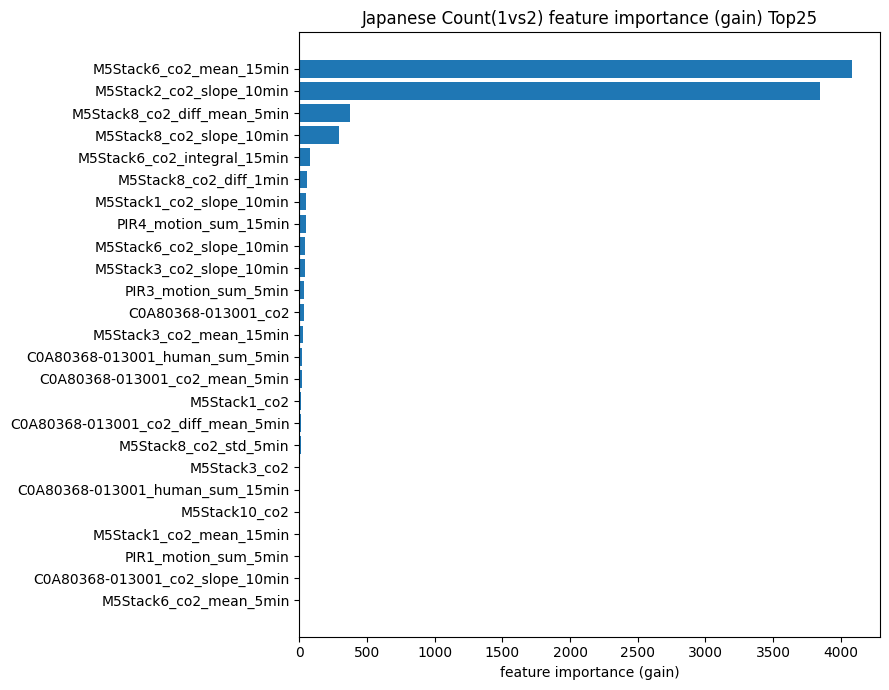


★ Japanese [Final 0/1/2 by 2-stage] Accuracy: 0.9719
Confusion Matrix:
 [[2474   24    0]
 [  11  160    5]
 [   0   37   26]]
Report:
               precision    recall  f1-score   support

           0      0.996     0.990     0.993      2498
           1      0.724     0.909     0.806       176
           2      0.839     0.413     0.553        63

    accuracy                          0.972      2737
   macro avg      0.853     0.771     0.784      2737
weighted avg      0.974     0.972     0.971      2737



In [3]:
# ============================================================
# LightGBM: 2段モデル（在不在 0vs>0 → 在室のみ 1vs2）
# Living / Japanese（和室）それぞれ
# feature importance（gain）を図で描画
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from lightgbm import LGBMClassifier


# =========================
# 設定
# =========================
CSV_PATH = "./smart_home_merged_all.csv"

TIME_COL = "timestamp"     # 必要なら修正
RESAMPLE_RULE = "1min"     # 1分に揃えてCO2変化率を安定化
TRAIN_RATIO = 0.80         # 時系列 split
RANDOM_STATE = 42
TOPK_IMPORTANCE = 25


# =========================
# Utility
# =========================
def to_dt(series: pd.Series) -> pd.Series:
    return pd.to_datetime(series, errors="coerce", infer_datetime_format=True)

def time_split(df: pd.DataFrame, train_ratio: float):
    n = len(df)
    n_tr = int(n * train_ratio)
    tr_idx = np.arange(0, n_tr)
    te_idx = np.arange(n_tr, n)
    return tr_idx, te_idx

def eval_print(title: str, y_true, y_pred, labels=None):
    print(f"\n★ {title} Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred, labels=labels))
    print("Report:\n", classification_report(y_true, y_pred, digits=3))

def plot_feature_importance(model: LGBMClassifier, feature_names, title: str, topk: int = 25):
    booster = model.booster_
    gains = booster.feature_importance(importance_type="gain")
    s = pd.Series(gains, index=feature_names).sort_values(ascending=False).head(topk)
    s = s[::-1]  # barh用に反転

    plt.figure(figsize=(9, max(4, 0.28 * len(s))))
    plt.barh(s.index, s.values)
    plt.title(title)
    plt.xlabel("feature importance (gain)")
    plt.tight_layout()
    plt.show()

def coerce_boolish_to_float(s: pd.Series) -> pd.Series:
    # True/False, "True"/"False", 0/1 などを吸収
    s = s.replace({"True": 1, "False": 0, True: 1, False: 0})
    s = pd.to_numeric(s, errors="coerce")
    return s.astype(float)

def safe_ffill(df: pd.DataFrame) -> pd.DataFrame:
    # 未来を使わない：ffillのみ（bfillしない）
    return df.ffill().infer_objects(copy=False)

def resample_1min(df: pd.DataFrame, rule="1min") -> pd.DataFrame:
    # 数値は平均、カテゴリ/文字は最後の値
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    other_cols = [c for c in df.columns if c not in num_cols]

    out = []
    if num_cols:
        out.append(df[num_cols].resample(rule).mean())
    if other_cols:
        out.append(df[other_cols].resample(rule).last())

    dfr = pd.concat(out, axis=1).sort_index()
    dfr = safe_ffill(dfr)
    return dfr

def build_co2_features(df: pd.DataFrame, co2_cols: list[str]) -> pd.DataFrame:
    feats = {}
    for c in co2_cols:
        s = pd.to_numeric(df[c], errors="coerce").astype(float)

        feats[c] = s
        feats[f"{c}_diff_1min"] = s.diff()
        feats[f"{c}_diff_mean_5min"] = s - s.rolling(5, min_periods=1).mean()
        feats[f"{c}_slope_10min"] = (s - s.shift(10)) / 10.0  # ppm/min
        feats[f"{c}_mean_5min"] = s.rolling(5, min_periods=1).mean()
        feats[f"{c}_mean_15min"] = s.rolling(15, min_periods=1).mean()
        feats[f"{c}_std_5min"] = s.rolling(5, min_periods=1).std().fillna(0.0)
        feats[f"{c}_integral_15min"] = s.rolling(15, min_periods=1).sum()  # ppm*min

    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.ffill().fillna(0.0)
    return X

def build_human_features(df: pd.DataFrame, human_cols: list[str]) -> pd.DataFrame:
    feats = {}
    for c in human_cols:
        s = coerce_boolish_to_float(df[c])
        s = s.ffill().fillna(0.0)

        feats[c] = s
        feats[f"{c}_sum_5min"] = s.rolling(5, min_periods=1).sum()
        feats[f"{c}_sum_15min"] = s.rolling(15, min_periods=1).sum()

    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    return X


# =========================
# 部屋ごとの列選択
# （照度は入れない方針。CO2 + human中心）
# =========================
def pick_room_columns(df: pd.DataFrame, room: str):
    if room == "Living":
        label_count = "Label_Living_Count"
        # 明示されたエアコンCO2
        base_co2 = ["C0A80367-013001_co2"]
        # M5StackのCO2も使う（Livingに関係しそうなものを広めに拾う）
        m5_co2 = [c for c in df.columns if c.startswith("M5Stack") and c.endswith("_co2")]
        co2_cols = [c for c in (base_co2 + m5_co2) if c in df.columns]

        # 明示されたエアコン人感 + PIR系（あれば）
        human_cols = []
        if "C0A80367-013001_human" in df.columns:
            human_cols.append("C0A80367-013001_human")
        human_cols += [c for c in df.columns if ("PIR" in c and ("motion" in c or "human" in c))]

    elif room == "Japanese":
        label_count = "Label_Japanese_Count"
        # 和室側のエアコンIDは質問の途中で途切れているので、C0A80368-013001_* を広く拾う
        base_co2 = [c for c in df.columns if c.startswith("C0A80368-013001") and c.endswith("_co2")]
        # M5Stack CO2も追加
        m5_co2 = [c for c in df.columns if c.startswith("M5Stack") and c.endswith("_co2")]
        co2_cols = list(dict.fromkeys(base_co2 + m5_co2))  # 重複除去

        human_cols = []
        # C0A80368-013001_human があるなら使う
        if "C0A80368-013001_human" in df.columns:
            human_cols.append("C0A80368-013001_human")
        human_cols += [c for c in df.columns if ("PIR" in c and ("motion" in c or "human" in c))]

    else:
        raise ValueError("room must be Living or Japanese")

    # 最低限 CO2 は必要
    co2_cols = [c for c in co2_cols if c in df.columns]
    human_cols = [c for c in human_cols if c in df.columns]

    return label_count, co2_cols, human_cols


# =========================
# 2段モデル学習
# =========================
def run_room(df: pd.DataFrame, room: str):
    label_count, co2_cols, human_cols = pick_room_columns(df, room)

    if label_count not in df.columns:
        print(f"[SKIP] {room}: {label_count} がありません")
        return

    # ラベルの整形（0/1/2のみ）
    y_count = pd.to_numeric(df[label_count], errors="coerce")
    y_count = y_count.where(y_count.isin([0, 1, 2]), np.nan)
    y_count = y_count.ffill().fillna(0).astype(int)

    y_occ = (y_count > 0).astype(int)

    # 特徴量
    X_co2 = build_co2_features(df, co2_cols)
    X_human = build_human_features(df, human_cols) if len(human_cols) > 0 else pd.DataFrame(index=df.index)
    X = pd.concat([X_co2, X_human], axis=1)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)

    # 時系列 split（未来を見ない）
    tr_idx, te_idx = time_split(df, TRAIN_RATIO)

    X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
    y_occ_tr, y_occ_te = y_occ.iloc[tr_idx], y_occ.iloc[te_idx]
    y_count_tr, y_count_te = y_count.iloc[tr_idx], y_count.iloc[te_idx]

    print("\n" + "=" * 100)
    print(f"[ROOM] {room}")
    print(f"[INFO] rows={len(df)} train={len(tr_idx)} test={len(te_idx)} features={X.shape[1]}")
    print(f"[INFO] label={label_count}")
    print(f"[INFO] co2_cols={len(co2_cols)} human_cols={len(human_cols)}")
    print(f"[INFO] class dist (count) train={y_count_tr.value_counts().to_dict()} test={y_count_te.value_counts().to_dict()}")
    print("=" * 100)

    # -----------------------------
    # Stage1: 在不在（0 vs >0）
    # -----------------------------
    occ_model = LGBMClassifier(
        n_estimators=800,
        learning_rate=0.03,
        num_leaves=63,
        max_depth=-1,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=RANDOM_STATE,
        class_weight="balanced",
        n_jobs=-1
    )

    occ_model.fit(X_tr, y_occ_tr)

    y_occ_pred = occ_model.predict(X_te)
    eval_print(f"{room} [Occupancy 0 vs >0]", y_occ_te, y_occ_pred, labels=[0,1])
    plot_feature_importance(occ_model, X.columns, f"{room} Occupancy feature importance (gain) Top{TOPK_IMPORTANCE}", TOPK_IMPORTANCE)

    # -----------------------------
    # Stage2: 1 vs 2（在室のみ）
    #   - train/test それぞれで countが1or2の行だけを使用
    # -----------------------------
    tr_occ_mask = y_count_tr.isin([1,2])
    te_occ_mask = y_count_te.isin([1,2])

    X_tr_12 = X_tr.loc[tr_occ_mask]
    y_tr_12 = y_count_tr.loc[tr_occ_mask]
    X_te_12 = X_te.loc[te_occ_mask]
    y_te_12 = y_count_te.loc[te_occ_mask]

    if len(X_tr_12) == 0 or len(X_te_12) == 0:
        print(f"[WARN] {room}: 1/2データが不足しているため Stage2 をスキップします")
        return

    cnt_model = LGBMClassifier(
        n_estimators=1200,
        learning_rate=0.03,
        num_leaves=63,
        max_depth=-1,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=RANDOM_STATE,
        class_weight="balanced",
        n_jobs=-1
    )

    cnt_model.fit(X_tr_12, y_tr_12)

    y_12_pred = cnt_model.predict(X_te_12)
    eval_print(f"{room} [Count | only occupied: 1 vs 2]", y_te_12, y_12_pred, labels=[1,2])
    plot_feature_importance(cnt_model, X.columns, f"{room} Count(1vs2) feature importance (gain) Top{TOPK_IMPORTANCE}", TOPK_IMPORTANCE)

    # -----------------------------
    # 2段で最終 0/1/2 を作る（test全体）
    # -----------------------------
    final_pred = np.zeros(len(X_te), dtype=int)

    # stage1 で在室と判定されたところだけ stage2 を適用（ただし、stage2は1or2しか出せない）
    occ_pred_mask = (y_occ_pred == 1)

    if occ_pred_mask.any():
        final_pred[occ_pred_mask] = cnt_model.predict(X_te.iloc[occ_pred_mask])

    eval_print(f"{room} [Final 0/1/2 by 2-stage]", y_count_te, final_pred, labels=[0,1,2])


# =========================
# Main
# =========================
print("📥 Loading CSV...")
df0 = pd.read_csv(CSV_PATH, low_memory=False)

if TIME_COL not in df0.columns:
    raise ValueError(f"CSVに {TIME_COL} 列がありません。TIME_COLを修正してください。")

df0[TIME_COL] = to_dt(df0[TIME_COL])
df0 = df0.dropna(subset=[TIME_COL]).sort_values(TIME_COL).set_index(TIME_COL)

# 未来を見ない前処理：ffillのみ
df0 = safe_ffill(df0)

# 1分に揃える（CO2派生が安定しやすい）
df = resample_1min(df0, RESAMPLE_RULE)

# 実行（Living / Japanese）
run_room(df, "Living")
run_room(df, "Japanese")


/tmp/ipython-input-1409125047.py:72: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.ffill().infer_objects(copy=False)


Loaded: (13606, 199)

[ROOM] Living | target=Label_Living_Count | rows=13606
Features: full=197 ablated(noCO2+noHuman)=185

[Living][Occupancy(0 vs >0)] class dist train={0: 6830, 1: 4055} test={0: 1477, 1: 1244}
[LightGBM] [Info] Number of positive: 4055, number of negative: 6830
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005199 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11382
[LightGBM] [Info] Number of data points in the train set: 10885, number of used features: 128
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

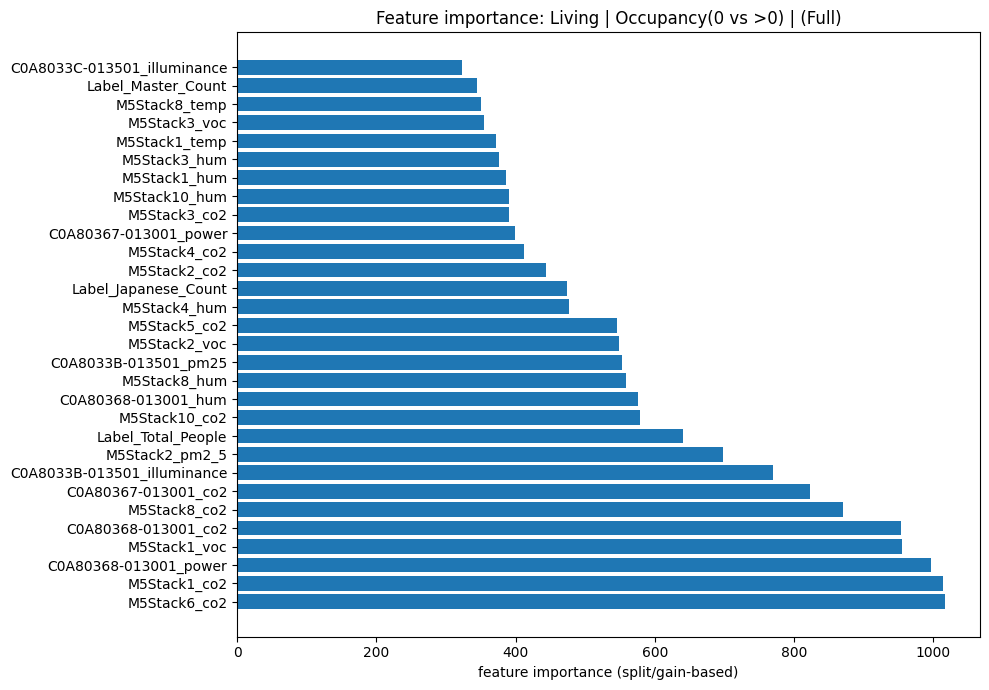


[Living][Occupancy(0 vs >0)] class dist train={0: 6830, 1: 4055} test={0: 1477, 1: 1244}
[LightGBM] [Info] Number of positive: 4055, number of negative: 6830
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9129
[LightGBM] [Info] Number of data points in the train set: 10885, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

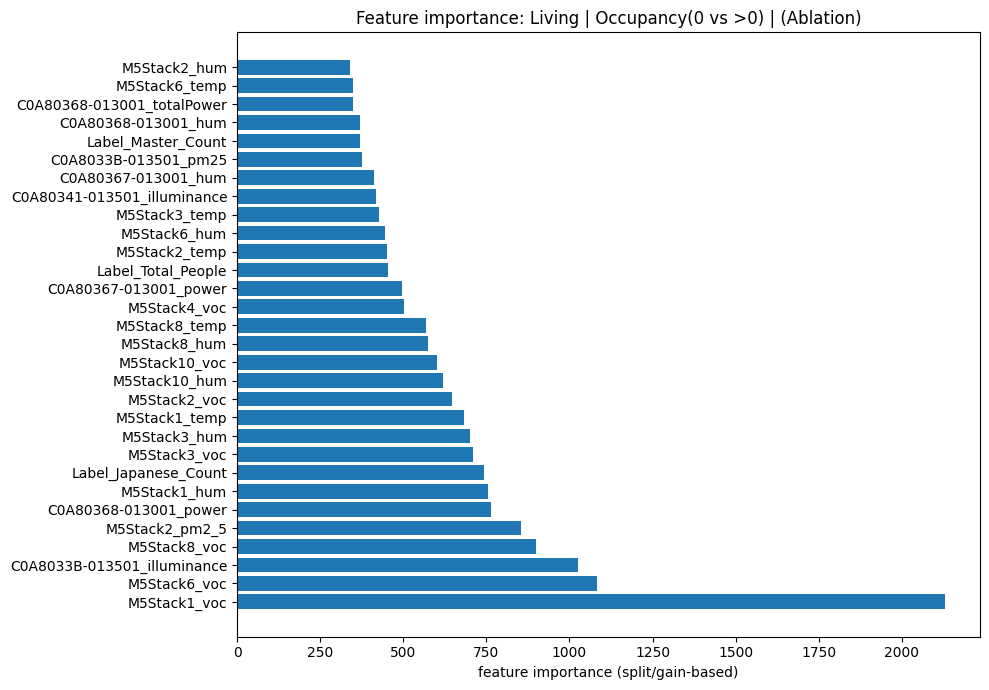


[SUMMARY][Living][Occupancy] Full acc=0.6681 | Ablation acc=1.0000 | drop=-0.3319

[Living][Count(1 vs 2 | occupied only)] class dist train={2: 2446, 1: 1794} test={1: 897, 2: 162}
[LightGBM] [Info] Number of positive: 2446, number of negative: 1794
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10275
[LightGBM] [Info] Number of data points in the train set: 4240, number of used features: 119
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

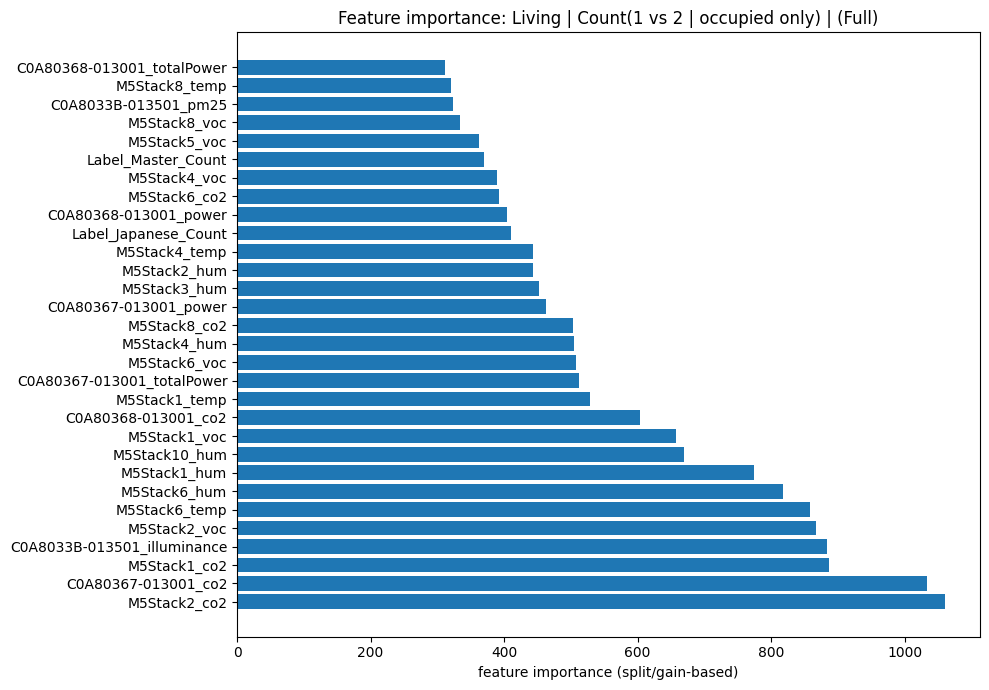


[Living][Count(1 vs 2 | occupied only)] class dist train={2: 2446, 1: 1794} test={1: 897, 2: 162}
[LightGBM] [Info] Number of positive: 2446, number of negative: 1794
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8282
[LightGBM] [Info] Number of data points in the train set: 4240, number of used features: 107
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

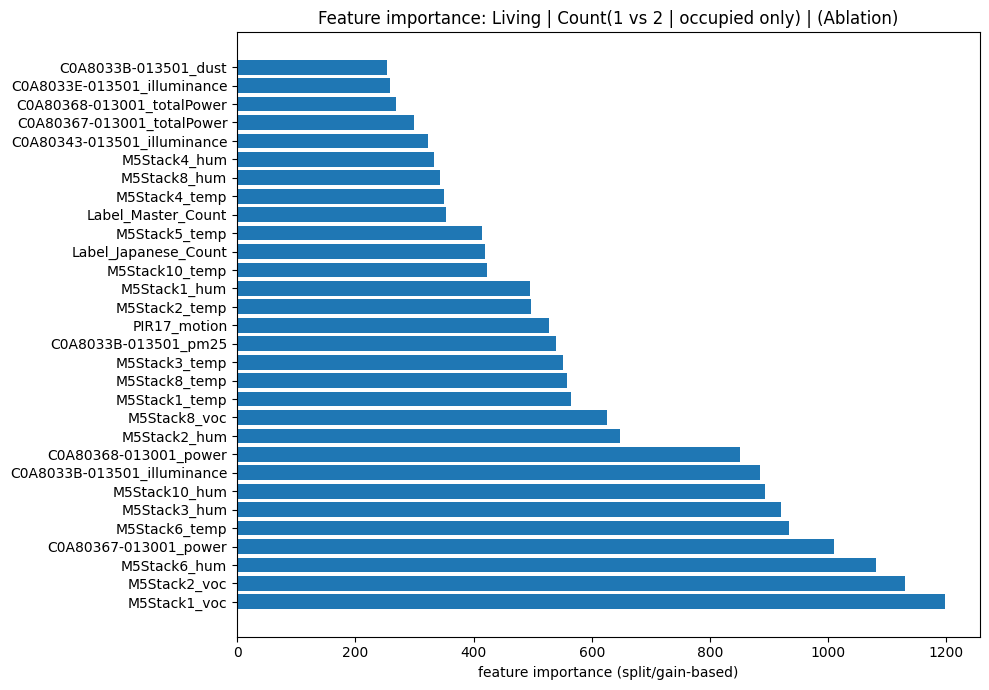


[SUMMARY][Living][1vs2] Full acc=0.7630 | Ablation acc=0.7630 | drop=+0.0000

[ROOM] Japanese | target=Label_Japanese_Count | rows=13606
Features: full=197 ablated(noCO2+noHuman)=185

[Japanese][Occupancy(0 vs >0)] class dist train={0: 8323, 1: 2562} test={0: 1512, 1: 1209}
[LightGBM] [Info] Number of positive: 2562, number of negative: 8323
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004824 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11382
[LightGBM] [Info] Number of data points in the train set: 10885, number of used features: 128
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

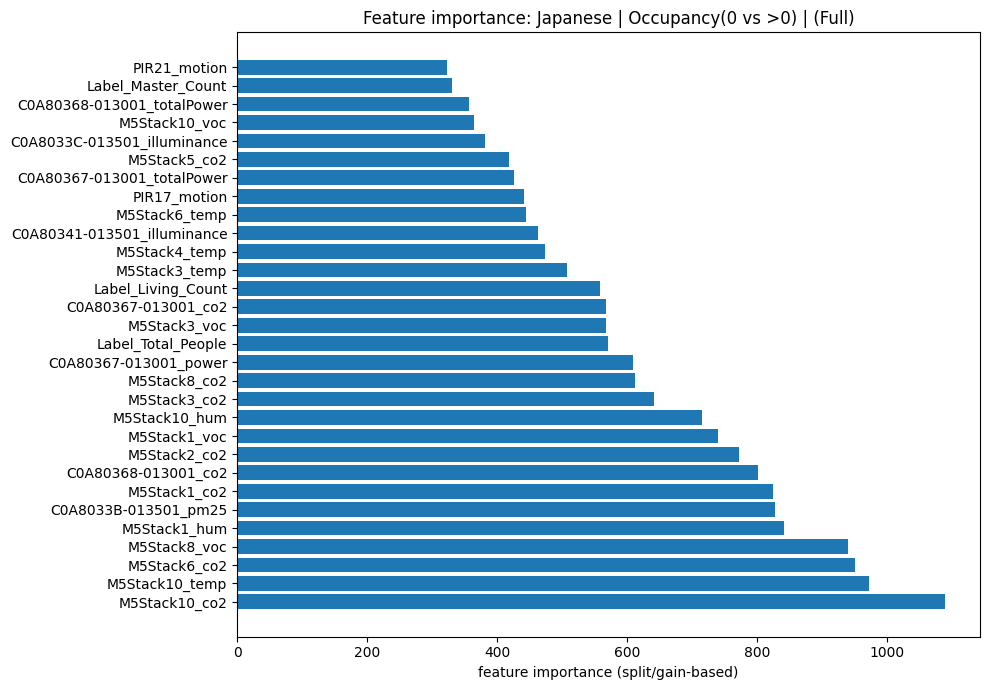


[Japanese][Occupancy(0 vs >0)] class dist train={0: 8323, 1: 2562} test={0: 1512, 1: 1209}
[LightGBM] [Info] Number of positive: 2562, number of negative: 8323
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9129
[LightGBM] [Info] Number of data points in the train set: 10885, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

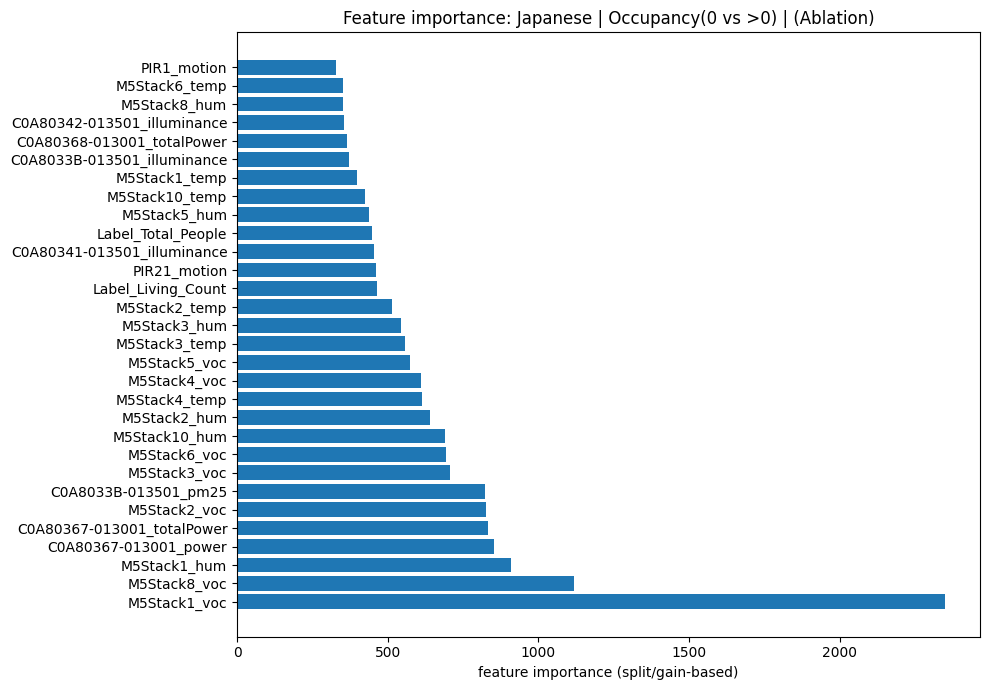


[SUMMARY][Japanese][Occupancy] Full acc=0.9250 | Ablation acc=0.9199 | drop=+0.0051

[Japanese][Count(1 vs 2 | occupied only)] class dist train={1: 1547, 2: 1470} test={1: 527, 2: 227}
[LightGBM] [Info] Number of positive: 1470, number of negative: 1547
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9230
[LightGBM] [Info] Number of data points in the train set: 3017, number of used features: 114
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

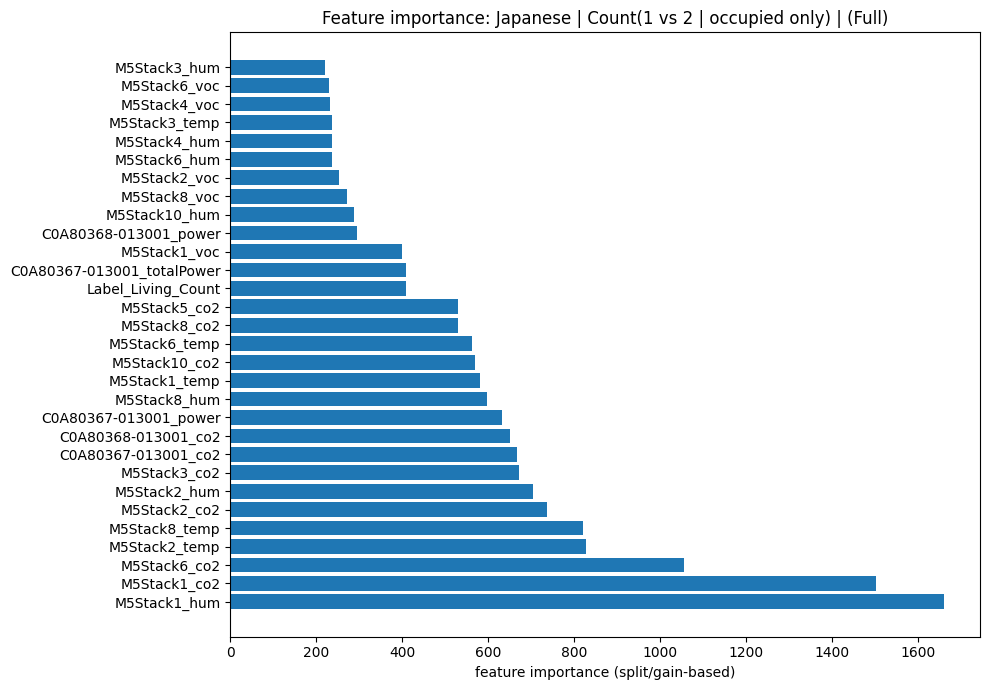


[Japanese][Count(1 vs 2 | occupied only)] class dist train={1: 1547, 2: 1470} test={1: 527, 2: 227}
[LightGBM] [Info] Number of positive: 1470, number of negative: 1547
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7273
[LightGBM] [Info] Number of data points in the train set: 3017, number of used features: 102
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

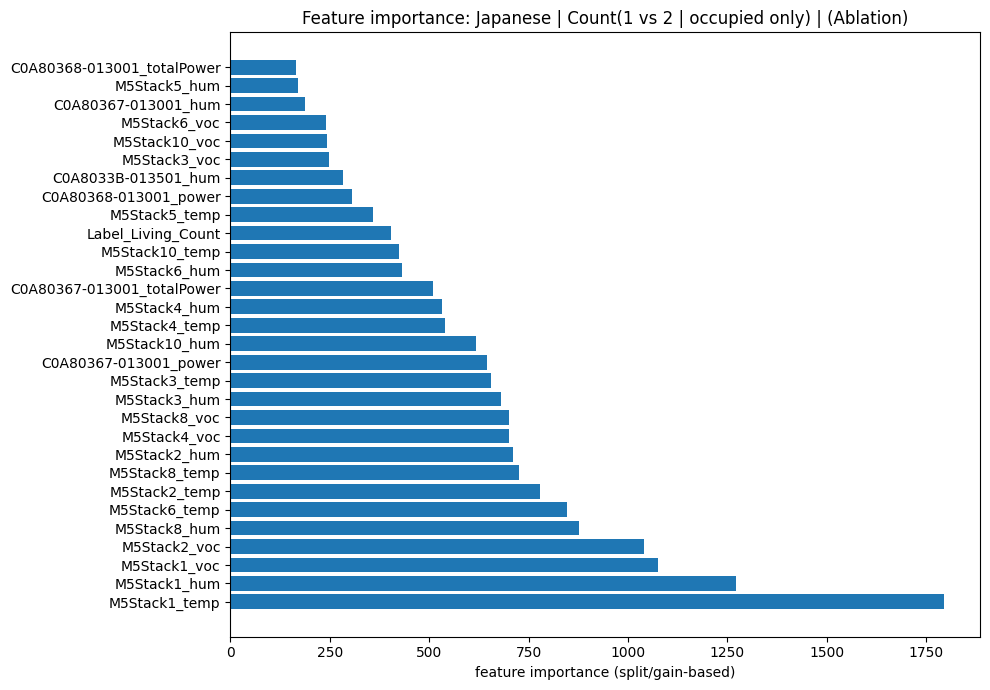


[SUMMARY][Japanese][1vs2] Full acc=1.0000 | Ablation acc=1.0000 | drop=+0.0000

[DONE]


In [1]:
# ============================================================
# 目的：
# (2) CO2センサ & 人感センサを外したとき、
#     - 残りのうち寄与度が高い特徴はどれか？
#     - 判定(精度/混同行列/レポート)はどれくらい変わるか？
#
# 方法：
#   Full vs Ablation(no CO2 + no human/PIR) を同一splitで比較
#   モデル：LightGBM
#   タスク：
#     1) 在不在（0 vs >0）
#     2) 1 vs 2（occupiedのみ）
#   部屋：Living / Japanese
# ============================================================

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from lightgbm import LGBMClassifier

# ---------------------------
# 設定
# ---------------------------
CSV_PATH = "./smart_home_merged_all.csv"

ROOMS = {
    "Living":   "Label_Living_Count",
    "Japanese": "Label_Japanese_Count",
}

# 人感センサの定義（必要なら調整）
# - PIR系（PIRxx_motion 等）
# - エアコンの human 系（..._human）
HUMAN_PATTERNS = [
    r"^PIR\d+_",      # PIRxx_...
    r"_human$",       # ..._human
    r"_human_",       # ..._human_...
    r"human",         # 念のため（過剰なら外してOK）
]

# CO2の定義
CO2_PATTERNS = [
    r"co2",           # co2 を含む列は基本CO2扱い（積分/傾きなど派生も含めたいので）
]

# 使うセンサ列を広めに拾う（ラベルと timestamp 以外）
# ただし明らかなID/文字列列を除外するために numeric化できない列は落ちる
EXCLUDE_COLS_EXACT = {"timestamp"}

# 時系列リーク回避：timestampでソート後、後ろ20%をテスト
TEST_RATIO = 0.2

# 重要度の表示数
TOPK_IMPORTANCE = 30

# ---------------------------
# ユーティリティ
# ---------------------------
def load_csv(path: str) -> pd.DataFrame:
    df = pd.read_csv(path, low_memory=False)

    if "timestamp" not in df.columns:
        raise ValueError("CSVに timestamp 列が見つかりません。")

    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    df = df.dropna(subset=["timestamp"]).sort_values("timestamp").reset_index(drop=True)

    # forward-fill（未来を使わない方針：ffillのみ）
    df = df.ffill().infer_objects(copy=False)

    return df


def is_match_any(name: str, patterns) -> bool:
    s = name.lower()
    for p in patterns:
        if re.search(p, s):
            return True
    return False


def split_time_series(df: pd.DataFrame, test_ratio=0.2):
    n = len(df)
    n_test = int(n * test_ratio)
    n_train = n - n_test
    train_idx = np.arange(0, n_train)
    test_idx  = np.arange(n_train, n)
    return train_idx, test_idx


def sanitize_numeric_features(X: pd.DataFrame) -> pd.DataFrame:
    X2 = X.copy()

    # bool -> int
    for c in X2.columns:
        if X2[c].dtype == bool:
            X2[c] = X2[c].astype(int)

    # 数値に変換できない列はNaNになり、その後埋める
    for c in X2.columns:
        if not pd.api.types.is_numeric_dtype(X2[c]):
            X2[c] = pd.to_numeric(X2[c], errors="coerce")

    # NaN/inf対策
    X2 = X2.replace([np.inf, -np.inf], np.nan).fillna(0)

    return X2


def select_feature_columns(df: pd.DataFrame, target_col: str):
    # label, timestamp以外を候補に
    candidates = [c for c in df.columns if c not in EXCLUDE_COLS_EXACT and c != target_col]

    # 目的：学習に使える列へ（数値化できない“純文字列”は後で0埋めされるので基本OKだが、極端な列は除外推奨）
    # ここでは広めに採用して、後段でto_numeric + fillna(0) に任せる
    return candidates


def build_ablation_sets(features):
    # Full: そのまま
    full = list(features)

    # Ablation: CO2 と 人感（PIR/ human）を外す
    ablated = []
    for c in features:
        if is_match_any(c, CO2_PATTERNS):
            continue
        if is_match_any(c, HUMAN_PATTERNS):
            continue
        ablated.append(c)

    return full, ablated


def train_eval_lgbm(X_train, y_train, X_test, y_test, title: str):
    # クラス不均衡を考慮
    model = LGBMClassifier(
        n_estimators=800,
        learning_rate=0.03,
        num_leaves=63,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced",
    )

    model.fit(X_train, y_train)

    pred = model.predict(X_test)
    acc = accuracy_score(y_test, pred)
    cm = confusion_matrix(y_test, pred)

    print(f"\n=== {title} ===")
    print(f"Accuracy: {acc:.4f}")
    print("Confusion Matrix:\n", cm)
    print("Report:\n", classification_report(y_test, pred, digits=4))

    return model, acc, cm


def plot_importance(model, feature_names, title: str, topk=30):
    imp = model.feature_importances_
    s = pd.Series(imp, index=feature_names).sort_values(ascending=False).head(topk)

    plt.figure(figsize=(10, 7))
    plt.gca().invert_yaxis()
    plt.barh(s.index[::-1], s.values[::-1])
    plt.title(title)
    plt.xlabel("feature importance (split/gain-based)")
    plt.tight_layout()
    plt.show()


# ---------------------------
# メイン：部屋ごとに (在不在, 1vs2) を Full vs Ablation 比較
# ---------------------------
df = load_csv(CSV_PATH)
print("Loaded:", df.shape)

for room_name, target_col in ROOMS.items():
    if target_col not in df.columns:
        print(f"[SKIP] {room_name}: target {target_col} not found")
        continue

    # 対象部屋のラベルが入ってる行だけ（欠損行を落とす）
    dfi = df.dropna(subset=[target_col]).copy()
    dfi[target_col] = pd.to_numeric(dfi[target_col], errors="coerce")
    dfi = dfi.dropna(subset=[target_col]).copy()
    dfi[target_col] = dfi[target_col].astype(int)

    # 0/1/2以外が混じってたら除外（必要なら拡張）
    dfi = dfi[dfi[target_col].isin([0, 1, 2])].copy()

    # 特徴列
    base_features = select_feature_columns(dfi, target_col=target_col)
    full_feats, ablated_feats = build_ablation_sets(base_features)

    # split（時系列）
    train_idx, test_idx = split_time_series(dfi, test_ratio=TEST_RATIO)

    print("\n" + "="*90)
    print(f"[ROOM] {room_name} | target={target_col} | rows={len(dfi)}")
    print(f"Features: full={len(full_feats)} ablated(noCO2+noHuman)={len(ablated_feats)}")
    print("="*90)

    # ============================================================
    # Task 1: 在不在（0 vs >0）
    # ============================================================
    y_occ = (dfi[target_col] > 0).astype(int)

    def run_task(task_name, Xcols, y):
        X = dfi[Xcols]
        X = sanitize_numeric_features(X)

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        print(f"\n[{room_name}][{task_name}] class dist train={y_train.value_counts().to_dict()} test={y_test.value_counts().to_dict()}")

        model, acc, cm = train_eval_lgbm(
            X_train, y_train, X_test, y_test,
            title=f"{room_name} | {task_name} | ({'Full' if Xcols is full_feats else 'Ablation'})"
        )
        plot_importance(model, Xcols, title=f"Feature importance: {room_name} | {task_name} | ({'Full' if Xcols is full_feats else 'Ablation'})", topk=TOPK_IMPORTANCE)
        return acc

    # Full
    acc_occ_full = run_task("Occupancy(0 vs >0)", full_feats, y_occ)
    # Ablation
    acc_occ_abla = run_task("Occupancy(0 vs >0)", ablated_feats, y_occ)

    print(f"\n[SUMMARY][{room_name}][Occupancy] Full acc={acc_occ_full:.4f} | Ablation acc={acc_occ_abla:.4f} | drop={acc_occ_full-acc_occ_abla:+.4f}")

    # ============================================================
    # Task 2: 1 vs 2（occupiedのときのみ）
    # ============================================================
    dfi_occ = dfi[dfi[target_col].isin([1, 2])].copy()
    if len(dfi_occ) < 100:
        print(f"[SKIP] {room_name}: 1vs2 samples too small ({len(dfi_occ)})")
        continue

    # split（occupied subsetでも時系列でsplit）
    train_idx2, test_idx2 = split_time_series(dfi_occ, test_ratio=TEST_RATIO)
    y_12 = dfi_occ[target_col]  # 1 or 2

    def run_task_12(task_name, Xcols):
        X = dfi_occ[Xcols]
        X = sanitize_numeric_features(X)

        X_train, X_test = X.iloc[train_idx2], X.iloc[test_idx2]
        y_train, y_test = y_12.iloc[train_idx2], y_12.iloc[test_idx2]

        print(f"\n[{room_name}][{task_name}] class dist train={y_train.value_counts().to_dict()} test={y_test.value_counts().to_dict()}")

        model, acc, cm = train_eval_lgbm(
            X_train, y_train, X_test, y_test,
            title=f"{room_name} | {task_name} | ({'Full' if Xcols is full_feats else 'Ablation'})"
        )
        plot_importance(model, Xcols, title=f"Feature importance: {room_name} | {task_name} | ({'Full' if Xcols is full_feats else 'Ablation'})", topk=TOPK_IMPORTANCE)
        return acc

    # Full
    acc_12_full = run_task_12("Count(1 vs 2 | occupied only)", full_feats)
    # Ablation
    acc_12_abla = run_task_12("Count(1 vs 2 | occupied only)", ablated_feats)

    print(f"\n[SUMMARY][{room_name}][1vs2] Full acc={acc_12_full:.4f} | Ablation acc={acc_12_abla:.4f} | drop={acc_12_full-acc_12_abla:+.4f}")

print("\n[DONE]")




📥 Loading CSV...

Base features: 125 (CO2=10 PIR~=19)

[ROOM] Living | count label: Label_Living_Count

--- Task: Occupancy (0 vs >0) ---
class dist train={np.int64(0): np.int64(5183), np.int64(1): np.int64(3306)} test={np.int64(0): np.int64(1828), np.int64(1): np.int64(1166)}
class weights: [0.8189273 1.2838778]
[Living-MLP-Occ] Epoch 01 train_loss=0.2853 val_loss=0.0921
[Living-MLP-Occ] Epoch 02 train_loss=0.0616 val_loss=0.0557
[Living-MLP-Occ] Epoch 03 train_loss=0.0298 val_loss=0.0376
[Living-MLP-Occ] Epoch 04 train_loss=0.0216 val_loss=0.0396
[Living-MLP-Occ] Epoch 05 train_loss=0.0190 val_loss=0.0362
[Living-MLP-Occ] Epoch 06 train_loss=0.0161 val_loss=0.0387
[Living-MLP-Occ] Epoch 07 train_loss=0.0122 val_loss=0.0427
[Living-MLP-Occ] Epoch 08 train_loss=0.0106 val_loss=0.0400
[Living-MLP-Occ] Epoch 09 train_loss=0.0079 val_loss=0.0331
[Living-MLP-Occ] Epoch 10 train_loss=0.0059 val_loss=0.0323
[Living-MLP-Occ] Epoch 11 train_loss=0.0051 val_loss=0.0321
[Living-MLP-Occ] Epoch 12

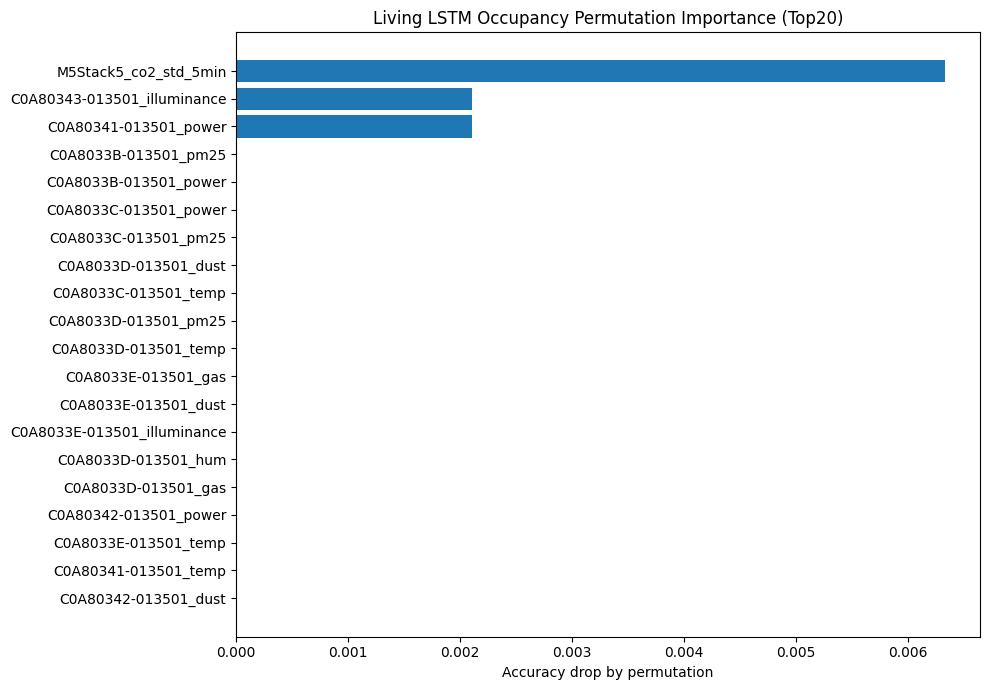


[Importance][MLP Occ] base_acc=0.9943


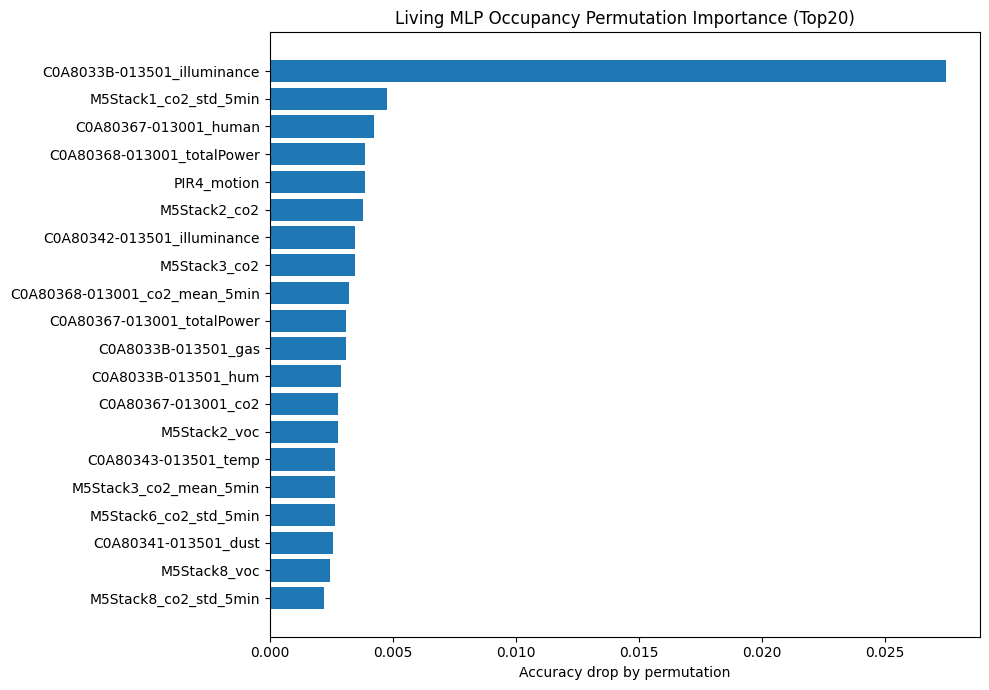


--- Task: Single vs Multiple (occupied only) ---
class dist train={np.int64(0): np.int64(1614), np.int64(1): np.int64(1565)} test={np.int64(0): np.int64(673), np.int64(1): np.int64(652)}
class weights: [0.9848203 1.0156549]
[Living-MLP-1vM] Epoch 01 train_loss=0.5048 val_loss=0.2183
[Living-MLP-1vM] Epoch 02 train_loss=0.1271 val_loss=0.1118
[Living-MLP-1vM] Epoch 03 train_loss=0.0593 val_loss=0.0814
[Living-MLP-1vM] Epoch 04 train_loss=0.0419 val_loss=0.0871
[Living-MLP-1vM] Epoch 05 train_loss=0.0334 val_loss=0.0571
[Living-MLP-1vM] Epoch 06 train_loss=0.0189 val_loss=0.0659
[Living-MLP-1vM] Epoch 07 train_loss=0.0178 val_loss=0.0664
[Living-MLP-1vM] Epoch 08 train_loss=0.0144 val_loss=0.0677
[Living-MLP-1vM] Epoch 09 train_loss=0.0096 val_loss=0.0724
[Living-MLP-1vM] Epoch 10 train_loss=0.0064 val_loss=0.0610
[Living-MLP-1vM] Early stop.

=== Living MLP Single(1) vs Multiple(>=2) ===
Accuracy: 0.9849
Confusion Matrix:
 [[665   8]
 [ 12 640]]
Report:
               precision    reca

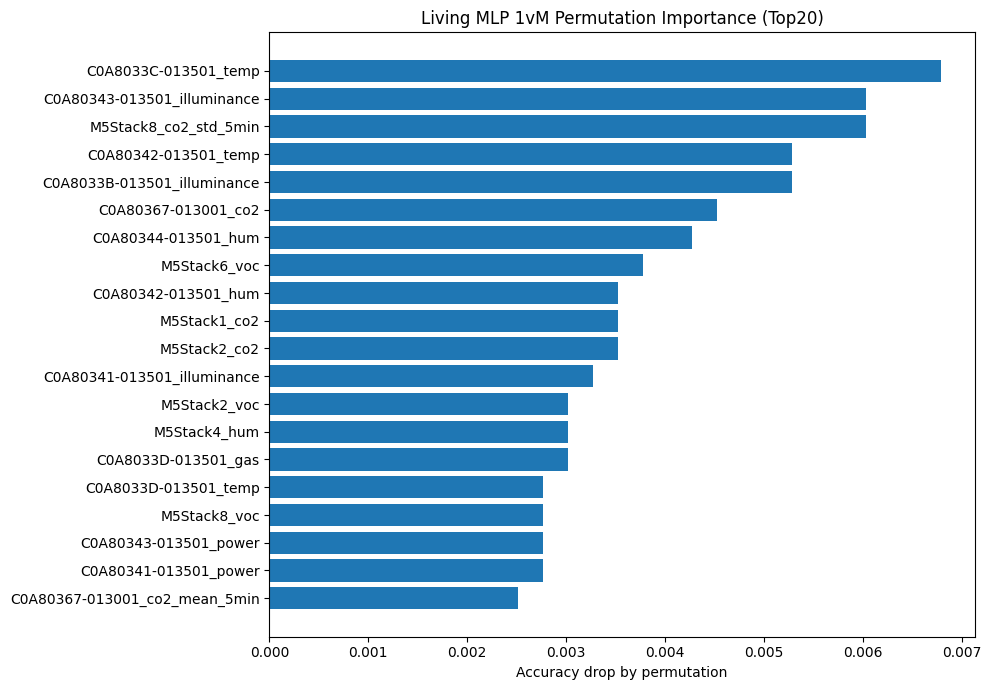


[ROOM] Japanese | count label: Label_Japanese_Count

--- Task: Occupancy (0 vs >0) ---
class dist train={np.int64(0): np.int64(6136), np.int64(1): np.int64(2353)} test={np.int64(0): np.int64(2164), np.int64(1): np.int64(830)}
class weights: [0.6917373 1.8038675]
[Japanese-MLP-Occ] Epoch 01 train_loss=0.3018 val_loss=0.0642
[Japanese-MLP-Occ] Epoch 02 train_loss=0.0538 val_loss=0.0419
[Japanese-MLP-Occ] Epoch 03 train_loss=0.0264 val_loss=0.0288
[Japanese-MLP-Occ] Epoch 04 train_loss=0.0158 val_loss=0.0205
[Japanese-MLP-Occ] Epoch 05 train_loss=0.0114 val_loss=0.0262
[Japanese-MLP-Occ] Epoch 06 train_loss=0.0072 val_loss=0.0285
[Japanese-MLP-Occ] Epoch 07 train_loss=0.0064 val_loss=0.0311
[Japanese-MLP-Occ] Epoch 08 train_loss=0.0078 val_loss=0.0307
[Japanese-MLP-Occ] Epoch 09 train_loss=0.0071 val_loss=0.0299
[Japanese-MLP-Occ] Early stop.

=== Japanese MLP Occupancy ===
Accuracy: 0.9910
Confusion Matrix:
 [[2142   22]
 [   5  825]]
Report:
               precision    recall  f1-score

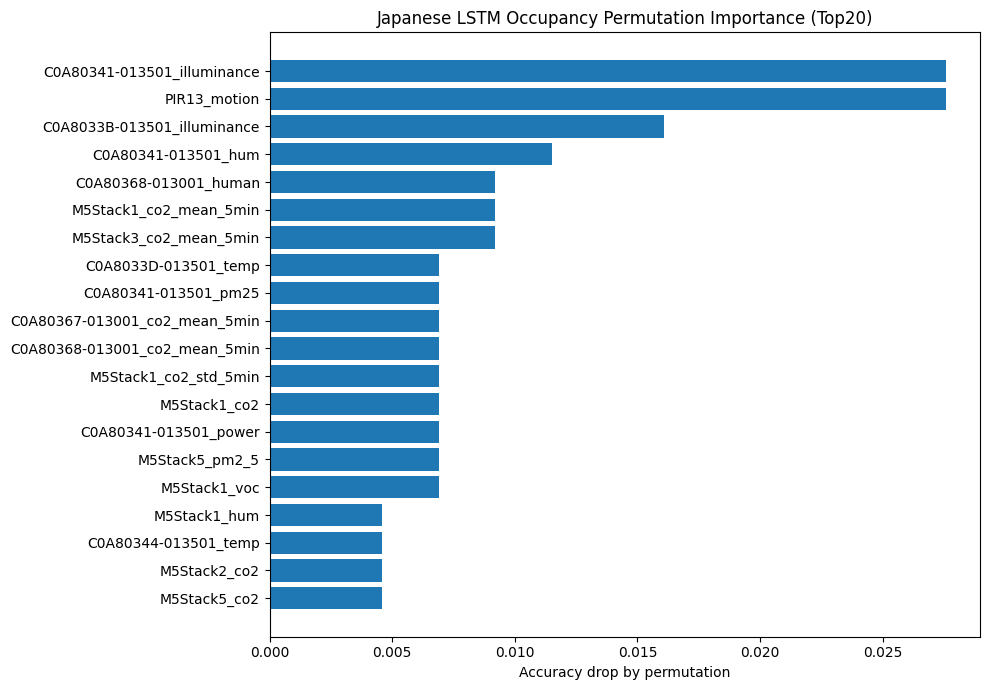


[Importance][MLP Occ] base_acc=0.9910


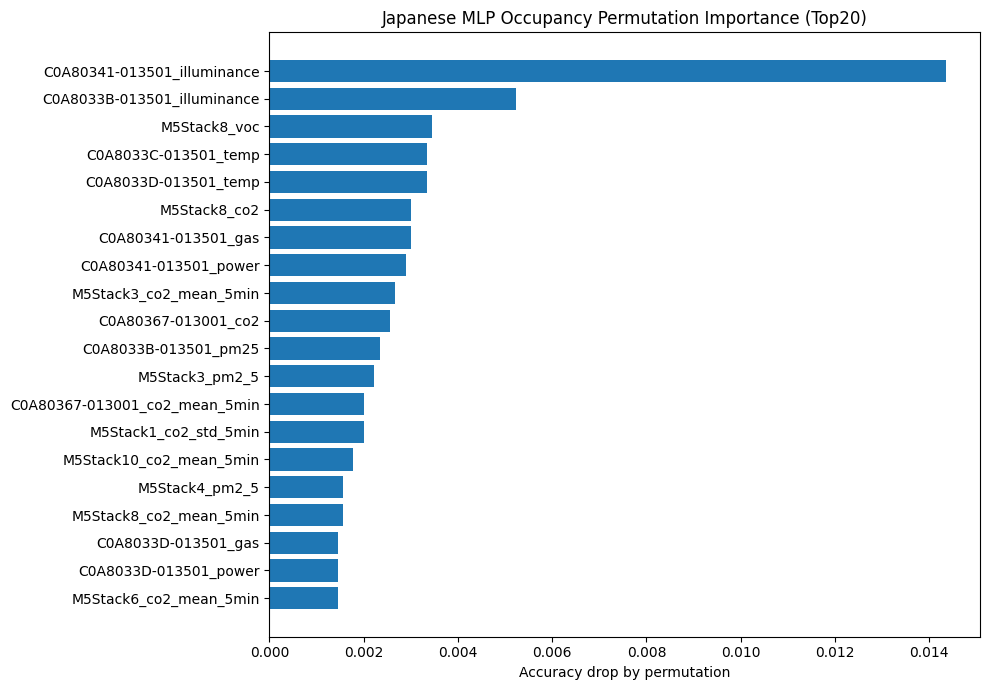


--- Task: Single vs Multiple (occupied only) ---
class dist train={np.int64(0): np.int64(1244), np.int64(1): np.int64(1018)} test={np.int64(0): np.int64(519), np.int64(1): np.int64(424)}
class weights: [0.909164 1.111002]
[Japanese-MLP-1vM] Epoch 01 train_loss=0.5503 val_loss=0.3198
[Japanese-MLP-1vM] Epoch 02 train_loss=0.2365 val_loss=0.1654
[Japanese-MLP-1vM] Epoch 03 train_loss=0.0856 val_loss=0.1520
[Japanese-MLP-1vM] Epoch 04 train_loss=0.0449 val_loss=0.2022
[Japanese-MLP-1vM] Epoch 05 train_loss=0.0321 val_loss=0.2231
[Japanese-MLP-1vM] Epoch 06 train_loss=0.0218 val_loss=0.2558
[Japanese-MLP-1vM] Epoch 07 train_loss=0.0141 val_loss=0.2643
[Japanese-MLP-1vM] Epoch 08 train_loss=0.0100 val_loss=0.2671
[Japanese-MLP-1vM] Early stop.

=== Japanese MLP Single(1) vs Multiple(>=2) ===
Accuracy: 0.9671
Confusion Matrix:
 [[512   7]
 [ 24 400]]
Report:
               precision    recall  f1-score   support

           0     0.9552    0.9865    0.9706       519
           1     0.9828 

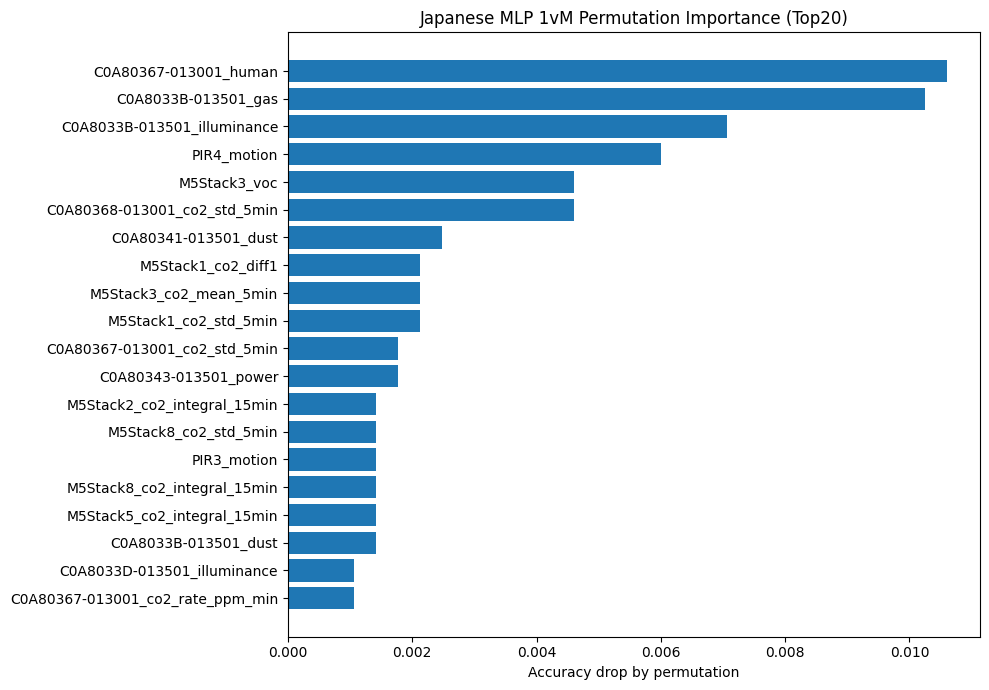


[DONE]


In [2]:
# ============================================================
# Deep Learning (MLP) + Time-series (LSTM) for SmartHome
#  - Rooms: Living / Japanese (Washitu)
#  - Tasks:
#     (1) Occupancy: 0 vs >0
#     (2) Single vs Multiple: 1 vs (>=2)  ※occupiedのみ
#  - Feature engineering:
#     CO2: diff/rate, rolling mean/std, slope(10min), integral(15min)
#  - Handling imbalance:
#     class weights + (optional) noise augmentation on train
#  - Feature importance:
#     permutation importance (tabular MLP / sequence LSTM)
#
# CSV path (as requested): ./smart_home_merged_all.csv
# ============================================================

import os
import math
import random
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# -----------------------------
# Config
# -----------------------------
CSV_PATH = "./smart_home_merged_all.csv"  # requested path
SEED = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# MLP training
MLP_EPOCHS = 30
MLP_BATCH = 512
MLP_LR = 2e-3
MLP_WEIGHT_DECAY = 1e-4
MLP_PATIENCE = 5
AUG_NOISE_STD = 0.02  # numeric feature Gaussian noise on train batches

# LSTM training (sequence)
SEQ_LEN = 120           # number of rows per window (adjust if needed)
SEQ_STRIDE = 20         # step between windows
LSTM_EPOCHS = 20
LSTM_BATCH = 256
LSTM_LR = 2e-3
LSTM_WEIGHT_DECAY = 1e-4
LSTM_PATIENCE = 4

# Importance
IMPORTANCE_TOPK = 20
PERM_REPEATS = 3

# Rooms / targets
ROOMS = {
    "Living":   "Label_Living_Count",
    "Japanese": "Label_Japanese_Count",
}

# If you want to restrict features to particular sensors, edit these filters.
# Here we use: CO2 + (optional) other numeric sensor cols + PIR motion booleans
USE_OTHER_SENSORS = True  # set False if you want CO2-only experiments

# -----------------------------
# Utils
# -----------------------------
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)

def safe_read_csv(path: str) -> pd.DataFrame:
    if not os.path.exists(path):
        raise FileNotFoundError(
            f"CSV not found at {path}. If you're running in a different environment, "
            f"place the file there or change CSV_PATH."
        )
    df = pd.read_csv(path, low_memory=False)
    # Convert timestamp
    if "timestamp" in df.columns:
        df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
        df = df.dropna(subset=["timestamp"]).sort_values("timestamp").reset_index(drop=True)
    return df

def infer_and_clean(df: pd.DataFrame) -> pd.DataFrame:
    # Forward fill only (no "future" leakage). Then infer objects.
    df = df.ffill().infer_objects(copy=False)
    # Replace inf
    num_cols = df.select_dtypes(include=[np.number]).columns
    df[num_cols] = df[num_cols].replace([np.inf, -np.inf], np.nan)
    # Fill remaining numeric NaN with 0 (you can change to median if desired)
    df[num_cols] = df[num_cols].fillna(0)
    return df

def pick_base_features(df: pd.DataFrame):
    # PIR columns (bool or 0/1)
    pir_cols = [c for c in df.columns if "PIR" in c and ("motion" in c or df[c].dropna().isin([0,1,True,False]).all())]
    # CO2 columns
    co2_cols = [c for c in df.columns if c.endswith("_co2") or c.endswith("-013001_co2") or c.endswith("-013501_co2") or ("_co2" in c)]
    # Deduplicate and keep only existing numeric-ish columns later
    co2_cols = sorted(list(set([c for c in co2_cols if c in df.columns])))

    other_cols = []
    if USE_OTHER_SENSORS:
        keywords = ["_temp", "_hum", "_voc", "_pm2_5", "_pm25", "_gas", "_illuminance", "_dust", "_power", "_totalPower"]
        other_cols = [c for c in df.columns if any(k in c for k in keywords)]
        other_cols = sorted(list(set(other_cols)))

    base = sorted(list(set(pir_cols + co2_cols + other_cols)))
    # Remove labels/timestamp if accidentally included
    base = [c for c in base if not c.startswith("Label_") and c != "timestamp"]
    return base, co2_cols, pir_cols

def to_numeric_frame(df: pd.DataFrame, cols):
    X = df[cols].copy()
    # bool -> int
    for c in X.columns:
        if X[c].dtype == bool:
            X[c] = X[c].astype(int)
    # coerce objects
    for c in X.columns:
        if X[c].dtype == object:
            X[c] = pd.to_numeric(X[c], errors="coerce")
    X = X.fillna(0)
    return X

# -----------------------------
# CO2 feature engineering (time-based)
# -----------------------------
def add_co2_features(df: pd.DataFrame, co2_cols):
    """
    Adds for each CO2 column:
      - diff_1 (ppm)
      - rate_ppm_per_min
      - mean_5min, std_5min
      - integral_15min (ppm*min approx)
      - slope_10min (ppm/min approx)
    Uses timestamp index (must exist).
    """
    if "timestamp" not in df.columns:
        raise ValueError("timestamp column is required for CO2 time features")

    dfi = df.copy()
    dfi = dfi.sort_values("timestamp").reset_index(drop=True)
    dfi = dfi.set_index("timestamp")

    # dt in minutes (per row)
    t = dfi.index.view("int64") / 1e9  # seconds
    dt_min = pd.Series(np.diff(t, prepend=t[0]) / 60.0, index=dfi.index).clip(lower=1e-6)
    dfi["_dt_min"] = dt_min

    new_cols = {}

    for c in co2_cols:
        if c not in dfi.columns:
            continue
        # numeric
        s = pd.to_numeric(dfi[c], errors="coerce").fillna(method="ffill").fillna(0)

        # 1-step diff & rate
        diff1 = s.diff().fillna(0)
        rate = (diff1 / dfi["_dt_min"]).replace([np.inf, -np.inf], 0).fillna(0)

        # rolling stats
        mean_5 = s.rolling("5min", min_periods=1).mean()
        std_5  = s.rolling("5min", min_periods=1).std().fillna(0)

        # integral (sum s*dt) over 15min
        # approximate integral by cumulative sum of s*dt, then rolling sum
        area = (s * dfi["_dt_min"]).fillna(0)
        integral_15 = area.rolling("15min", min_periods=1).sum()

        # slope over 10min: (s_now - s_10min_ago) / minutes
        s_10ago = s.shift(freq="10min")  # aligns by timestamp
        # If shift(freq=) creates NaN at start, fill with nearest past
        s_10ago = s_10ago.reindex(dfi.index).fillna(method="bfill").fillna(method="ffill")
        delta = (s - s_10ago)
        slope_10 = (delta / 10.0).replace([np.inf, -np.inf], 0).fillna(0)  # ppm/min

        new_cols[f"{c}_diff1"] = diff1
        new_cols[f"{c}_rate_ppm_min"] = rate
        new_cols[f"{c}_mean_5min"] = mean_5
        new_cols[f"{c}_std_5min"] = std_5
        new_cols[f"{c}_integral_15min"] = integral_15
        new_cols[f"{c}_slope_10min"] = slope_10

    # merge without fragmentation
    feat_df = pd.DataFrame(new_cols, index=dfi.index)
    out = pd.concat([dfi, feat_df], axis=1)
    out = out.drop(columns=["_dt_min"], errors="ignore").reset_index()
    return out

# -----------------------------
# Label creation
# -----------------------------
def build_targets(df: pd.DataFrame, count_col: str):
    """
    Returns:
      y_occ: 0 vs 1 (0 if count==0 else 1)
      y_sm : 0 vs 1 for single vs multiple (only where occupied)
             0 => single(==1), 1 => multiple(>=2)
    """
    y_count = df[count_col]
    y_occ = (y_count > 0).astype(int)

    occupied_mask = (y_count > 0)
    y_sm = None
    if occupied_mask.sum() > 0:
        y_sm = ((y_count >= 2).astype(int)).where(occupied_mask, np.nan)  # NaN for non-occupied
    return y_occ, y_sm, occupied_mask

# -----------------------------
# Torch datasets
# -----------------------------
class TabularDataset(Dataset):
    def __init__(self, X, y, augment_noise_std=0.0, is_train=False):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
        self.augment_noise_std = augment_noise_std
        self.is_train = is_train

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x = self.X[idx]
        if self.is_train and self.augment_noise_std > 0:
            # only on numeric continuous (we just apply to all; scaler makes it safe)
            x = x + torch.randn_like(x) * self.augment_noise_std
        return x, self.y[idx]

class SequenceDataset(Dataset):
    def __init__(self, X_seq, y_seq):
        self.X = torch.tensor(X_seq, dtype=torch.float32)  # [N, T, F]
        self.y = torch.tensor(y_seq, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# -----------------------------
# Models
# -----------------------------
class MLP(nn.Module):
    def __init__(self, in_dim, num_classes=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        return self.net(x)

class LSTMClassifier(nn.Module):
    def __init__(self, in_dim, hidden=128, layers=1, num_classes=2, bidir=True):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=in_dim,
            hidden_size=hidden,
            num_layers=layers,
            batch_first=True,
            bidirectional=bidir,
            dropout=0.0 if layers == 1 else 0.2,
        )
        out_dim = hidden * (2 if bidir else 1)
        self.head = nn.Sequential(
            nn.Linear(out_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        # x: [B, T, F]
        out, _ = self.lstm(x)
        last = out[:, -1, :]  # last time-step
        return self.head(last)

# -----------------------------
# Train / Eval
# -----------------------------
def compute_class_weights(y: np.ndarray):
    classes, counts = np.unique(y, return_counts=True)
    total = counts.sum()
    weights = {}
    for c, n in zip(classes, counts):
        weights[int(c)] = total / (len(classes) * n)
    w = np.array([weights.get(i, 1.0) for i in range(int(classes.max()) + 1)], dtype=np.float32)
    return w

def train_torch(model, train_loader, val_loader, epochs, lr, weight_decay, class_weights, patience, desc=""):
    model = model.to(DEVICE)
    cw = torch.tensor(class_weights, dtype=torch.float32, device=DEVICE)
    criterion = nn.CrossEntropyLoss(weight=cw)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val = float("inf")
    best_state = None
    bad = 0

    for ep in range(1, epochs + 1):
        model.train()
        tr_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            opt.step()
            tr_loss += loss.item() * len(yb)

        tr_loss /= len(train_loader.dataset)

        model.eval()
        va_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                logits = model(xb)
                loss = criterion(logits, yb)
                va_loss += loss.item() * len(yb)
        va_loss /= len(val_loader.dataset)

        print(f"[{desc}] Epoch {ep:02d} train_loss={tr_loss:.4f} val_loss={va_loss:.4f}")

        if va_loss < best_val - 1e-4:
            best_val = va_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                print(f"[{desc}] Early stop.")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    return model

@torch.no_grad()
def predict_torch(model, loader):
    model.eval()
    ys, ps = [], []
    for xb, yb in loader:
        xb = xb.to(DEVICE)
        logits = model(xb)
        pred = torch.argmax(logits, dim=1).cpu().numpy()
        ps.append(pred)
        ys.append(yb.numpy())
    return np.concatenate(ys), np.concatenate(ps)

def evaluate_binary(y_true, y_pred, title=""):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    rep = classification_report(y_true, y_pred, digits=4)
    print(f"\n=== {title} ===")
    print(f"Accuracy: {acc:.4f}")
    print("Confusion Matrix:\n", cm)
    print("Report:\n", rep)
    return acc, cm, rep

# -----------------------------
# Permutation importance
# -----------------------------
def permutation_importance_tabular(model, X_test, y_test, feature_names, scaler, repeats=PERM_REPEATS):
    """
    Permute one column at a time on test and compute accuracy drop.
    """
    base_X = X_test.copy()
    base_scaled = scaler.transform(base_X)
    ds = TabularDataset(base_scaled, y_test, augment_noise_std=0.0, is_train=False)
    loader = DataLoader(ds, batch_size=2048, shuffle=False)
    yt, yp = predict_torch(model, loader)
    base_acc = accuracy_score(yt, yp)

    drops = []
    rng = np.random.default_rng(SEED)

    for j, fname in enumerate(feature_names):
        accs = []
        for _ in range(repeats):
            Xp = base_X.copy()
            perm = Xp[:, j].copy()
            rng.shuffle(perm)
            Xp[:, j] = perm
            Xp_scaled = scaler.transform(Xp)
            ds_p = TabularDataset(Xp_scaled, y_test, augment_noise_std=0.0, is_train=False)
            ld_p = DataLoader(ds_p, batch_size=2048, shuffle=False)
            yt2, yp2 = predict_torch(model, ld_p)
            accs.append(accuracy_score(yt2, yp2))
        drop = base_acc - float(np.mean(accs))
        drops.append(drop)

    imp = pd.DataFrame({"feature": feature_names, "drop_acc": drops}).sort_values("drop_acc", ascending=False)
    return base_acc, imp

def permutation_importance_sequence(model, X_test_seq, y_test, feature_names, repeats=PERM_REPEATS):
    """
    Permute one feature across all time steps for each window.
    """
    # baseline
    ds = SequenceDataset(X_test_seq, y_test)
    ld = DataLoader(ds, batch_size=2048, shuffle=False)
    yt, yp = predict_torch(model, ld)
    base_acc = accuracy_score(yt, yp)

    drops = []
    rng = np.random.default_rng(SEED)

    for f in range(len(feature_names)):
        accs = []
        for _ in range(repeats):
            Xp = X_test_seq.copy()
            # permute feature values by shuffling windows (keeping temporal structure inside window)
            perm_idx = rng.permutation(Xp.shape[0])
            Xp[:, :, f] = Xp[perm_idx, :, f]
            ds_p = SequenceDataset(Xp, y_test)
            ld_p = DataLoader(ds_p, batch_size=2048, shuffle=False)
            yt2, yp2 = predict_torch(model, ld_p)
            accs.append(accuracy_score(yt2, yp2))
        drops.append(base_acc - float(np.mean(accs)))

    imp = pd.DataFrame({"feature": feature_names, "drop_acc": drops}).sort_values("drop_acc", ascending=False)
    return base_acc, imp

def plot_importance(df_imp: pd.DataFrame, title: str, topk=IMPORTANCE_TOPK):
    top = df_imp.head(topk).iloc[::-1]
    plt.figure(figsize=(10, max(4, 0.35 * len(top))))
    plt.barh(top["feature"], top["drop_acc"])
    plt.title(title)
    plt.xlabel("Accuracy drop by permutation")
    plt.tight_layout()
    plt.show()

# -----------------------------
# Sequence windowing
# -----------------------------
def make_windows(X: np.ndarray, y: np.ndarray, seq_len=SEQ_LEN, stride=SEQ_STRIDE):
    """
    Sliding windows on rows. Label is label at window end.
    Returns X_seq [N, T, F], y_seq [N]
    """
    Xs, ys = [], []
    n = len(y)
    for start in range(0, n - seq_len + 1, stride):
        end = start + seq_len
        Xs.append(X[start:end])
        ys.append(y[end - 1])
    return np.stack(Xs, axis=0), np.array(ys, dtype=np.int64)

# ============================================================
# Main pipeline per room & task
# ============================================================
def run_room(df_all: pd.DataFrame, room_name: str, count_col: str, base_features, co2_cols):
    print("\n" + "="*90)
    print(f"[ROOM] {room_name} | count label: {count_col}")
    print("="*90)

    # Keep only rows where label exists
    df = df_all.copy()
    df = df.dropna(subset=[count_col]).reset_index(drop=True)

    # Create targets
    y_occ, y_sm, occupied_mask = build_targets(df, count_col)

    # Build features: numeric/pir/sensors + engineered co2
    df_feat = df.copy()
    df_feat = add_co2_features(df_feat, co2_cols)

    # Re-pick features (includes newly added CO2 features)
    feature_cols = list(base_features)
    # Add generated CO2 features
    gen_cols = [c for c in df_feat.columns if any(c.endswith(suf) for suf in ["_diff1","_rate_ppm_min","_mean_5min","_std_5min","_integral_15min","_slope_10min"])]
    feature_cols = sorted(list(set(feature_cols + gen_cols)))

    # Build X matrix
    X_df = to_numeric_frame(df_feat, feature_cols)
    X = X_df.values.astype(np.float32)

    # -----------------------------
    # Task 1: Occupancy 0 vs >0
    # -----------------------------
    print(f"\n--- Task: Occupancy (0 vs >0) ---")
    y = y_occ.values.astype(np.int64)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.22, random_state=SEED, shuffle=True, stratify=y
    )
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=SEED, shuffle=True, stratify=y_train
    )

    scaler = StandardScaler()
    X_tr_s = scaler.fit_transform(X_tr)
    X_val_s = scaler.transform(X_val)
    X_test_s = scaler.transform(X_test)

    cw = compute_class_weights(y_tr)
    print(f"class dist train={dict(zip(*np.unique(y_tr, return_counts=True)))} test={dict(zip(*np.unique(y_test, return_counts=True)))}")
    print(f"class weights: {cw}")

    # MLP
    mlp = MLP(in_dim=X_tr_s.shape[1], num_classes=2)
    tr_ds = TabularDataset(X_tr_s, y_tr, augment_noise_std=AUG_NOISE_STD, is_train=True)
    va_ds = TabularDataset(X_val_s, y_val, augment_noise_std=0.0, is_train=False)
    te_ds = TabularDataset(X_test_s, y_test, augment_noise_std=0.0, is_train=False)

    tr_ld = DataLoader(tr_ds, batch_size=MLP_BATCH, shuffle=True, drop_last=False)
    va_ld = DataLoader(va_ds, batch_size=MLP_BATCH, shuffle=False, drop_last=False)
    te_ld = DataLoader(te_ds, batch_size=MLP_BATCH, shuffle=False, drop_last=False)

    mlp = train_torch(
        mlp, tr_ld, va_ld,
        epochs=MLP_EPOCHS, lr=MLP_LR, weight_decay=MLP_WEIGHT_DECAY,
        class_weights=cw, patience=MLP_PATIENCE,
        desc=f"{room_name}-MLP-Occ"
    )
    yt, yp = predict_torch(mlp, te_ld)
    evaluate_binary(yt, yp, title=f"{room_name} MLP Occupancy")

    # LSTM windows (sequence)
    # Use scaled features for sequence too
    X_all_s = scaler.transform(X)  # fit from train split to avoid leakage
    y_all = y

    # split indices for sequence windows using row-level splits
    idx = np.arange(len(y_all))
    idx_train, idx_test = train_test_split(idx, test_size=0.22, random_state=SEED, shuffle=True, stratify=y_all)
    idx_tr, idx_val = train_test_split(idx_train, test_size=0.2, random_state=SEED, shuffle=True, stratify=y_all[idx_train])

    # For windows, we need contiguous slices -> easiest is to build windows on full series and then assign by window-end index.
    X_seq, y_seq = make_windows(X_all_s, y_all, seq_len=SEQ_LEN, stride=SEQ_STRIDE)
    # window end indices
    end_idx = np.arange(SEQ_LEN-1, len(y_all), SEQ_STRIDE)

    # mask windows by which split their end index belongs to
    tr_mask = np.isin(end_idx, idx_tr)
    va_mask = np.isin(end_idx, idx_val)
    te_mask = np.isin(end_idx, idx_test)

    X_tr_seq, y_tr_seq = X_seq[tr_mask], y_seq[tr_mask]
    X_va_seq, y_va_seq = X_seq[va_mask], y_seq[va_mask]
    X_te_seq, y_te_seq = X_seq[te_mask], y_seq[te_mask]

    if len(y_tr_seq) >= 200 and len(np.unique(y_tr_seq)) == 2:
        cw_seq = compute_class_weights(y_tr_seq)
        print(f"\n[Seq] windows: train={len(y_tr_seq)} val={len(y_va_seq)} test={len(y_te_seq)} | class weights={cw_seq}")

        lstm = LSTMClassifier(in_dim=X_tr_seq.shape[2], hidden=128, layers=1, num_classes=2, bidir=True)

        tr_ds_seq = SequenceDataset(X_tr_seq, y_tr_seq)
        va_ds_seq = SequenceDataset(X_va_seq, y_va_seq)
        te_ds_seq = SequenceDataset(X_te_seq, y_te_seq)

        tr_ld_seq = DataLoader(tr_ds_seq, batch_size=LSTM_BATCH, shuffle=True, drop_last=False)
        va_ld_seq = DataLoader(va_ds_seq, batch_size=LSTM_BATCH, shuffle=False, drop_last=False)
        te_ld_seq = DataLoader(te_ds_seq, batch_size=LSTM_BATCH, shuffle=False, drop_last=False)

        lstm = train_torch(
            lstm, tr_ld_seq, va_ld_seq,
            epochs=LSTM_EPOCHS, lr=LSTM_LR, weight_decay=LSTM_WEIGHT_DECAY,
            class_weights=cw_seq, patience=LSTM_PATIENCE,
            desc=f"{room_name}-LSTM-Occ"
        )
        yt_s, yp_s = predict_torch(lstm, te_ld_seq)
        evaluate_binary(yt_s, yp_s, title=f"{room_name} LSTM Occupancy (windowed)")

        # Feature importance (LSTM) - permutation on windows
        base_acc, imp_seq = permutation_importance_sequence(
            lstm, X_te_seq, y_te_seq, feature_cols, repeats=PERM_REPEATS
        )
        print(f"\n[Importance][LSTM Occ] base_acc={base_acc:.4f}")
        plot_importance(imp_seq, f"{room_name} LSTM Occupancy Permutation Importance (Top{IMPORTANCE_TOPK})")

    else:
        print("\n[Seq] Not enough windows or only one class present. Skipping LSTM for occupancy.")

    # Feature importance (MLP) - permutation on tabular test
    base_acc, imp_mlp = permutation_importance_tabular(
        mlp, X_test, y_test, feature_cols, scaler, repeats=PERM_REPEATS
    )
    print(f"\n[Importance][MLP Occ] base_acc={base_acc:.4f}")
    plot_importance(imp_mlp, f"{room_name} MLP Occupancy Permutation Importance (Top{IMPORTANCE_TOPK})")

    # -----------------------------
    # Task 2: Single vs Multiple (occupied only)
    # -----------------------------
    print(f"\n--- Task: Single vs Multiple (occupied only) ---")
    # y_sm is NaN for non-occupied
    mask_occ = occupied_mask.values
    if mask_occ.sum() < 200:
        print("Not enough occupied samples; skipping.")
        return

    # build X/y for occupied
    X2 = X[mask_occ]
    y2 = y_sm[mask_occ].values.astype(np.int64)  # 0 single, 1 multiple

    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X2, y2, test_size=0.25, random_state=SEED, shuffle=True, stratify=y2
    )
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=SEED, shuffle=True, stratify=y_train
    )

    scaler2 = StandardScaler()
    X_tr_s = scaler2.fit_transform(X_tr)
    X_val_s = scaler2.transform(X_val)
    X_test_s = scaler2.transform(X_test)

    cw2 = compute_class_weights(y_tr)
    print(f"class dist train={dict(zip(*np.unique(y_tr, return_counts=True)))} test={dict(zip(*np.unique(y_test, return_counts=True)))}")
    print(f"class weights: {cw2}")

    # MLP
    mlp2 = MLP(in_dim=X_tr_s.shape[1], num_classes=2)
    tr_ds2 = TabularDataset(X_tr_s, y_tr, augment_noise_std=AUG_NOISE_STD, is_train=True)
    va_ds2 = TabularDataset(X_val_s, y_val, augment_noise_std=0.0, is_train=False)
    te_ds2 = TabularDataset(X_test_s, y_test, augment_noise_std=0.0, is_train=False)

    tr_ld2 = DataLoader(tr_ds2, batch_size=MLP_BATCH, shuffle=True, drop_last=False)
    va_ld2 = DataLoader(va_ds2, batch_size=MLP_BATCH, shuffle=False, drop_last=False)
    te_ld2 = DataLoader(te_ds2, batch_size=MLP_BATCH, shuffle=False, drop_last=False)

    mlp2 = train_torch(
        mlp2, tr_ld2, va_ld2,
        epochs=MLP_EPOCHS, lr=MLP_LR, weight_decay=MLP_WEIGHT_DECAY,
        class_weights=cw2, patience=MLP_PATIENCE,
        desc=f"{room_name}-MLP-1vM"
    )
    yt, yp = predict_torch(mlp2, te_ld2)
    evaluate_binary(yt, yp, title=f"{room_name} MLP Single(1) vs Multiple(>=2)")

    # LSTM (occupied only)
    X_all2_s = scaler2.transform(X2)  # fit on train split to avoid leakage
    y_all2 = y2
    idx2 = np.arange(len(y_all2))
    idx_train2, idx_test2 = train_test_split(idx2, test_size=0.25, random_state=SEED, shuffle=True, stratify=y_all2)
    idx_tr2, idx_val2 = train_test_split(idx_train2, test_size=0.2, random_state=SEED, shuffle=True, stratify=y_all2[idx_train2])

    X_seq2, y_seq2 = make_windows(X_all2_s, y_all2, seq_len=SEQ_LEN, stride=SEQ_STRIDE)
    end_idx2 = np.arange(SEQ_LEN-1, len(y_all2), SEQ_STRIDE)

    tr_mask2 = np.isin(end_idx2, idx_tr2)
    va_mask2 = np.isin(end_idx2, idx_val2)
    te_mask2 = np.isin(end_idx2, idx_test2)

    X_tr_seq2, y_tr_seq2 = X_seq2[tr_mask2], y_seq2[tr_mask2]
    X_va_seq2, y_va_seq2 = X_seq2[va_mask2], y_seq2[va_mask2]
    X_te_seq2, y_te_seq2 = X_seq2[te_mask2], y_seq2[te_mask2]

    if len(y_tr_seq2) >= 200 and len(np.unique(y_tr_seq2)) == 2:
        cw_seq2 = compute_class_weights(y_tr_seq2)
        print(f"\n[Seq] windows: train={len(y_tr_seq2)} val={len(y_va_seq2)} test={len(y_te_seq2)} | class weights={cw_seq2}")

        lstm2 = LSTMClassifier(in_dim=X_tr_seq2.shape[2], hidden=128, layers=1, num_classes=2, bidir=True)
        tr_ds_seq2 = SequenceDataset(X_tr_seq2, y_tr_seq2)
        va_ds_seq2 = SequenceDataset(X_va_seq2, y_va_seq2)
        te_ds_seq2 = SequenceDataset(X_te_seq2, y_te_seq2)

        tr_ld_seq2 = DataLoader(tr_ds_seq2, batch_size=LSTM_BATCH, shuffle=True, drop_last=False)
        va_ld_seq2 = DataLoader(va_ds_seq2, batch_size=LSTM_BATCH, shuffle=False, drop_last=False)
        te_ld_seq2 = DataLoader(te_ds_seq2, batch_size=LSTM_BATCH, shuffle=False, drop_last=False)

        lstm2 = train_torch(
            lstm2, tr_ld_seq2, va_ld_seq2,
            epochs=LSTM_EPOCHS, lr=LSTM_LR, weight_decay=LSTM_WEIGHT_DECAY,
            class_weights=cw_seq2, patience=LSTM_PATIENCE,
            desc=f"{room_name}-LSTM-1vM"
        )
        yt_s, yp_s = predict_torch(lstm2, te_ld_seq2)
        evaluate_binary(yt_s, yp_s, title=f"{room_name} LSTM Single(1) vs Multiple(>=2) (windowed)")

        # Feature importance (LSTM)
        base_acc, imp_seq = permutation_importance_sequence(
            lstm2, X_te_seq2, y_te_seq2, feature_cols, repeats=PERM_REPEATS
        )
        print(f"\n[Importance][LSTM 1vM] base_acc={base_acc:.4f}")
        plot_importance(imp_seq, f"{room_name} LSTM 1vM Permutation Importance (Top{IMPORTANCE_TOPK})")

    else:
        print("\n[Seq] Not enough windows or only one class present. Skipping LSTM for 1 vs multiple.")

    # Feature importance (MLP)
    base_acc, imp_mlp = permutation_importance_tabular(
        mlp2, X_test, y_test, feature_cols, scaler2, repeats=PERM_REPEATS
    )
    print(f"\n[Importance][MLP 1vM] base_acc={base_acc:.4f}")
    plot_importance(imp_mlp, f"{room_name} MLP 1vM Permutation Importance (Top{IMPORTANCE_TOPK})")


def main():
    print("📥 Loading CSV...")
    df = safe_read_csv(CSV_PATH)
    df = infer_and_clean(df)

    base_features, co2_cols, pir_cols = pick_base_features(df)
    print(f"\nBase features: {len(base_features)} (CO2={len(co2_cols)} PIR~={len(pir_cols)})")
    if len(co2_cols) == 0:
        raise ValueError("No CO2 columns found. Check column naming or update pick_base_features().")

    for room_name, count_col in ROOMS.items():
        if count_col not in df.columns:
            print(f"[SKIP] {room_name}: {count_col} not found in CSV.")
            continue
        run_room(df, room_name, count_col, base_features, co2_cols)

    print("\n[DONE]")

if __name__ == "__main__":
    main()


In [ ]:
📥 Loading CSV...

Base features: 125 (CO2=10 PIR~=19)

==========================================================================================
[ROOM] Living | count label: Label_Living_Count
==========================================================================================

--- Task: Occupancy (0 vs >0) ---
class dist train={np.int64(0): np.int64(5183), np.int64(1): np.int64(3306)} test={np.int64(0): np.int64(1828), np.int64(1): np.int64(1166)}
class weights: [0.8189273 1.2838778]
[Living-MLP-Occ] Epoch 01 train_loss=0.2853 val_loss=0.0921
[Living-MLP-Occ] Epoch 02 train_loss=0.0616 val_loss=0.0557
[Living-MLP-Occ] Epoch 03 train_loss=0.0298 val_loss=0.0376
[Living-MLP-Occ] Epoch 04 train_loss=0.0216 val_loss=0.0396
[Living-MLP-Occ] Epoch 05 train_loss=0.0190 val_loss=0.0362
[Living-MLP-Occ] Epoch 06 train_loss=0.0161 val_loss=0.0387
[Living-MLP-Occ] Epoch 07 train_loss=0.0122 val_loss=0.0427
[Living-MLP-Occ] Epoch 08 train_loss=0.0106 val_loss=0.0400
[Living-MLP-Occ] Epoch 09 train_loss=0.0079 val_loss=0.0331
[Living-MLP-Occ] Epoch 10 train_loss=0.0059 val_loss=0.0323
[Living-MLP-Occ] Epoch 11 train_loss=0.0051 val_loss=0.0321
[Living-MLP-Occ] Epoch 12 train_loss=0.0055 val_loss=0.0374
[Living-MLP-Occ] Epoch 13 train_loss=0.0036 val_loss=0.0349
[Living-MLP-Occ] Epoch 14 train_loss=0.0032 val_loss=0.0381
[Living-MLP-Occ] Epoch 15 train_loss=0.0042 val_loss=0.0518
[Living-MLP-Occ] Epoch 16 train_loss=0.0041 val_loss=0.0374
[Living-MLP-Occ] Early stop.

=== Living MLP Occupancy ===
Accuracy: 0.9943
Confusion Matrix:
 [[1817   11]
 [   6 1160]]
Report:
               precision    recall  f1-score   support

           0     0.9967    0.9940    0.9953      1828
           1     0.9906    0.9949    0.9927      1166

    accuracy                         0.9943      2994
   macro avg     0.9937    0.9944    0.9940      2994
weighted avg     0.9943    0.9943    0.9943      2994


[Seq] windows: train=415 val=102 test=158 | class weights=[0.8469388 1.2205882]
[Living-LSTM-Occ] Epoch 01 train_loss=0.6704 val_loss=0.5817
[Living-LSTM-Occ] Epoch 02 train_loss=0.5372 val_loss=0.4594
[Living-LSTM-Occ] Epoch 03 train_loss=0.3851 val_loss=0.3481
[Living-LSTM-Occ] Epoch 04 train_loss=0.2562 val_loss=0.2568
[Living-LSTM-Occ] Epoch 05 train_loss=0.1576 val_loss=0.1750
[Living-LSTM-Occ] Epoch 06 train_loss=0.0902 val_loss=0.1219
[Living-LSTM-Occ] Epoch 07 train_loss=0.0517 val_loss=0.0862
[Living-LSTM-Occ] Epoch 08 train_loss=0.0257 val_loss=0.0374
[Living-LSTM-Occ] Epoch 09 train_loss=0.0126 val_loss=0.0279
[Living-LSTM-Occ] Epoch 10 train_loss=0.0162 val_loss=0.0232
[Living-LSTM-Occ] Epoch 11 train_loss=0.0110 val_loss=0.0236
[Living-LSTM-Occ] Epoch 12 train_loss=0.0019 val_loss=0.0243
[Living-LSTM-Occ] Epoch 13 train_loss=0.0230 val_loss=0.0295
[Living-LSTM-Occ] Epoch 14 train_loss=0.0150 val_loss=0.0382
[Living-LSTM-Occ] Early stop.

=== Living LSTM Occupancy (windowed) ===
Accuracy: 0.9430
Confusion Matrix:
 [[91  6]
 [ 3 58]]
Report:
               precision    recall  f1-score   support

           0     0.9681    0.9381    0.9529        97
           1     0.9062    0.9508    0.9280        61

    accuracy                         0.9430       158
   macro avg     0.9372    0.9445    0.9404       158
weighted avg     0.9442    0.9430    0.9433       158


[Importance][LSTM Occ] base_acc=0.9430


[Importance][MLP Occ] base_acc=0.9943


--- Task: Single vs Multiple (occupied only) ---
class dist train={np.int64(0): np.int64(1614), np.int64(1): np.int64(1565)} test={np.int64(0): np.int64(673), np.int64(1): np.int64(652)}
class weights: [0.9848203 1.0156549]
[Living-MLP-1vM] Epoch 01 train_loss=0.5048 val_loss=0.2183
[Living-MLP-1vM] Epoch 02 train_loss=0.1271 val_loss=0.1118
[Living-MLP-1vM] Epoch 03 train_loss=0.0593 val_loss=0.0814
[Living-MLP-1vM] Epoch 04 train_loss=0.0419 val_loss=0.0871
[Living-MLP-1vM] Epoch 05 train_loss=0.0334 val_loss=0.0571
[Living-MLP-1vM] Epoch 06 train_loss=0.0189 val_loss=0.0659
[Living-MLP-1vM] Epoch 07 train_loss=0.0178 val_loss=0.0664
[Living-MLP-1vM] Epoch 08 train_loss=0.0144 val_loss=0.0677
[Living-MLP-1vM] Epoch 09 train_loss=0.0096 val_loss=0.0724
[Living-MLP-1vM] Epoch 10 train_loss=0.0064 val_loss=0.0610
[Living-MLP-1vM] Early stop.

=== Living MLP Single(1) vs Multiple(>=2) ===
Accuracy: 0.9849
Confusion Matrix:
 [[665   8]
 [ 12 640]]
Report:
               precision    recall  f1-score   support

           0     0.9823    0.9881    0.9852       673
           1     0.9877    0.9816    0.9846       652

    accuracy                         0.9849      1325
   macro avg     0.9850    0.9849    0.9849      1325
weighted avg     0.9849    0.9849    0.9849      1325


[Seq] Not enough windows or only one class present. Skipping LSTM for 1 vs multiple.

[Importance][MLP 1vM] base_acc=0.9849


==========================================================================================
[ROOM] Japanese | count label: Label_Japanese_Count
==========================================================================================

--- Task: Occupancy (0 vs >0) ---
class dist train={np.int64(0): np.int64(6136), np.int64(1): np.int64(2353)} test={np.int64(0): np.int64(2164), np.int64(1): np.int64(830)}
class weights: [0.6917373 1.8038675]
[Japanese-MLP-Occ] Epoch 01 train_loss=0.3018 val_loss=0.0642
[Japanese-MLP-Occ] Epoch 02 train_loss=0.0538 val_loss=0.0419
[Japanese-MLP-Occ] Epoch 03 train_loss=0.0264 val_loss=0.0288
[Japanese-MLP-Occ] Epoch 04 train_loss=0.0158 val_loss=0.0205
[Japanese-MLP-Occ] Epoch 05 train_loss=0.0114 val_loss=0.0262
[Japanese-MLP-Occ] Epoch 06 train_loss=0.0072 val_loss=0.0285
[Japanese-MLP-Occ] Epoch 07 train_loss=0.0064 val_loss=0.0311
[Japanese-MLP-Occ] Epoch 08 train_loss=0.0078 val_loss=0.0307
[Japanese-MLP-Occ] Epoch 09 train_loss=0.0071 val_loss=0.0299
[Japanese-MLP-Occ] Early stop.

=== Japanese MLP Occupancy ===
Accuracy: 0.9910
Confusion Matrix:
 [[2142   22]
 [   5  825]]
Report:
               precision    recall  f1-score   support

           0     0.9977    0.9898    0.9937      2164
           1     0.9740    0.9940    0.9839       830

    accuracy                         0.9910      2994
   macro avg     0.9858    0.9919    0.9888      2994
weighted avg     0.9911    0.9910    0.9910      2994


[Seq] windows: train=424 val=106 test=145 | class weights=[0.7114094 1.6825397]
[Japanese-LSTM-Occ] Epoch 01 train_loss=0.6753 val_loss=0.5678
[Japanese-LSTM-Occ] Epoch 02 train_loss=0.5565 val_loss=0.4325
[Japanese-LSTM-Occ] Epoch 03 train_loss=0.4136 val_loss=0.2914
[Japanese-LSTM-Occ] Epoch 04 train_loss=0.2619 val_loss=0.1764
[Japanese-LSTM-Occ] Epoch 05 train_loss=0.1387 val_loss=0.0995
[Japanese-LSTM-Occ] Epoch 06 train_loss=0.0619 val_loss=0.0460
[Japanese-LSTM-Occ] Epoch 07 train_loss=0.0309 val_loss=0.0282
[Japanese-LSTM-Occ] Epoch 08 train_loss=0.0217 val_loss=0.0170
[Japanese-LSTM-Occ] Epoch 09 train_loss=0.0089 val_loss=0.0347
[Japanese-LSTM-Occ] Epoch 10 train_loss=0.0013 val_loss=0.0488
[Japanese-LSTM-Occ] Epoch 11 train_loss=0.0006 val_loss=0.0555
[Japanese-LSTM-Occ] Epoch 12 train_loss=0.0299 val_loss=0.0594
[Japanese-LSTM-Occ] Early stop.

=== Japanese LSTM Occupancy (windowed) ===
Accuracy: 0.9655
Confusion Matrix:
 [[109   4]
 [  1  31]]
Report:
               precision    recall  f1-score   support

           0     0.9909    0.9646    0.9776       113
           1     0.8857    0.9688    0.9254        32

    accuracy                         0.9655       145
   macro avg     0.9383    0.9667    0.9515       145
weighted avg     0.9677    0.9655    0.9661       145


[Importance][LSTM Occ] base_acc=0.9655


[Importance][MLP Occ] base_acc=0.9910


--- Task: Single vs Multiple (occupied only) ---
class dist train={np.int64(0): np.int64(1244), np.int64(1): np.int64(1018)} test={np.int64(0): np.int64(519), np.int64(1): np.int64(424)}
class weights: [0.909164 1.111002]
[Japanese-MLP-1vM] Epoch 01 train_loss=0.5503 val_loss=0.3198
[Japanese-MLP-1vM] Epoch 02 train_loss=0.2365 val_loss=0.1654
[Japanese-MLP-1vM] Epoch 03 train_loss=0.0856 val_loss=0.1520
[Japanese-MLP-1vM] Epoch 04 train_loss=0.0449 val_loss=0.2022
[Japanese-MLP-1vM] Epoch 05 train_loss=0.0321 val_loss=0.2231
[Japanese-MLP-1vM] Epoch 06 train_loss=0.0218 val_loss=0.2558
[Japanese-MLP-1vM] Epoch 07 train_loss=0.0141 val_loss=0.2643
[Japanese-MLP-1vM] Epoch 08 train_loss=0.0100 val_loss=0.2671
[Japanese-MLP-1vM] Early stop.

=== Japanese MLP Single(1) vs Multiple(>=2) ===
Accuracy: 0.9671
Confusion Matrix:
 [[512   7]
 [ 24 400]]
Report:
               precision    recall  f1-score   support

           0     0.9552    0.9865    0.9706       519
           1     0.9828    0.9434    0.9627       424

    accuracy                         0.9671       943
   macro avg     0.9690    0.9650    0.9667       943
weighted avg     0.9676    0.9671    0.9671       943


[Seq] Not enough windows or only one class present. Skipping LSTM for 1 vs multiple.

[Importance][MLP 1vM] base_acc=0.9671


[DONE]

In [1]:
# =========================
# Deep Learning: Count 1 vs 2 (Living & Japanese)
# - MLP (pointwise)
# - LSTM (windowed, optional)
# - CO2 change features (diff/slope/rolling/integral)
# - Permutation importance (accuracy drop)
# =========================

import os
import math
import numpy as np
import pandas as pd

from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

CSV_PATH = "./smart_home_merged_all.csv"
SEED = 42

# =========================
# Utils
# =========================
def set_seed(seed=SEED):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE:", DEVICE)

def is_label_col(c: str) -> bool:
    return c.startswith("Label_")

def safe_to_numeric(s: pd.Series) -> pd.Series:
    # mixed types columns -> coerce
    return pd.to_numeric(s, errors="coerce")

def find_co2_cols(df: pd.DataFrame) -> List[str]:
    # heuristic: contains "co2" case-insensitive
    cols = []
    for c in df.columns:
        if "co2" in c.lower():
            cols.append(c)
    return cols

def print_eval(y_true, y_pred, title=""):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    rep = classification_report(y_true, y_pred, digits=4)
    print(f"\n=== {title} ===")
    print("Accuracy:", acc)
    print("Confusion Matrix:\n", cm)
    print("Report:\n", rep)
    return acc

# =========================
# Feature Engineering (CO2 change)
# =========================
def add_co2_features(df: pd.DataFrame, co2_cols: List[str]) -> pd.DataFrame:
    """
    Adds CO2 dynamics features per CO2 column:
    - diff_1 (first difference)
    - diff_mean_5 (rolling mean of diff 5)
    - slope_10 (linear slope in last 10 points)
    - roll_mean_15 / roll_std_15
    - integral_15 (rolling sum 15)
    NOTE: assumes data is ordered by time already (if timestamp exists, it will be sorted later)
    """
    out = df.copy()

    for c in co2_cols:
        x = safe_to_numeric(out[c]).fillna(method="ffill").fillna(method="bfill")
        out[c] = x

        # diff
        d1 = x.diff().fillna(0)
        out[f"{c}_diff1"] = d1

        # rolling mean of diff (5 points)
        out[f"{c}_diff_mean_5"] = d1.rolling(5, min_periods=1).mean()

        # rolling mean/std of co2 (15 points)
        out[f"{c}_roll_mean_15"] = x.rolling(15, min_periods=1).mean()
        out[f"{c}_roll_std_15"]  = x.rolling(15, min_periods=1).std().fillna(0)

        # integral (rolling sum 15)
        out[f"{c}_integral_15"] = x.rolling(15, min_periods=1).sum()

        # slope over last 10 points (simple linear regression slope)
        # to keep it fast: compute with rolling apply using closed form
        # slope = cov(t, x)/var(t) with t=0..n-1
        n = 10
        t = np.arange(n, dtype=float)
        t_mean = t.mean()
        t_var = ((t - t_mean) ** 2).sum()

        def slope_window(arr):
            # arr len = n
            if len(arr) < 2:
                return 0.0
            a = np.asarray(arr, dtype=float)
            a_mean = a.mean()
            cov = ((t[:len(a)] - t[:len(a)].mean()) * (a - a_mean)).sum()
            var = ((t[:len(a)] - t[:len(a)].mean()) ** 2).sum()
            if var == 0:
                return 0.0
            return cov / var

        out[f"{c}_slope_10"] = x.rolling(n, min_periods=2).apply(slope_window, raw=False).fillna(0)

    return out

# =========================
# Datasets
# =========================
class TabularDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

class SeqDataset(Dataset):
    def __init__(self, X_seq: np.ndarray, y: np.ndarray):
        # X_seq: (N, T, F)
        self.X = torch.tensor(X_seq, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

# =========================
# Models
# =========================
class MLP(nn.Module):
    def __init__(self, in_dim: int, hidden: List[int] = [256, 128, 64], dropout=0.2):
        super().__init__()
        layers = []
        d = in_dim
        for h in hidden:
            layers += [nn.Linear(d, h), nn.ReLU(), nn.Dropout(dropout)]
            d = h
        layers += [nn.Linear(d, 2)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

class LSTMClassifier(nn.Module):
    def __init__(self, in_dim: int, hidden=128, num_layers=1, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=in_dim,
            hidden_size=hidden,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.0 if num_layers == 1 else dropout,
            bidirectional=False,
        )
        self.head = nn.Sequential(
            nn.Linear(hidden, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 2),
        )

    def forward(self, x):
        # x: (B, T, F)
        out, _ = self.lstm(x)
        last = out[:, -1, :]  # last timestep
        return self.head(last)

# =========================
# Training
# =========================
@dataclass
class TrainConfig:
    epochs: int = 50
    batch_size: int = 256
    lr: float = 1e-3
    weight_decay: float = 1e-4
    patience: int = 8

def compute_class_weights(y: np.ndarray) -> torch.Tensor:
    # y in {0,1}
    counts = np.bincount(y, minlength=2).astype(float)
    total = counts.sum()
    # inverse frequency (normalized to mean=1)
    w = total / (2.0 * np.maximum(counts, 1.0))
    w = w / w.mean()
    return torch.tensor(w, dtype=torch.float32)

def train_model(model, train_loader, val_loader, cfg: TrainConfig, class_w: torch.Tensor, tag=""):
    model = model.to(DEVICE)
    opt = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    criterion = nn.CrossEntropyLoss(weight=class_w.to(DEVICE))

    best_val = float("inf")
    best_state = None
    bad = 0

    for ep in range(1, cfg.epochs + 1):
        model.train()
        tloss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            opt.step()
            tloss += loss.item() * len(yb)
        tloss /= len(train_loader.dataset)

        model.eval()
        vloss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                logits = model(xb)
                loss = criterion(logits, yb)
                vloss += loss.item() * len(yb)
        vloss /= len(val_loader.dataset)

        print(f"[{tag}] Epoch {ep:02d} train_loss={tloss:.4f} val_loss={vloss:.4f}")

        if vloss < best_val - 1e-4:
            best_val = vloss
            best_state = {k: v.clone().detach().cpu() for k, v in model.state_dict().items()}
            bad = 0
        else:
            bad += 1
            if bad >= cfg.patience:
                print(f"[{tag}] Early stop.")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    return model

@torch.no_grad()
def predict_model(model, loader) -> np.ndarray:
    model.eval()
    preds = []
    for xb, _ in loader:
        xb = xb.to(DEVICE)
        logits = model(xb)
        p = torch.argmax(logits, dim=1).cpu().numpy()
        preds.append(p)
    return np.concatenate(preds, axis=0)

# =========================
# Permutation Importance (accuracy drop)
# =========================
def permutation_importance_pointwise(model, X_test: np.ndarray, y_test: np.ndarray, feature_names: List[str],
                                     scaler: StandardScaler, n_repeats=3, topk=20, batch_size=512):
    """
    Permutes one feature column at a time and measures accuracy drop.
    Works for MLP pointwise input.
    """
    ds = TabularDataset(X_test, y_test)
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False)
    base_pred = predict_model(model, loader)
    base_acc = accuracy_score(y_test, base_pred)

    drops = []
    rng = np.random.default_rng(SEED)

    for j, fname in enumerate(feature_names):
        drop_list = []
        for _ in range(n_repeats):
            Xp = X_test.copy()
            rng.shuffle(Xp[:, j])  # permute column
            ds_p = TabularDataset(Xp, y_test)
            loader_p = DataLoader(ds_p, batch_size=batch_size, shuffle=False)
            pred_p = predict_model(model, loader_p)
            acc_p = accuracy_score(y_test, pred_p)
            drop_list.append(base_acc - acc_p)
        drops.append((fname, float(np.mean(drop_list)), float(np.std(drop_list))))

    drops.sort(key=lambda x: x[1], reverse=True)
    print(f"\n[Importance][MLP 1v2] base_acc={base_acc:.4f}")
    print("Top features (acc drop):")
    for f, m, s in drops[:topk]:
        print(f"  {f:40s} drop_mean={m:.6f} drop_std={s:.6f}")
    return drops

# =========================
# Data prep per room
# =========================
def build_room_1v2(df: pd.DataFrame, room: str) -> Tuple[pd.DataFrame, np.ndarray, List[str]]:
    """
    Returns (X_df, y_bin, feature_names)
    y_bin: map {1->0, 2->1}
    """
    if room.lower() == "living":
        label_col = "Label_Living_Count"
    elif room.lower() == "japanese":
        label_col = "Label_Japanese_Count"
    else:
        raise ValueError("room must be living or japanese")

    # keep only rows where label is 1 or 2
    y_raw = safe_to_numeric(df[label_col])
    keep = y_raw.isin([1, 2])
    dfr = df.loc[keep].copy()
    y = y_raw.loc[keep].astype(int).values
    y_bin = np.where(y == 1, 0, 1)  # 1->0, 2->1

    # build features: numeric columns excluding labels/actions/targets
    # IMPORTANT: exclude all Label_* (and optionally Action labels to avoid leakage)
    exclude_cols = [c for c in dfr.columns if is_label_col(c)]
    # also exclude action columns explicitly (they are labels-like)
    for c in ["Label_Living_Action", "Label_Japanese_Action", "Label_Total_People"]:
        if c in dfr.columns:
            exclude_cols.append(c)
    exclude_cols = list(set(exclude_cols))

    # convert to numeric where possible
    feat_cols = []
    for c in dfr.columns:
        if c in exclude_cols:
            continue
        # drop obvious non-sensor identifiers
        if c.lower() in ["timestamp", "time", "date"]:
            continue
        feat_cols.append(c)

    Xdf = dfr[feat_cols].copy()
    for c in Xdf.columns:
        Xdf[c] = safe_to_numeric(Xdf[c])

    # fill missing with ffill/bfill then 0
    Xdf = Xdf.ffill().bfill().fillna(0)

    return Xdf, y_bin, list(Xdf.columns)

def make_splits_pointwise(X: np.ndarray, y: np.ndarray, test_size=0.25):
    # NOTE: This is random split. For strict evaluation, use time-based split.
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=test_size, random_state=SEED, stratify=y
    )
    # split train into train/val
    X_tr, X_va, y_tr, y_va = train_test_split(
        X_tr, y_tr, test_size=0.2, random_state=SEED, stratify=y_tr
    )
    return X_tr, X_va, X_te, y_tr, y_va, y_te

def build_windows(X: np.ndarray, y: np.ndarray, seq_len=60, stride=10):
    """
    Create windows (N, T, F) and label is y at window end.
    """
    Xw, yw = [], []
    n = len(y)
    for start in range(0, n - seq_len + 1, stride):
        end = start + seq_len
        Xw.append(X[start:end])
        yw.append(y[end - 1])
    if len(yw) == 0:
        return None, None
    return np.stack(Xw, axis=0), np.array(yw, dtype=int)

def time_split_indices(n, train_ratio=0.7, val_ratio=0.1):
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)
    idx_tr = np.arange(0, n_train)
    idx_va = np.arange(n_train, n_train + n_val)
    idx_te = np.arange(n_train + n_val, n)
    return idx_tr, idx_va, idx_te

# =========================
# Main
# =========================
def run_room(room: str,
             use_time_split_for_seq=True,
             seq_len=60, seq_stride=10,
             cfg_mlp=TrainConfig(epochs=50, batch_size=256, lr=1e-3, patience=8),
             cfg_lstm=TrainConfig(epochs=60, batch_size=64, lr=8e-4, patience=10)):
    print("\n" + "="*90)
    print(f"[ROOM] {room} | Task: Count 1 vs 2 (occupied only)")
    print("="*90)

    print("\n📥 Loading CSV...")
    df = pd.read_csv(CSV_PATH, low_memory=False)
    df = df.ffill().infer_objects(copy=False)

    # if timestamp exists, sort (recommended)
    ts_candidates = [c for c in df.columns if c.lower() in ["timestamp", "time", "datetime", "date"]]
    if len(ts_candidates) > 0:
        ts = ts_candidates[0]
        try:
            df[ts] = pd.to_datetime(df[ts], errors="coerce")
            df = df.sort_values(ts).reset_index(drop=True)
            print(f"[INFO] sorted by {ts}")
        except Exception:
            pass

    # CO2 dynamic features
    co2_cols = find_co2_cols(df)
    print(f"CO2 cols ({len(co2_cols)}):")
    for c in co2_cols:
        print(" ", c)
    df = add_co2_features(df, co2_cols)

    # build room dataset
    Xdf, y, feat_names = build_room_1v2(df, room)
    print(f"\nBase+CO2-dyn features: {Xdf.shape[1]}")
    print("class dist:", {0: int((y==0).sum()), 1: int((y==1).sum())}, "  (0=1person, 1=2people)")

    X = Xdf.values.astype(np.float32)

    # scale
    scaler = StandardScaler()
    # split pointwise
    X_tr, X_va, X_te, y_tr, y_va, y_te = make_splits_pointwise(X, y, test_size=0.25)
    X_tr = scaler.fit_transform(X_tr)
    X_va = scaler.transform(X_va)
    X_te = scaler.transform(X_te)

    # MLP
    class_w = compute_class_weights(y_tr)
    print("class weights:", class_w.numpy())

    train_loader = DataLoader(TabularDataset(X_tr, y_tr), batch_size=cfg_mlp.batch_size, shuffle=True)
    val_loader   = DataLoader(TabularDataset(X_va, y_va), batch_size=cfg_mlp.batch_size, shuffle=False)
    test_loader  = DataLoader(TabularDataset(X_te, y_te), batch_size=cfg_mlp.batch_size, shuffle=False)

    mlp = MLP(in_dim=X_tr.shape[1], hidden=[256, 128, 64], dropout=0.25)
    mlp = train_model(mlp, train_loader, val_loader, cfg_mlp, class_w, tag=f"{room}-MLP-1v2")

    y_pred = predict_model(mlp, test_loader)
    base_acc = print_eval(y_te, y_pred, title=f"{room} MLP 1person vs 2people")

    # Permutation importance (top20)
    permutation_importance_pointwise(
        model=mlp, X_test=X_te, y_test=y_te,
        feature_names=feat_names,
        scaler=scaler,
        n_repeats=3, topk=20, batch_size=512
    )

    # LSTM (windowed) - optional
    # IMPORTANT: sequence should NOT be randomly shuffled. We'll build windows from full scaled X in time order.
    # We'll use time-based split for windows by default.
    print("\n--- LSTM (windowed) ---")
    X_all_scaled = scaler.fit_transform(X)  # fit on ALL for sequence convenience (strictly, fit on train only)
    # for strict evaluation, fit scaler on train portion in time split; keep simple here.

    Xw, yw = build_windows(X_all_scaled, y, seq_len=seq_len, stride=seq_stride)
    if Xw is None:
        print("[Seq] Not enough data to create windows. Skipping LSTM.")
        return

    if use_time_split_for_seq:
        idx_tr, idx_va, idx_te = time_split_indices(len(yw), train_ratio=0.7, val_ratio=0.1)
        Xw_tr, yw_tr = Xw[idx_tr], yw[idx_tr]
        Xw_va, yw_va = Xw[idx_va], yw[idx_va]
        Xw_te, yw_te = Xw[idx_te], yw[idx_te]
    else:
        # random split (not recommended)
        Xw_tr, Xw_te, yw_tr, yw_te = train_test_split(Xw, yw, test_size=0.25, random_state=SEED, stratify=yw)
        Xw_tr, Xw_va, yw_tr, yw_va = train_test_split(Xw_tr, yw_tr, test_size=0.2, random_state=SEED, stratify=yw_tr)

    # if only one class, skip
    if len(np.unique(yw_tr)) < 2 or len(np.unique(yw_te)) < 2:
        print("[Seq] Only one class present in split. Skipping LSTM.")
        return

    class_w_seq = compute_class_weights(yw_tr)
    print(f"[Seq] windows: train={len(yw_tr)} val={len(yw_va)} test={len(yw_te)} | class weights={class_w_seq.numpy()}")

    seq_train = DataLoader(SeqDataset(Xw_tr, yw_tr), batch_size=cfg_lstm.batch_size, shuffle=True)
    seq_val   = DataLoader(SeqDataset(Xw_va, yw_va), batch_size=cfg_lstm.batch_size, shuffle=False)
    seq_test  = DataLoader(SeqDataset(Xw_te, yw_te), batch_size=cfg_lstm.batch_size, shuffle=False)

    lstm = LSTMClassifier(in_dim=Xw.shape[-1], hidden=128, num_layers=1, dropout=0.25)
    lstm = train_model(lstm, seq_train, seq_val, cfg_lstm, class_w_seq, tag=f"{room}-LSTM-1v2")

    y_pred_seq = predict_model(lstm, seq_test)
    print_eval(yw_te, y_pred_seq, title=f"{room} LSTM 1person vs 2people (windowed)")

def main():
    # You can tune these:
    # seq_len: window length (points). If your data is 1Hz, 60=1min
    # stride: step between windows
    run_room("Living", use_time_split_for_seq=True, seq_len=60, seq_stride=10)
    run_room("Japanese", use_time_split_for_seq=True, seq_len=60, seq_stride=10)

if __name__ == "__main__":
    main()


DEVICE: cuda

[ROOM] Living | Task: Count 1 vs 2 (occupied only)

📥 Loading CSV...


/tmp/ipython-input-364734140.py:403: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.ffill().infer_objects(copy=False)
/tmp/ipython-input-364734140.py:83: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x = safe_to_numeric(out[c]).fillna(method="ffill").fillna(method="bfill")


[INFO] sorted by timestamp
CO2 cols (10):
  M5Stack1_co2
  M5Stack2_co2
  M5Stack3_co2
  M5Stack4_co2
  M5Stack5_co2
  M5Stack6_co2
  M5Stack8_co2
  M5Stack10_co2
  C0A80367-013001_co2
  C0A80368-013001_co2


/tmp/ipython-input-364734140.py:83: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x = safe_to_numeric(out[c]).fillna(method="ffill").fillna(method="bfill")
/tmp/ipython-input-364734140.py:83: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x = safe_to_numeric(out[c]).fillna(method="ffill").fillna(method="bfill")
/tmp/ipython-input-364734140.py:83: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x = safe_to_numeric(out[c]).fillna(method="ffill").fillna(method="bfill")
/tmp/ipython-input-364734140.py:83: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x = safe_to_numeric(out[c]).fillna(method="ffill").fillna(method="bfill")
/tmp/ipython-input-3


Base+CO2-dyn features: 233
class dist: {0: 2691, 1: 2608}   (0=1person, 1=2people)
class weights: [0.98458636 1.0154136 ]
[Living-MLP-1v2] Epoch 01 train_loss=0.5667 val_loss=0.2863
[Living-MLP-1v2] Epoch 02 train_loss=0.1616 val_loss=0.1127
[Living-MLP-1v2] Epoch 03 train_loss=0.0704 val_loss=0.0557
[Living-MLP-1v2] Epoch 04 train_loss=0.0368 val_loss=0.0437
[Living-MLP-1v2] Epoch 05 train_loss=0.0294 val_loss=0.0433
[Living-MLP-1v2] Epoch 06 train_loss=0.0245 val_loss=0.0397
[Living-MLP-1v2] Epoch 07 train_loss=0.0184 val_loss=0.0372
[Living-MLP-1v2] Epoch 08 train_loss=0.0150 val_loss=0.0338
[Living-MLP-1v2] Epoch 09 train_loss=0.0084 val_loss=0.0314
[Living-MLP-1v2] Epoch 10 train_loss=0.0054 val_loss=0.0284
[Living-MLP-1v2] Epoch 11 train_loss=0.0055 val_loss=0.0282
[Living-MLP-1v2] Epoch 12 train_loss=0.0041 val_loss=0.0383
[Living-MLP-1v2] Epoch 13 train_loss=0.0066 val_loss=0.0228
[Living-MLP-1v2] Epoch 14 train_loss=0.0041 val_loss=0.0362
[Living-MLP-1v2] Epoch 15 train_loss=

/tmp/ipython-input-364734140.py:403: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.ffill().infer_objects(copy=False)
/tmp/ipython-input-364734140.py:83: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x = safe_to_numeric(out[c]).fillna(method="ffill").fillna(method="bfill")


[INFO] sorted by timestamp
CO2 cols (10):
  M5Stack1_co2
  M5Stack2_co2
  M5Stack3_co2
  M5Stack4_co2
  M5Stack5_co2
  M5Stack6_co2
  M5Stack8_co2
  M5Stack10_co2
  C0A80367-013001_co2
  C0A80368-013001_co2


/tmp/ipython-input-364734140.py:83: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x = safe_to_numeric(out[c]).fillna(method="ffill").fillna(method="bfill")
/tmp/ipython-input-364734140.py:83: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x = safe_to_numeric(out[c]).fillna(method="ffill").fillna(method="bfill")
/tmp/ipython-input-364734140.py:83: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x = safe_to_numeric(out[c]).fillna(method="ffill").fillna(method="bfill")
/tmp/ipython-input-364734140.py:83: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x = safe_to_numeric(out[c]).fillna(method="ffill").fillna(method="bfill")
/tmp/ipython-input-3


Base+CO2-dyn features: 233
class dist: {0: 2074, 1: 1697}   (0=1person, 1=2people)
class weights: [0.9000884 1.0999116]
[Japanese-MLP-1v2] Epoch 01 train_loss=0.5806 val_loss=0.3803
[Japanese-MLP-1v2] Epoch 02 train_loss=0.2421 val_loss=0.1146
[Japanese-MLP-1v2] Epoch 03 train_loss=0.0626 val_loss=0.1031
[Japanese-MLP-1v2] Epoch 04 train_loss=0.0365 val_loss=0.1118
[Japanese-MLP-1v2] Epoch 05 train_loss=0.0168 val_loss=0.1005
[Japanese-MLP-1v2] Epoch 06 train_loss=0.0142 val_loss=0.1096
[Japanese-MLP-1v2] Epoch 07 train_loss=0.0155 val_loss=0.1072
[Japanese-MLP-1v2] Epoch 08 train_loss=0.0088 val_loss=0.0994
[Japanese-MLP-1v2] Epoch 09 train_loss=0.0079 val_loss=0.0980
[Japanese-MLP-1v2] Epoch 10 train_loss=0.0051 val_loss=0.1008
[Japanese-MLP-1v2] Epoch 11 train_loss=0.0035 val_loss=0.1044
[Japanese-MLP-1v2] Epoch 12 train_loss=0.0026 val_loss=0.1049
[Japanese-MLP-1v2] Epoch 13 train_loss=0.0021 val_loss=0.1058
[Japanese-MLP-1v2] Epoch 14 train_loss=0.0024 val_loss=0.1105
[Japanese-M

In [2]:
# ============================================================
# Time-series split MLP (no LSTM) + 4-condition ablation
# + permutation importance + performance table
# ============================================================

import os
import re
import math
import numpy as np
import pandas as pd

from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional

from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


# -----------------------------
# Config
# -----------------------------
CSV_PATH = "./smart_home_merged_all.csv"   # ユーザ指定
TIMESTAMP_COL_CANDIDATES = ["timestamp", "Timestamp", "time", "Time"]

ROOMS = {
    "Living":   {"label_col": "Label_Living_Count"},
    "Japanese": {"label_col": "Label_Japanese_Count"},
}

# 時系列split比率（前からtrain/val、後ろがtest）
TRAIN_RATIO = 0.70
VAL_RATIO   = 0.15
TEST_RATIO  = 0.15  # 使うのは末尾

# CO2ダイナミクス特徴量のrolling window（「何サンプル」扱い）
W_DIFF = 5
W_ROLL = 15
W_SLOPE = 10
W_INTEGRAL = 15

# Permutation importance設定
PERM_REPEATS = 5
PERM_TOPK_PLOT = 25   # plotする上位K
PERM_MAX_FEATURES = 400  # 多すぎると遅いので上限

# 学習設定
BATCH_SIZE = 256
EPOCHS = 60
PATIENCE = 8
LR = 1e-3
WEIGHT_DECAY = 1e-5

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)


# -----------------------------
# Utilities
# -----------------------------
def find_timestamp_col(df: pd.DataFrame) -> str:
    for c in TIMESTAMP_COL_CANDIDATES:
        if c in df.columns:
            return c
    # それっぽい列名を探す
    for c in df.columns:
        if "time" in c.lower() or "timestamp" in c.lower():
            return c
    raise ValueError("timestamp列が見つかりません。CSVの列名を確認してください。")

def safe_to_numeric(s: pd.Series) -> pd.Series:
    if pd.api.types.is_numeric_dtype(s):
        return s
    if pd.api.types.is_bool_dtype(s):
        return s.astype(float)
    # 文字列/混合を数値化
    out = pd.to_numeric(s, errors="coerce")
    return out

def co2_column_name(c: str) -> bool:
    return bool(re.search(r"(^|_)co2($|_)", c))

def human_column_name(c: str) -> bool:
    # エアコンhuman / PIR motion系を広めに拾う
    cl = c.lower()
    if "pir" in cl and ("motion" in cl or cl.endswith("pir") or "pir" in cl):
        return True
    if re.search(r"(^|_)human($|_)", cl):
        return True
    if "motion" in cl and "pir" in cl:
        return True
    return False

def make_time_split_indices(n: int, train_ratio=TRAIN_RATIO, val_ratio=VAL_RATIO, test_ratio=TEST_RATIO):
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)
    n_test = n - (n_train + n_val)
    if n_test <= 0:
        raise ValueError("testが0件になりました。比率かデータ数を確認してください。")
    idx_train = np.arange(0, n_train)
    idx_val   = np.arange(n_train, n_train + n_val)
    idx_test  = np.arange(n_train + n_val, n)
    return idx_train, idx_val, idx_test


# -----------------------------
# CO2 dynamic feature engineering
# -----------------------------
def add_co2_dynamic_features(df: pd.DataFrame, co2_cols: List[str]) -> pd.DataFrame:
    out = df.copy()
    for c in co2_cols:
        x = safe_to_numeric(out[c]).ffill().bfill()

        # diff1
        out[f"{c}_diff1"] = x.diff(1)

        # diff mean (W_DIFF)
        out[f"{c}_diff_mean_{W_DIFF}"] = x.diff().rolling(W_DIFF, min_periods=1).mean()

        # rolling mean/std
        out[f"{c}_roll_mean_{W_ROLL}"] = x.rolling(W_ROLL, min_periods=1).mean()
        out[f"{c}_roll_std_{W_ROLL}"]  = x.rolling(W_ROLL, min_periods=1).std()

        # integral (rolling sum of diff positives / or raw sum)
        # ここは「濃度の面積」っぽくしたいので raw sum を採用（サンプル間隔一定と仮定）
        out[f"{c}_integral_{W_INTEGRAL}"] = x.rolling(W_INTEGRAL, min_periods=1).sum()

        # slope: 直近W_SLOPE点の最小二乗直線の傾き（index=0..W-1）
        # 高速化のため、単純に差分近似でも良いが、ここではpolyfit
        def rolling_slope(arr: np.ndarray) -> float:
            if np.all(np.isnan(arr)):
                return np.nan
            y = arr
            t = np.arange(len(y), dtype=float)
            mask = ~np.isnan(y)
            if mask.sum() < 2:
                return np.nan
            y2 = y[mask]
            t2 = t[mask]
            # 傾き
            a = np.polyfit(t2, y2, 1)[0]
            return a

        out[f"{c}_slope_{W_SLOPE}"] = x.rolling(W_SLOPE, min_periods=2).apply(
            lambda a: rolling_slope(np.array(a)), raw=False
        )

    # 生成でNaNが増えるので補完（未来を使わない ffill / bfill）
    out = out.ffill().bfill()
    return out


# -----------------------------
# Torch model
# -----------------------------
class TabularDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

class MLP(nn.Module):
    def __init__(self, in_dim: int, hidden: List[int] = [256, 128, 64], dropout=0.2):
        super().__init__()
        layers = []
        d = in_dim
        for h in hidden:
            layers += [nn.Linear(d, h), nn.ReLU(), nn.Dropout(dropout)]
            d = h
        layers += [nn.Linear(d, 2)]
        self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x)

@dataclass
class TrainResult:
    best_state: Dict
    best_val_loss: float
    history: List[Tuple[int, float, float]]  # (epoch, train_loss, val_loss)

def train_mlp(
    X_train, y_train, X_val, y_val,
    class_weights: np.ndarray,
    epochs=EPOCHS, patience=PATIENCE,
    lr=LR, weight_decay=WEIGHT_DECAY,
    batch_size=BATCH_SIZE,
    device=DEVICE
) -> TrainResult:
    model = MLP(X_train.shape[1]).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    cw = torch.tensor(class_weights, dtype=torch.float32).to(device)
    loss_fn = nn.CrossEntropyLoss(weight=cw)

    train_loader = DataLoader(TabularDataset(X_train, y_train), batch_size=batch_size, shuffle=True, drop_last=False)
    val_loader   = DataLoader(TabularDataset(X_val, y_val), batch_size=batch_size, shuffle=False, drop_last=False)

    best_val = float("inf")
    best_state = None
    bad = 0
    hist = []

    for ep in range(1, epochs+1):
        model.train()
        tr_losses = []
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            logits = model(xb)
            loss = loss_fn(logits, yb)
            loss.backward()
            opt.step()
            tr_losses.append(loss.item())
        train_loss = float(np.mean(tr_losses)) if tr_losses else float("nan")

        model.eval()
        va_losses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                loss = loss_fn(logits, yb)
                va_losses.append(loss.item())
        val_loss = float(np.mean(va_losses)) if va_losses else float("nan")

        hist.append((ep, train_loss, val_loss))
        print(f"[MLP] Epoch {ep:02d} train_loss={train_loss:.4f} val_loss={val_loss:.4f}")

        if val_loss < best_val - 1e-5:
            best_val = val_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                print("[MLP] Early stop.")
                break

    return TrainResult(best_state=best_state, best_val_loss=best_val, history=hist)

@torch.no_grad()
def predict_mlp(model: nn.Module, X: np.ndarray, device=DEVICE, batch_size=1024) -> np.ndarray:
    model.eval()
    loader = DataLoader(torch.tensor(X, dtype=torch.float32), batch_size=batch_size, shuffle=False)
    preds = []
    for xb in loader:
        xb = xb.to(device)
        logits = model(xb)
        p = torch.argmax(logits, dim=1).detach().cpu().numpy()
        preds.append(p)
    return np.concatenate(preds, axis=0)


# -----------------------------
# Permutation importance (accuracy drop)
# -----------------------------
def permutation_importance_accuracy(
    model: nn.Module,
    X_test: np.ndarray,
    y_test: np.ndarray,
    feature_names: List[str],
    base_acc: float,
    repeats: int = PERM_REPEATS,
    max_features: int = PERM_MAX_FEATURES,
    seed: int = 42
) -> pd.DataFrame:
    rng = np.random.default_rng(seed)
    n_features = X_test.shape[1]
    if n_features > max_features:
        print(f"[Perm] feature too many ({n_features}) -> limiting to first {max_features}")
        idxs = np.arange(max_features)
    else:
        idxs = np.arange(n_features)

    drops = []
    for j in idxs:
        accs = []
        for r in range(repeats):
            Xp = X_test.copy()
            perm = rng.permutation(len(Xp))
            Xp[:, j] = Xp[perm, j]
            yp = predict_mlp(model, Xp)
            acc = accuracy_score(y_test, yp)
            accs.append(acc)
        drop_mean = base_acc - float(np.mean(accs))
        drop_std  = float(np.std(accs))
        drops.append((feature_names[j], drop_mean, drop_std))

    df_imp = pd.DataFrame(drops, columns=["feature", "drop_acc_mean", "drop_acc_std"])
    df_imp = df_imp.sort_values("drop_acc_mean", ascending=False).reset_index(drop=True)
    return df_imp


# -----------------------------
# Build dataset for each room (1 vs 2 only)
# -----------------------------
def build_room_dataset(df: pd.DataFrame, room_name: str, label_col: str, timestamp_col: str):
    # 1 vs 2 only
    d = df[[timestamp_col] + [c for c in df.columns if c != timestamp_col]].copy()
    d = d.sort_values(timestamp_col).reset_index(drop=True)

    y_raw = d[label_col]
    y_raw = safe_to_numeric(y_raw).astype("Int64")
    mask = y_raw.isin([1, 2])
    d = d.loc[mask].copy()
    d = d.sort_values(timestamp_col).reset_index(drop=True)

    y = safe_to_numeric(d[label_col]).astype(int).values
    y = (y == 2).astype(int)   # 1->0, 2->1
    return d, y


def pick_feature_columns(
    df: pd.DataFrame,
    timestamp_col: str,
    label_cols: List[str]
) -> Tuple[List[str], List[str], List[str]]:
    # base = 数値化できる列（timestamp, labelは除外）
    drop_cols = set([timestamp_col] + label_cols)

    co2_cols = [c for c in df.columns if (c not in drop_cols and co2_column_name(c))]
    human_cols = [c for c in df.columns if (c not in drop_cols and human_column_name(c))]

    # base candidates: まず全部
    base_cols = [c for c in df.columns if c not in drop_cols]

    # 数値変換可能かチェック（軽く）
    usable = []
    for c in base_cols:
        s = safe_to_numeric(df[c])
        # ほぼ全部NaNは捨てる
        if s.notna().mean() < 0.05:
            continue
        usable.append(c)

    return usable, co2_cols, human_cols


def make_feature_matrix(
    df: pd.DataFrame,
    feature_cols: List[str]
) -> Tuple[np.ndarray, List[str]]:
    X = []
    names = []
    for c in feature_cols:
        s = safe_to_numeric(df[c]).ffill().bfill()
        X.append(s.values.astype(np.float32))
        names.append(c)
    X = np.stack(X, axis=1)  # [N, D]
    # inf/NaN対策
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    return X, names


def compute_class_weights(y_train: np.ndarray) -> np.ndarray:
    # sklearnのbalanced相当: n_samples / (n_classes * count)
    n = len(y_train)
    counts = np.bincount(y_train, minlength=2)
    weights = n / (2.0 * np.maximum(counts, 1))
    # class 0,1 の順
    return weights.astype(np.float32)


# -----------------------------
# Main run: room x condition
# -----------------------------
def run_room_conditions(df: pd.DataFrame, room_name: str, label_col: str, timestamp_col: str):
    print("\n" + "="*90)
    print(f"[ROOM] {room_name} | Task: Count 1 vs 2 (occupied only) | label={label_col}")
    print("="*90)

    d_room, y = build_room_dataset(df, room_name, label_col, timestamp_col)
    print("[INFO] n_samples:", len(y), "class_dist(0=1person,1=2people):", dict(zip(*np.unique(y, return_counts=True))))

    # CO2 dynamic featuresを追加（全体に足しておく）
    label_cols_all = [v["label_col"] for v in ROOMS.values() if v["label_col"] in d_room.columns]
    base_cols, co2_cols, human_cols = pick_feature_columns(d_room, timestamp_col, label_cols_all)

    print(f"[INFO] base usable features: {len(base_cols)} | CO2 cols={len(co2_cols)} | Human/PIR-like cols={len(human_cols)}")

    d_feat = add_co2_dynamic_features(d_room, co2_cols)
    # dyn追加後にfeature候補を再取得（CO2派生が入る）
    base_cols2, co2_cols2, human_cols2 = pick_feature_columns(d_feat, timestamp_col, label_cols_all)

    # 条件ごとの feature list を作る
    co2_set = set([c for c in base_cols2 if "co2" in c.lower()])  # dynも含め CO2文字列で広く拾う
    human_set = set(human_cols2)
    all_set = [c for c in base_cols2]  # 使える全て

    conditions = {
        "all": all_set,
        "co2_only": sorted(list(co2_set)),
        "human_only": sorted(list(human_set)),
        "no_co2_human": [c for c in all_set if (c not in co2_set and c not in human_set)],
    }

    results_rows = []
    importances = {}  # cond -> df_imp

    # 時系列split
    idx_train, idx_val, idx_test = make_time_split_indices(len(y))
    print(f"[SPLIT] train={len(idx_train)} val={len(idx_val)} test={len(idx_test)} (time-ordered)")

    for cond, feat_cols in conditions.items():
        print("\n" + "-"*70)
        print(f"[COND] {room_name} / {cond} | features={len(feat_cols)}")
        print("-"*70)

        if len(feat_cols) == 0:
            print("[WARN] no features -> skip")
            continue

        X, feat_names = make_feature_matrix(d_feat, feat_cols)

        # split
        X_train, y_train = X[idx_train], y[idx_train]
        X_val,   y_val   = X[idx_val],   y[idx_val]
        X_test,  y_test  = X[idx_test],  y[idx_test]

        # 標準化（NNなので必須）
        scaler = StandardScaler()
        X_train_sc = scaler.fit_transform(X_train)
        X_val_sc   = scaler.transform(X_val)
        X_test_sc  = scaler.transform(X_test)

        cw = compute_class_weights(y_train)
        print("[INFO] class weights:", cw)

        tr = train_mlp(X_train_sc, y_train, X_val_sc, y_val, class_weights=cw)

        model = MLP(X_train_sc.shape[1]).to(DEVICE)
        model.load_state_dict(tr.best_state)

        y_pred = predict_mlp(model, X_test_sc)

        acc = accuracy_score(y_test, y_pred)
        bacc = balanced_accuracy_score(y_test, y_pred)
        f1m = f1_score(y_test, y_pred, average="macro")
        f1w = f1_score(y_test, y_pred, average="weighted")
        cm = confusion_matrix(y_test, y_pred)

        print("\n[TEST]")
        print("Accuracy:", acc)
        print("Balanced Acc:", bacc)
        print("F1 macro:", f1m)
        print("Confusion Matrix:\n", cm)
        print("\nReport:\n", classification_report(y_test, y_pred, digits=4))

        # permutation importance（accuracy drop）
        base_acc = acc
        df_imp = permutation_importance_accuracy(
            model=model,
            X_test=X_test_sc,
            y_test=y_test,
            feature_names=feat_names,
            base_acc=base_acc,
            repeats=PERM_REPEATS
        )
        importances[cond] = df_imp
        print("\n[PermImp] Top10 (acc drop):")
        print(df_imp.head(10).to_string(index=False))

        results_rows.append({
            "room": room_name,
            "condition": cond,
            "n_features": len(feat_cols),
            "n_train": len(idx_train),
            "n_val": len(idx_val),
            "n_test": len(idx_test),
            "acc": acc,
            "balanced_acc": bacc,
            "f1_macro": f1m,
            "f1_weighted": f1w,
            "cm_00": int(cm[0,0]), "cm_01": int(cm[0,1]),
            "cm_10": int(cm[1,0]), "cm_11": int(cm[1,1]),
        })

    df_res = pd.DataFrame(results_rows).sort_values(["room", "condition"]).reset_index(drop=True)
    return df_res, importances


# -----------------------------
# Run
# -----------------------------
print("\n📥 Loading CSV...")
df = pd.read_csv(CSV_PATH, low_memory=False)
df = df.ffill().infer_objects(copy=False)

ts_col = find_timestamp_col(df)
df[ts_col] = pd.to_datetime(df[ts_col], errors="coerce")
df = df.dropna(subset=[ts_col]).copy()

all_results = []
all_imps = {}

for room_name, info in ROOMS.items():
    label_col = info["label_col"]
    if label_col not in df.columns:
        print(f"[SKIP] {room_name}: label col not found: {label_col}")
        continue
    df_res, imps = run_room_conditions(df, room_name, label_col, ts_col)
    all_results.append(df_res)
    all_imps[room_name] = imps

df_all = pd.concat(all_results, axis=0).reset_index(drop=True)

print("\n" + "="*90)
print("✅ Summary (time-series split) results")
print("="*90)
print(df_all.to_string(index=False))

# 保存
out_csv = "ablation_time_split_results.csv"
df_all.to_csv(out_csv, index=False)
print(f"\n[Saved] {out_csv}")

# 重要度も保存（room/condごと）
for room_name, imps in all_imps.items():
    for cond, df_imp in imps.items():
        p = f"perm_importance_{room_name}_{cond}.csv"
        df_imp.to_csv(p, index=False)
        print("[Saved]", p)

print("\nDONE.")


DEVICE: cuda

📥 Loading CSV...


/tmp/ipython-input-3492200326.py:493: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.ffill().infer_objects(copy=False)



[ROOM] Living | Task: Count 1 vs 2 (occupied only) | label=Label_Living_Count
[INFO] n_samples: 5299 class_dist(0=1person,1=2people): {np.int64(0): np.int64(2691), np.int64(1): np.int64(2608)}
[INFO] base usable features: 165 | CO2 cols=10 | Human/PIR-like cols=21


/tmp/ipython-input-3492200326.py:156: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  out = out.ffill().bfill()


[SPLIT] train=3709 val=794 test=796 (time-ordered)

----------------------------------------------------------------------
[COND] Living / all | features=225
----------------------------------------------------------------------
[INFO] class weights: [1.1872599 0.8637634]
[MLP] Epoch 01 train_loss=0.4957 val_loss=0.5523
[MLP] Epoch 02 train_loss=0.0641 val_loss=0.5886
[MLP] Epoch 03 train_loss=0.0316 val_loss=0.7877
[MLP] Epoch 04 train_loss=0.0410 val_loss=0.8760
[MLP] Epoch 05 train_loss=0.0198 val_loss=1.4462
[MLP] Epoch 06 train_loss=0.0200 val_loss=0.9589
[MLP] Epoch 07 train_loss=0.0169 val_loss=1.1388
[MLP] Epoch 08 train_loss=0.0134 val_loss=1.2497
[MLP] Epoch 09 train_loss=0.0097 val_loss=1.4909
[MLP] Early stop.

[TEST]
Accuracy: 0.6670854271356784
Balanced Acc: 0.7864139112824706
F1 macro: 0.6419253261358524
Confusion Matrix:
 [[371 263]
 [  2 160]]

Report:
               precision    recall  f1-score   support

           0     0.9946    0.5852    0.7368       634
        

/tmp/ipython-input-3492200326.py:156: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  out = out.ffill().bfill()


[SPLIT] train=2639 val=565 test=567 (time-ordered)

----------------------------------------------------------------------
[COND] Japanese / all | features=225
----------------------------------------------------------------------
[INFO] class weights: [0.9996212 1.0003791]
[MLP] Epoch 01 train_loss=0.5272 val_loss=0.4636
[MLP] Epoch 02 train_loss=0.1146 val_loss=1.1288
[MLP] Epoch 03 train_loss=0.0086 val_loss=1.9808
[MLP] Epoch 04 train_loss=0.0040 val_loss=2.3818
[MLP] Epoch 05 train_loss=0.0009 val_loss=2.5571
[MLP] Epoch 06 train_loss=0.0012 val_loss=2.6346
[MLP] Epoch 07 train_loss=0.0013 val_loss=2.6527
[MLP] Epoch 08 train_loss=0.0006 val_loss=2.6891
[MLP] Epoch 09 train_loss=0.0004 val_loss=2.7120
[MLP] Early stop.

[TEST]
Accuracy: 0.3527336860670194
Balanced Acc: 0.3109549105986007
F1 macro: 0.30118244434518915
Confusion Matrix:
 [[177 163]
 [204  23]]

Report:
               precision    recall  f1-score   support

           0     0.4646    0.5206    0.4910       340
     